# High-mountain Asia Glacier Mass Balance

Companion notebook for analysis and figure generation for:

## A systematic, regional assessment of High-Mountain Asia glacier mass balance
### Shean et al. (2019), Frontiers in Earth Science

Disclaimer: This notebook was created around the time I was switching from iPython command line and standalone Python scripts to Jupyter notebooks for interactive analysis. Rather than starting from scratch, I copied code from some of these existing scripts and tried to modify for final analysis. I learned a lot in the process, but some sections are not as clean as I would hope.
Several figures for the manuscript were created here, though others were combined and labeled with Adobe Illustrator as a final step.

In [59]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
%autoreload 2

In [61]:
#%matplotlib notebook
%matplotlib inline

In [62]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

import scipy.stats

from osgeo import gdal

from imview.lib import pltlib
from pygeotools.lib import iolib, geolib, malib
from adjustText import adjust_text

import geopandas as gpd
import cartopy.crs as ccrs 

In [63]:
#Default pandas options
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', 500)

In [64]:
#Default matplotlib options
plt_opt = {'dpi':300, 'bbox_inches':'tight', 'pad_inches':0.01}

In [65]:
def cartopy_extent(extent):
    return [extent[0], extent[2], extent[1], extent[3]]

def append_centroid_xy(df):
    xlist = []
    ylist = []
    for index, row in df.centroid.iteritems():
        xlist.append(row.x)
        ylist.append(row.y)
    df['centroid_x'] = xlist
    df['centroid_y'] = ylist

In [66]:
#Root sum of squared errors
def rss(a, c=0.0, axis=0):
    #return ((a**2).sum() + c*a.prod())**0.5
    return ((a**2).sum(axis=axis))**0.5

#Root mean squared errors
def rms(a):
    return ((a**2).mean())**0.5

In [67]:
#Define aggregation function for the dissolve
def aggregate(glac_df, glac_df_mb, col):
    aggfunc = {'area_m2':[np.mean, np.sum], \
               'mb_mwea':[np.mean, np.median, np.std, np.sum, np.size], \
               'mb_mwea_sigma':[np.mean, np.sum, rss], \
               'mb_m3wea':[np.mean, np.median, np.sum], \
               'mb_m3wea_sigma':[np.mean, np.sum, rss, rms], \
               'mb_Gta':[np.sum], \
               'mb_Gta_sigma':[np.mean, np.sum, rss, rms], \
               'Area':[np.mean, np.sum], \
               't1':[np.mean, np.min, np.max], \
               't2':[np.mean, np.min, np.max], \
               'dt':[np.mean, np.min, np.max], \
               'z_med':[np.mean, np.median, np.min, np.max]}
    
    #This is for all glaciers - mostly just to get total area
    glac_df_agg_sum = glac_df.groupby(col).sum()
    glac_df_agg_mean = glac_df.groupby(col).mean()
    #glac_df_agg_mean = glac_df.groupby(col).median()
    #Perform the aggregation
    glac_df_mb_agg = glac_df_mb.groupby(col).agg(aggfunc)
    
    #This is count of number of glaciers
    glac_df_mb_agg[('mb_mwea', 'count')] = glac_df_mb_agg[('mb_mwea', 'size')].astype('int64')
    
    #Sigma for ('mb_mwea','mean'), assumign errors are dependent is ('mb_mwea_sigma', 'mean') - sum of errors divided by n samples
    #Sigma for ('mb_mwea','mean'), assuming errors for each glacier are independent, with equal weight
    glac_df_mb_agg[('mb_mwea_sigma', 'rss_mean')] = glac_df_mb_agg[('mb_mwea_sigma', 'rss')]/glac_df_mb_agg[('mb_mwea', 'count')]
    
    #These are values for all glaciers in each region (not just those with mb numbers)
    glac_df_mb_agg[('Area_all', 'mean')] = glac_df_agg_mean['Area']
    glac_df_mb_agg[('Area_all', 'sum')] = glac_df_agg_sum['Area']
    
    #Percent coverage of mb numbers
    glac_df_mb_agg[('Area','perc')] = 100*glac_df_mb_agg[('Area','sum')]/glac_df_mb_agg[('Area_all', 'sum')]
    glac_df_mb_agg[('mb_mwea', 'total_m3a')] = glac_df_mb_agg[('mb_mwea', 'mean')] * glac_df_mb_agg[('Area_all', 'sum')] * 1E6
    glac_df_mb_agg[('mb_mwea', 'total_Gta')] = glac_df_mb_agg[('mb_mwea', 'total_m3a')]/1E9 
    
    #Gta and Gta_sigma estimate converted to m_wea
    glac_df_mb_agg[('mb_mwea', 'Gta_to_mwea')] = 1000*glac_df_mb_agg[('mb_Gta','sum')]/glac_df_mb_agg[('Area', 'sum')]
    glac_df_mb_agg[('mb_mwea_sigma', 'Gta_to_mwea')] = 1000*glac_df_mb_agg[('mb_Gta_sigma','sum')]/glac_df_mb_agg[('Area', 'sum')]
    
    #Cumulative numbers for full time period
    glac_df_mb_agg[('mb_mwe_cum', 'mean')] = glac_df_mb_agg[('mb_mwea','mean')] * glac_df_mb_agg[('dt', 'mean')]
    glac_df_mb_agg[('mb_mwe_cum', 'total_m3')] = glac_df_mb_agg[('mb_mwea', 'total_m3a')] * glac_df_mb_agg[('dt', 'mean')] 
    glac_df_mb_agg[('mb_mwe_cum', 'total_Gt')] = glac_df_mb_agg[('mb_mwea', 'total_Gta')] * glac_df_mb_agg[('dt', 'mean')] 
   
    #Compute numbers for meltwater - polygons with negative mass balance (mb < 0)
    #glac_df_mb_agg_meltwater = glac_df_mb[glac_df_mb['mb_mwea' < 0]].sum()
    glac_df_mb_agg_meltwater = glac_df_mb[glac_df_mb['mb_m3wea'] < 0].groupby(col).agg(aggfunc)
    glac_df_mb_agg[('meltwater', 'count')] = glac_df_mb_agg_meltwater[('mb_mwea', 'size')].astype('int64') 
    glac_df_mb_agg[('meltwater', 'total_m3a')] = glac_df_mb_agg_meltwater[('mb_m3wea', 'sum')]
    glac_df_mb_agg[('meltwater', 'total_m3a_sigma')] = glac_df_mb_agg_meltwater[('mb_m3wea_sigma', 'sum')]
    glac_df_mb_agg[('meltwater', 'total_Gta')] = glac_df_mb_agg[('meltwater', 'total_m3a')]/1E9 
    glac_df_mb_agg[('meltwater', 'total_Gta_sigma')] = glac_df_mb_agg[('meltwater', 'total_m3a_sigma')]/1E9
    glac_df_mb_agg[('meltwater', 'total_mmSLEa')] = glac_df_mb_agg[('meltwater', 'total_Gta')]/Gt2mm
    glac_df_mb_agg[('meltwater', 'total_mmSLEa_sigma')] = glac_df_mb_agg[('meltwater', 'total_Gta_sigma')]/Gt2mm
    
    #Cumulative meltwater numbers for full time period
    glac_df_mb_agg[('meltwater_cum', 'total_m3')] = glac_df_mb_agg[('meltwater', 'total_m3a')] * glac_df_mb_agg[('dt', 'mean')] 
    glac_df_mb_agg[('meltwater_cum', 'total_Gt')] = glac_df_mb_agg[('meltwater', 'total_Gta')] * glac_df_mb_agg[('dt', 'mean')] 
    glac_df_mb_agg[('meltwater_cum', 'total_mmSLE')] = glac_df_mb_agg[('meltwater', 'total_Gta')] * glac_df_mb_agg[('dt', 'mean')] 
    return glac_df_mb_agg

In [68]:
def spatial_aggregate(glac_df, glac_df_mb, agg_df, col, sort=True):
    glac_df_mb_agg = aggregate(glac_df, glac_df_mb, col)
    append_centroid_xy(agg_df)
    if 'basin' in col:
        #Preserve basin attributes (endorheic flag, discharge)
        glac_df_mb_agg = glac_df_mb_agg.merge(agg_df[['ENDO', 'centroid_x', 'centroid_y']], left_index=True, right_index=True)
    else:
        glac_df_mb_agg = glac_df_mb_agg.merge(agg_df[['centroid_x', 'centroid_y']], left_index=True, right_index=True)
    if sort:
        glac_df_mb_agg.sort_values(by=('Area_all', 'sum'), ascending=False, inplace=True)
    glac_df_mb_agg.df_name = col
    return glac_df_mb_agg

In [69]:
def add_legend(ax, sf=16, loc='upper right'):
    """
    Create legend for scaled scatterplot markers
    """
    ax.autoscale(False)
    #CONUS
    #leg_s = np.array([0.1, 0.5, 1.0, 5.0, 10.0])
    #HMA
    #leg_s = np.array([0.1, 1.0, 10.0, 100.0])
    leg_s = np.array([1.0, 10.0, 100.0, 1000.0, 10000.0])
    #Spoof dummy coordinates way off map
    leg_x = np.full(leg_s.size, -999999999)
    leg_y = np.full(leg_s.size, -999999999)
    for i, s in enumerate(leg_s):
        #lbl = r'$%0.1f\/km^2$' % s
        lbl = '%i' % s
        ax.scatter(leg_x[i], leg_y[i], s=s*sf, c='gray', label=lbl)
    legend = ax.legend(title=r'$Glacier\/Area\/(km^2)$', scatterpoints=1, loc=loc, prop={'size':7}, ncol=leg_s.size)
    legend.get_title().set_fontsize('8')
    return legend

In [70]:
def load_hs(hs_fn):
    print("Loading shaded relief map")
    hs_ds = gdal.Open(hs_fn)
    hs = iolib.ds_getma(hs_ds)
    hs_clim = malib.calcperc(hs)
    hs_extent = geolib.ds_extent(hs_ds)
    hs_extent_cartopy = cartopy_extent(hs_extent)
    return hs, hs_ds, hs_clim, hs_extent_cartopy

def add_hs(hs, ax, hs_clim, hs_extent_cartopy):
    ax.autoscale(enable=False)
    ax.imshow(hs, cmap='gray', origin='upper', extent=hs_extent_cartopy, alpha=0.6, vmin=hs_clim[0], vmax=hs_clim[1])

In [71]:
def make_map(mb_dissolve_df=None, glac_df_mb=None, agg_df=None, col=('mb_mwea', 'mean'), sigma_col=None, \
             border_df=None, crs=None, extent=None, hs_bg=True, clim=None, \
             labels='val', title=None, cbar_fmt='%0.1f', cmap=None, glac=False):

    fig, ax = plt.subplots(figsize=(10,8))
    ax.set_aspect('equal')
    legend = add_legend(ax, sf=scaling_f)
    
    if title is not None:
        ax.set_title(title)

    if clim is None:
        #clim = (glac_df_mb[col].min(), glac_df_mb[col].max())
        clim = malib.calcperc_sym(mb_dissolve_df[col], perc=(1,99))

    cmap = 'RdBu'
    label = None
    if 'size' in col[-1]:
        label = "Number of glaciers"
        cmap = 'inferno'
        clim = malib.calcperc(mb_dissolve_df[col], perc=(0,98))
    elif 'mb_mwea' in col:
        label = 'Mass Balance (m we/yr)'
    elif 'mb_mwea_sigma' in col:
        cmap = 'inferno'
        label = 'Mass Balance Uncertainty (m we/yr)'
    elif 'mb_Gta' in col: 
        label = 'Mass Balance (Gt/yr)'
    elif 'mb_Gta_sigma' in col:
        cmap = 'inferno'
        label = 'Mass Balance Uncertainty (Gt/yr)'
    elif 'meltwater_Gta' in col[0]: 
        label = 'Excess Meltwater Runoff (Gt/yr)'
        #Reverse, as these are negative values
        cmap = 'YlOrRd_r'
        #cmap = 'inferno'
        #clim = malib.calcperc(mb_dissolve_df[col], perc=(0,99))
    elif 'meltwater_mwea' in col[0]:
        label = 'Excess Meltwater Runoff (m we/yr)'
        cmap = 'YlOrRd_r'
    elif 't1' in col:
        cmap = 'inferno'
        label = 'Source Date (year)'

    #This is cartopy-enabled axes
    #ax = plt.axes(projection=crs)

    #Currently unsupported for AEA
    #gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

    if hs_bg:
        print("Plotting image")
        #hs_style = {'cmap':'gray', 'origin':'upper', 'extent':cartopy_extent(hs_extent), 'transform':crs}
        #ax.imshow(hs, **hs_style)
        add_hs(hs, ax, hs_clim, hs_extent_cartopy)

    if border_df is not None:
        print("Plotting borders")
        border_style = {'facecolor':'0.65','edgecolor':'k', 'linewidth':0.7}
        #if hs is not None:
        if hs_bg:
            border_style = {'facecolor':'none','edgecolor':'k', 'linewidth':0.7}
        border_df.plot(ax=ax, **border_style)

    if False:
        if agg_df is not None:
            print("Plotting agg boundaries")
            #This provides colored regions
            #agg_style = {'cmap':'cpt_rainbow', 'edgecolor':'none', 'linewidth':0, 'alpha':0.05}
            agg_style = {'cmap':'summer', 'edgecolor':'none', 'linewidth':0, 'alpha':0.05}
            #agg_style = {'facecolor':'0.95','edgecolor':'k', 'linewidth':0.3, 'alpha':0.2}
            agg_df.plot(ax=ax, **agg_style)

    if glac is True and glac_df_mb is not None:
        print("Plotting glacier polygons")
        glac_style = {'edgecolor':'k', 'linewidth':0.1, 'alpha':0.3}
        #This plots mb color ramp for each glacier polygon
        #glac_ax = glac_df_mb.plot(ax=ax, column=col[0], cmap=cmap, vmin=clim[0], vmax=clim[1], **glac_style)
        #This plots outlines
        glac_ax = glac_df_mb.plot(ax=ax, facecolor='none', **glac_style)

    print(col)
        
    if agg_df is not None:
        agg_style = {'facecolor':'none', 'edgecolor':'w', 'linewidth':0.5}
        #if 'meltwater' in col[0]:
        if 'basin' in agg_df.index.name:
            agg_style['alpha'] = 0.3
            #Exorheic
            agg_style['facecolor'] = 'lightblue'
            agg_df.plot(ax=ax, **agg_style)
            #Endorheic
            agg_style['facecolor'] = 'lightgreen'
            agg_df[agg_df['ENDO']==0].plot(ax=ax, **agg_style)
        agg_style = {'facecolor':'none', 'edgecolor':'w', 'linewidth':0.5}
        agg_df.plot(ax=ax, **agg_style)

    #https://stackoverflow.com/questions/36008648/colorbar-on-geopandas
    # fake up the array of the scalar mappable so we can plot colorbar. Urgh...
    sc = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=clim[0], vmax=clim[1]))
    sc._A = []

    if mb_dissolve_df is not None:
        print("Plotting scatterplot of %s values" % (col, ))
        #Plot single values for region or basin
        x = mb_dissolve_df['centroid_x']
        y = mb_dissolve_df['centroid_y']
        #Scale by total glacier area in each polygon 
        if 'Area_all' in mb_dissolve_df:
            area_col = 'Area_all'
        elif ('Area_all', 'sum') in mb_dissolve_df:    
            area_col = ('Area_all', 'sum')
        elif ('Area_all', 'sum', 'sum') in mb_dissolve_df:
            area_col = ('Area_all', 'sum', 'sum')

        s = scaling_f * mb_dissolve_df[area_col]
        
        c = mb_dissolve_df[col]
        sc_style = {'cmap':cmap, 'edgecolor':'k', 'linewidth':0.5, 'alpha':0.8}
        sc = ax.scatter(x, y, s, c, vmin=clim[0], vmax=clim[1], **sc_style) 
        
        #Add labels
        text_kw = {'family':'sans-serif', 'fontsize':8, 'color':'k'}
        if labels is not None:
            print("Adding annotations")
            txt_list = []
            for k, v in mb_dissolve_df.iterrows():
                if 'sigma' in labels and sigma_col is not None:
                    if labels == 'val+sigma':
                        #sigma_col=('mb_Gta_sigma', 'sum', 'rss')
                        lbl = '%+0.2f\u00b1%0.2f' % (v[col], v[sigma_col])
                    elif labels == 'name+val+sigma':
                        #sigma_col=('mb_Gta_sigma', 'sum', 'rss')
                        lbl = '%s\n%+0.2f\u00b1%0.2f' % (k, v[col], v[sigma_col])
                else:
                    if 'name' in labels:
                        lbl = '%s\n%+0.2f' % (k, v[col])
                    else:
                        lbl = '%+0.2f' % v[col]
                #ax.annotate(lbl, xy=(v['centroid_x'],v['centroid_y']), xytext=(1,0), textcoords='offset points', family='sans-serif', fontsize=6, color='darkgreen')
                txt = ax.annotate(lbl, xy=(v['centroid_x'].values, v['centroid_y'].values), ha='center', va='center', **text_kw)
                txt.set_path_effects([path_effects.Stroke(linewidth=1.0, foreground='w'),path_effects.Normal()])
                txt_list.append(txt)
            
    #This is minx, miny, maxx, maxy
    if extent is None:
        #if glac_df_mb is not None:
        #    extent = glac_df_mb.total_bounds
        #else:
        extent = mb_dissolve_df.total_bounds

    #For cartopy axes
    #ax.set_extent(cartopy_extent(extent), crs=crs)
    #Pad extent so labels fit within map
    #extent = geolib.pad_extent(extent, perc=0.01, uniform=True)
    ax.set_xlim(extent[0], extent[2])
    ax.set_ylim(extent[1], extent[3])
    
    #Adding colorbar doesn't work with the cartopy axes
    pltlib.add_cbar(ax, sc, arr=mb_dissolve_df[col].values, label=label, clim=clim, format=cbar_fmt)
    pltlib.add_scalebar(ax, res=1, location='lower left')
    #pltlib.hide_ticks(ax)

    plt.tight_layout()
    pltlib.latlon_ticks(ax, in_crs=glac_crs)
    #adjust_text(txt_list, arrowprops=dict(arrowstyle='-', ls=':', lw=0.5, color='k'), on_basemap=True)

    return fig

## Define variables

In [72]:
regenerate_files = True

site = 'hma'
#site = 'conus'

area_filter = False
min_area_m2 = 1E6

outlier_removal = True

#Ocean area
#3.625×108 km2 (Cogley et al., 2011)
Gt2mm = 362.5

plot = True 
map_plots = True 

#Default mb clim
#mb_clim = (-1.0, 1.0)
#mb_clim = (-1.2, 1.2)
mb_clim = (-0.75, 0.75)

#suptitle = "Glacier Mass Balance (ASTER 2000–2009)"
#suptitle = "Glacier Mass Balance (ASTER 2000–2018)"
suptitle = "Glacier Mass Balance (ASTER+WV/GE 2000–2018)"
#suptitle = "Glacier Mass Balance (ASTER 2009–2018)"
#suptitle = "Glacier Mass Balance (SRTM 2000 to WV/GE median)"

#HMA
scaling_f = 0.2 
#CONUS
#scaling_f = 3 

rgi_col = 'RGIId'
kaab_region_col = 'kaab_region'
region_col = 'himap_region'
#basin_col = 'HYBAS_ID'
basin_col = 'basin_name'
qdgc_col = 'qdgc'
mascon_col = 'mascon'
hex_col = 'id'

#hex_width = 27
hex_width = 42

extent = None
crs = None

#topdir = '/Users/dshean/data/'
topdir = '/scr/hma/hma_gmb_data'
#topdir = '/nobackup/deshean/data/hma_gmb_data'

In [73]:
if site == 'hma':
    #WBM basin names
    basin_col = 'basin_name'
    #hs_fn = os.path.join(topdir, 'hma_mos_32m_20180723/hma_mos_32m_100m_hs_az315.tif')
    hs_fn = '/scr/hma/TDM1_DEM_90m_hma_DEM_aea_4x_hs_az315.tif'
    glac_shp_fn = os.path.join(topdir, 'rgi60/regions/rgi60_merge_HMA_aea.shp')
    border_shp_fn = os.path.join(topdir, 'NaturalEarth/10m_cultural/10m_cultural/ne_10m_admin_0_countries_lakes.shp')
    #basin_shp_fn = os.path.join(topdir, 'basins/HydroBASINS/hybas_lake_as_lev01-12_v1c/hybas_lake_as_lev04_v1c.shp')
    basin_shp_fn = os.path.join(topdir, 'basins/HiMAT_full_210_IDs_subset_merged_clip_names_update.gpkg')
    kaab_region_shp_fn = os.path.join(topdir, 'regions/regions_from_kaab2015_merged_clean_20181111.gpkg')
    region_shp_fn = os.path.join(topdir, 'regions/boundary_mountain_regions_hma_v3_clean.gpkg')
    #http://www.mindland.com/wp/download-qdgc-continents/
    qdgc_shp_fn = os.path.join(topdir, 'qdgc/qdgc_01_asia.shp')
    mascon_shp_fn = os.path.join(topdir, 'mascons/GSFC.glb.200301_201607_v02.4_clip.gpkg')
    #hex_shp_fn = os.path.join(topdir, 'hex/hma_25km_hexagons.gpkg')
    hex_shp_fn = os.path.join(topdir, 'hex/hma_%ikm_hexagons.gpkg' % hex_width)
    #This is geopandas crs format
    glac_crs = {u'datum':u'WGS84',u'lat_0':36,u'lat_1':25,u'lat_2':47,u'lon_0':85,u'no_defs':True,u'proj':u'aea',u'units':u'm',u'x_0':0,u'y_0':0}
    #minx, miny, maxx, maxy
    extent = [-1610900, -1142400, 1767400, 1145700]
elif site == 'conus':
    #hs_fn = '/scr/mb/gpd/conus_20171018_mos_32m_trans_100m_hs_az315_1km.tif'
    glac_shp_fn = os.path.join(topdir, 'rgi60/regions/rgi60_merge_CONUS_aea.shp')
    region_shp_fn = os.path.join(topdir, 'CONUS/regions/conus_mb_regions_aea.shp')
    border_shp_fn = os.path.join(topdir, 'NaturalEarth/10m_cultural/10m_cultural/ne_10m_admin_1_states_provinces_lakes.shp')
    basin_shp_fn = os.path.join(topdir, 'HydroBASINS/hybas_lake_na_lev01-12_v1c/hybas_lake_na_lev07_v1c.shp')
    glac_crs = {u'datum':u'WGS84',u'lat_0':43,u'lat_1':36,u'lat_2':49,u'lon_0':-115,u'no_defs':True,u'proj':u'aea',u'units':u'm',u'x_0':0,u'y_0':0}
    #This is cartopy
    crs = ccrs.AlbersEqualArea(central_longitude=-115, central_latitude=43, standard_parallels=(36, 49))
    extent = [-856800, -789000, 910700, 839400]
else:
    sys.exit("Site not currently supported")

In [74]:
def proc_rgi(glac_shp_fn, pointgeom=True):
    glac_df = gpd.read_file(glac_shp_fn)
    glac_df.shape
    glac_df.set_index(rgi_col, inplace=True)
    #Add centroid field - needed for proper partitioning in spatial join
    if pointgeom:
        glac_df['centroid_geom'] = gpd.GeoSeries(glac_df.centroid)
        glac_df['polygon_geom'] = gpd.GeoSeries(glac_df.geometry)
        glac_df.set_geometry('centroid_geom', inplace=True, drop=True)
    return glac_df

## Mass balance records
Input csv contains records for each RGI polygon, output of `mb_parallel.py` script

In [75]:
#Input csv from mb_parallel.py
#mb_csv_fn = sys.argv[1]

#mb_csv_fn = os.path.join(topdir, "mb/mb_20181108/ASTER_2000-2018/hma_mb_20181108_0454.csv")
#mb_csv_fn = os.path.join(topdir, "mb/mb_20181211/hma_mb_20181211_2117.csv")
#mb_csv_fn = os.path.join(topdir, "mb/mb_20181222/hma_mb_20181211_2117.csv")
#mb_csv_fn = os.path.join(topdir, "mb/mb_20190207/hma_mb_20190207_0856.csv")
#mb_csv_fn = os.path.join(topdir, "mb/mb_20190212/hma_mb_20190213_0143.csv")
#This is std
#mb_csv_fn = os.path.join(topdir, "mb/mb_20190213/hma_mb_20190213_1924.csv")
#This is nmad
#mb_csv_fn = os.path.join(topdir, "mb/mb_20190213_nmad/hma_mb_20190214_1015.csv")
#mb_csv_fn = os.path.join(topdir, "mb/mb_20190213_nmad_hex/hma_mb_20190214_1015_nmad.csv")
#mb_csv_fn = os.path.join(topdir, "mb/mb_combined_20190213_nmad/hma_mb_20190214_1015.csv")
#This is std + mean
mb_csv_fn = os.path.join(topdir, "mb/mb_20190213_std_sys/hma_mb_20190215_0815_std+mean.csv")
out_fn_suffix = '_hex%s_std+mean_mb_combined' % hex_width
#Copy for hex analysis
#mb_csv_fn = os.path.join(topdir, "mb/mb_20190213_std_sys_hex/hma_mb_20190215_0815_std+mean.csv")
#out_fn_suffix = '_hex_mb_combined'

In [76]:
#Test for no trend filtering
#mb_csv_fn = os.path.join(topdir, "mb/mb_combined_20190908_nofltr/hma_mb_20190908_2044.csv")
#out_fn_suffix = '_hex_mb_nofltr'
#Test for ASTER-only
#mb_csv_fn = os.path.join(topdir, "mb/mb_ASTERonly_20190910_fltr/hma_mb_20190910_1840.csv")
#out_fn_suffix = '_hex_mb_ASTER-only'

In [106]:
#driver = 'GeoJSON'
#ext = 'geojson'
#driver = 'ESRI Shapefile'
#ext = 'shp'
driver = 'GPKG'
ext= 'gpkg'

merge_fn = os.path.splitext(mb_csv_fn)[0]+'_'+os.path.splitext(os.path.split(glac_shp_fn)[-1])[0]+out_fn_suffix+'.'+ext

glac_shp_join_fn = os.path.splitext(merge_fn)[0]+'_join.'+ext

if os.path.exists(glac_shp_join_fn) and not regenerate_files:
    print("Loading glacier polygons joined with regions, basins, qdgc, mascons")
    glac_df = gpd.read_file(glac_shp_join_fn)
    #This is a hack, as geojson doesn't properly preserve custom aae proj
    glac_df.crs = glac_crs
else:
    print("Loading glacier polygons from RGI")
    regenerate_files = True
    glac_df = proc_rgi(glac_shp_fn)

Loading glacier polygons from RGI


In [107]:
glac_df.head()

GLIMSId   BgnDate   EndDate  CenLon  CenLat O1Region  \
RGIId                                                                         
RGI60-10.02737  G091712E46821N  20130830  -9999999   91.71   46.82       10   
RGI60-10.02738  G091715E46809N  20130830  -9999999   91.72   46.81       10   
RGI60-10.02739  G091676E46825N  20130830  -9999999   91.68   46.82       10   
RGI60-10.02740  G091695E46823N  20130830  -9999999   91.69   46.82       10   
RGI60-10.02741  G091690E46814N  20130830  -9999999   91.69   46.81       10   

               O2Region  Area  Zmin  Zmax  Zmed  Slope  Aspect  Lmax  Status  \
RGIId                                                                          
RGI60-10.02737        4  2.59  3511  4055  3751  12.90      46  2238       0   
RGI60-10.02738        4  0.92  3510  4054  3803  21.80      71  1727       0   
RGI60-10.02739        4  0.17  3421  4019  3700  37.70     319   808       0   
RGI60-10.02740        4  2.62  3228  4023  3797  15.60      11  2363       0   
RGI60-10.02741        4  0.25  3872  4041  3911  15.00     173   661       0   

                Connect  Form  TermType  Surging  Linkages  Name  \
RGIId                                                              
RGI60-10.02737        0     0         0        9         9  None   
RGI60-10.02738        0     0         0        9         9  None   
RGI60-10.02739        0     0         0        9         9  None   
RGI60-10.02740        0     0         0        9         9  None   
RGI60-10.02741        0     0         0        9         9  None   

                                                   geometry  \
RGIId                                                         
RGI60-10.02737  POINT (511462.9002958058 1234920.527373319)   
RGI60-10.02738  POINT (511859.2073947595 1233778.554995568)   
RGI60-10.02739  POINT (508774.8039690169 1235189.929149999)   
RGI60-10.02740  POINT (510048.9886075557 1235228.326570088)   
RGI60-10.02741  POINT (509597.3198155502 1234368.580210418)   

                                                     polygon_geom  
RGIId                                                              
RGI60-10.02737  POLYGON ((512408.7829012285 1235304.972647103,...  
RGI60-10.02738  POLYGON ((511984.7396394496 1234264.649849409,...  
RGI60-10.02739  POLYGON ((509044.2222071177 1235081.79052123, ...  
RGI60-10.02740  POLYGON ((510888.9882190869 1236020.766610738,...  
RGI60-10.02741  POLYGON ((509240.0660853852 1234622.119867637,...

In [108]:
if border_shp_fn is not None:
    print("Loading borders")
    #Load local copy of border polygons
    border_df = gpd.read_file(border_shp_fn)
    border_df = border_df.to_crs(glac_df.crs)

if kaab_region_shp_fn is not None:
    print("Loading Kaab regions")
    kaab_region_df = gpd.read_file(kaab_region_shp_fn)
    kaab_region_df.rename({'Nyainqentangla':'Nyainqentanglha', 'Pamir Alai':'Pamir Alay'}, inplace=True)
    #Convert to glac crs
    kaab_region_df = kaab_region_df.to_crs(glac_df.crs)
    kaab_region_df.set_index(kaab_region_col, inplace=True)

if region_shp_fn is not None:
    print("Loading regions")
    region_df = gpd.read_file(region_shp_fn)
    #Convert to glac crs
    region_df = region_df.to_crs(glac_df.crs)
    region_df.set_index(region_col, inplace=True)

if basin_shp_fn is not None:
    print("Loading basins")
    basin_df = gpd.read_file(basin_shp_fn)
    #There are issues with fiona writing large integers in basin IDs, convert to string to be safe
    #The dtype is int64, but finoa writes int32, and they all get truncated to 2147483647
    if basin_col == 'HYBAS_ID':
        for f in ['HYBAS_ID', 'NEXT_DOWN', 'NEXT_SINK', 'MAIN_BAS']:
            basin_df[f] = basin_df[f].astype('str')
    #Convert to glac crs
    basin_df = basin_df.to_crs(glac_df.crs)
    basin_df.set_index(basin_col, inplace=True)
    #Dissolve to generate polygons for exorheic and endorheic basins
    if 'ENDO' in basin_df:
        basin_df_endo = basin_df.dissolve('ENDO')

if mascon_shp_fn is not None:
    print("Loading mascon")
    mascon_df = gpd.read_file(mascon_shp_fn)
    #Convert to glac crs
    mascon_df = mascon_df.to_crs(glac_df.crs)
    #Add a unique identifier
    mascon_df[mascon_col] = mascon_df.lat_center.map('{:,.0f}N'.format) + mascon_df.lon_center.map('{:,.0f}E'.format)
    mascon_df.set_index(mascon_col, inplace=True)

if qdgc_shp_fn is not None:
    print("Loading qdgc")
    qdgc_df = gpd.read_file(qdgc_shp_fn)
    #Convert to glac crs
    qdgc_df = qdgc_df.to_crs(glac_df.crs)
    qdgc_df.set_index(qdgc_col, inplace=True)
    
if hex_shp_fn is not None:
    print("Loading hex")
    hex_df = gpd.read_file(hex_shp_fn)
    #Convert to glac crs
    hex_df = hex_df.to_crs(glac_df.crs)
    hex_df.set_index(hex_col, inplace=True)

print(glac_df.shape)

Loading borders
Loading Kaab regions
Loading regions
Loading basins
Loading mascon
Loading qdgc
Loading hex
(95608, 23)


In [109]:
region_df.head

<bound method NDFrame.head of                                                                      geometry
himap_region                                                                 
Eastern Hindu Kush          (POLYGON ((-1007072.451620904 169859.103980618...
Western Himalaya            (POLYGON ((-821513.7920037253 -39192.895313012...
Eastern Himalaya            (POLYGON ((974925.0577844162 -645901.231420908...
Central Himalaya            (POLYGON ((-384112.099573634 -588849.806896036...
Karakoram                   (POLYGON ((-793139.7461575471 184761.164018728...
Western Pamir               (POLYGON ((-932660.7345632832 469959.634962315...
Pamir Alay                  (POLYGON ((-942475.2401071218 571573.477993258...
Northern/Western Tien Shan  (POLYGON ((-154694.8316434198 846937.390050163...
Dzhungarsky Alatau          (POLYGON ((-265514.3186958011 976134.207666006...
Western Kunlun Shan         (POLYGON ((-628193.3678646844 178171.819914253...
Nyainqentanglha             (POLYG

In [110]:
#Add region, basin, etc fields to RGI polygons
if not os.path.exists(glac_shp_join_fn) or regenerate_files:
    if mascon_shp_fn is not None:
        print("One-time spatial join by mascon")
        glac_df = gpd.sjoin(glac_df, mascon_df, how="inner", op="intersects")
        glac_df.rename(index=str, columns={'index_right':mascon_col}, inplace=True)
        print(glac_df.shape)

    if qdgc_shp_fn is not None:
        print("One-time spatial join by qdgc")
        glac_df = gpd.sjoin(glac_df, qdgc_df, how="inner", op="intersects")
        glac_df.rename(index=str, columns={'index_right':qdgc_col}, inplace=True)
        print(glac_df.shape)
    
    if hex_shp_fn is not None:
        print("One-time spatial join by hex")
        glac_df = gpd.sjoin(glac_df, hex_df, how="inner", op="intersects")
        glac_df.rename(index=str, columns={'index_right':hex_col}, inplace=True)
        print(glac_df.shape)

    if kaab_region_shp_fn is not None:
        print("One-time spatial join by Kaab region")
        glac_df = gpd.sjoin(glac_df, kaab_region_df, how="inner", op="intersects")
        glac_df.rename(index=str, columns={'index_right':kaab_region_col}, inplace=True)
        print(glac_df.shape)
        
    if region_shp_fn is not None:
        print("One-time spatial join by region")
        glac_df = gpd.sjoin(glac_df, region_df, how="inner", op="intersects")
        glac_df.rename(index=str, columns={'index_right':region_col}, inplace=True)
        print(glac_df.shape)

    if basin_shp_fn is not None:
        print("One-time spatial join by basin")
        glac_df = gpd.sjoin(glac_df, basin_df, how="inner", op="intersects")
        glac_df.rename(index=str, columns={'index_right':basin_col}, inplace=True)
        print(glac_df.shape)
        if 'ENDO' in basin_df:
            print("One-time spatial join by basin exorheic/endorheic")
            glac_df = gpd.sjoin(glac_df, basin_df_endo, how="inner", op="intersects")
            glac_df.rename(index=str, columns={'index_right':'ENDO'}, inplace=True)
            print(glac_df.shape)

One-time spatial join by mascon
(95604, 33)
One-time spatial join by qdgc
(95604, 37)
One-time spatial join by hex
(95532, 42)
One-time spatial join by Kaab region
(94827, 43)
One-time spatial join by region
(94827, 44)
One-time spatial join by basin
(94827, 47)
One-time spatial join by basin exorheic/endorheic
(94827, 49)


In [111]:
glac_df.head()

GLIMSId   BgnDate   EndDate  CenLon  CenLat O1Region  \
RGI60-13.00001  G079494E34471N  20000810  -9999999   79.49   34.47       13   
RGI60-13.00193  G079488E34457N  20000810  -9999999   79.49   34.46       13   
RGI60-13.00194  G079485E34453N  20000810  -9999999   79.49   34.45       13   
RGI60-13.00195  G079468E34463N  20000810  -9999999   79.47   34.46       13   
RGI60-13.00196  G079472E34468N  20000810  -9999999   79.47   34.47       13   

               O2Region  Area  Zmin  Zmax  Zmed  Slope  Aspect  Lmax  Status  \
RGI60-13.00001        5  0.43  5678  5928  5763  22.00     312   683       0   
RGI60-13.00193        5  0.04  5785  6021  5918  21.90     274   577       0   
RGI60-13.00194        5  0.48  5812  6168  6069  23.60     313   862       0   
RGI60-13.00195        5  0.12  5783  6039  5921  27.60      76   738       0   
RGI60-13.00196        5  0.33  5724  6016  5866  28.30       7   678       0   

                Connect  Form  TermType  Surging  Linkages  Name  \
RGI60-13.00001        0     0         0        9         9  None   
RGI60-13.00193        0     0         0        9         9  None   
RGI60-13.00194        0     0         0        9         9  None   
RGI60-13.00195        0     0         0        9         9  None   
RGI60-13.00196        0     0         0        9         9  None   

                                                     geometry  \
RGI60-13.00001  POINT (-496737.9606140639 -158921.6431009165)   
RGI60-13.00193  POINT (-497480.0974897748 -160496.4608722838)   
RGI60-13.00194  POINT (-497258.1451734032 -160790.7992206139)   
RGI60-13.00195  POINT (-499138.4920396542 -159752.4775722147)   
RGI60-13.00196   POINT (-498754.315368586 -159167.3295160337)   

                                                     polygon_geom  mascon  \
RGI60-13.00001  POLYGON ((-496209.4980626574 -158466.015012046...  34N79E   
RGI60-13.00193  POLYGON ((-497316.6548596073 -160421.284876345...  34N79E   
RGI60-13.00194  POLYGON ((-497100.8575950089 -161102.336852015...  34N79E   
RGI60-13.00195  POLYGON ((-499475.249742389 -159819.9878303844...  34N79E   
RGI60-13.00196  POLYGON ((-498022.2702280887 -158925.942111669...  34N79E   

                area_deg  area_km2    basin  elev_flag  lat_center  lat_span  \
RGI60-13.00001      1.00 12,384.63 5,051.00       0.00       34.00      1.00   
RGI60-13.00193      1.00 12,384.63 5,051.00       0.00       34.00      1.00   
RGI60-13.00194      1.00 12,384.63 5,051.00       0.00       34.00      1.00   
RGI60-13.00195      1.00 12,384.63 5,051.00       0.00       34.00      1.00   
RGI60-13.00196      1.00 12,384.63 5,051.00       0.00       34.00      1.00   

                location  lon_center  lon_span      qdgc    lat    lon  \
RGI60-13.00001     80.00       79.13      1.21  E079N34C  34.25  79.25   
RGI60-13.00193     80.00       79.13      1.21  E079N34C  34.25  79.25   
RGI60-13.00194     80.00       79.13      1.21  E079N34C  34.25  79.25   
RGI60-13.00195     80.00       79.13      1.21  E079N34C  34.25  79.25   
RGI60-13.00196     80.00       79.13      1.21  E079N34C  34.25  79.25   

                   areakm2    id        left         top       right  \
RGI60-13.00001  2554.43216  1682 -519,707.99 -156,300.00 -471,210.57   
RGI60-13.00193  2554.43216  1682 -519,707.99 -156,300.00 -471,210.57   
RGI60-13.00194  2554.43216  1682 -519,707.99 -156,300.00 -471,210.57   
RGI60-13.00195  2554.43216  1682 -519,707.99 -156,300.00 -471,210.57   
RGI60-13.00196  2554.43216  1682 -519,707.99 -156,300.00 -471,210.57   

                    bottom kaab_region himap_region             basin_name  \
RGI60-13.00001 -198,300.00    Inner TP    Karakoram  Inner_Tibetan_Plateau   
RGI60-13.00193 -198,300.00    Inner TP    Karakoram  Inner_Tibetan_Plateau   
RGI60-13.00194 -198,300.00    Inner TP    Karakoram  Inner_Tibetan_Plateau   
RGI60-13.00195 -198,300.00    Inner TP    Karakoram  Inner_Tibetan_Plateau   
RGI60-13.00196 -198,300.00    Inner TP    Karakoram  In

In [112]:
if regenerate_files:
    if 'polygon_geom' in glac_df:
        glac_df.set_geometry('polygon_geom', inplace=True, drop=True)
    print("Writing out: %s" % glac_shp_join_fn)
    #With index set to RGIId, it is not written out, hack to create new column
    #glac_df = glac_df.reset_index().rename(columns={'index':rgi_col})
    #glac_df.to_file(glac_shp_join_fn, driver=driver)

Writing out: /scr/hma/hma_gmb_data/mb/mb_20190213_std_sys/hma_mb_20190215_0815_std+mean_rgi60_merge_HMA_aea_hex42_std+mean_mb_combined_join.gpkg


In [113]:
print(glac_df.shape)

(94827, 48)


In [114]:
glac_df.columns

Index(['GLIMSId', 'BgnDate', 'EndDate', 'CenLon', 'CenLat', 'O1Region',
       'O2Region', 'Area', 'Zmin', 'Zmax', 'Zmed', 'Slope', 'Aspect', 'Lmax',
       'Status', 'Connect', 'Form', 'TermType', 'Surging', 'Linkages', 'Name',
       'geometry', 'mascon', 'area_deg', 'area_km2', 'basin', 'elev_flag',
       'lat_center', 'lat_span', 'location', 'lon_center', 'lon_span', 'qdgc',
       'lat', 'lon', 'areakm2', 'id', 'left', 'top', 'right', 'bottom',
       'kaab_region', 'himap_region', 'basin_name', 'DN_left', 'ENDO', 'ENDO',
       'DN_right'],
      dtype='object')

In [115]:
def load_mb(mb_csv_fn):
    print("Loading mb")
    mb_df = pd.read_csv(mb_csv_fn)
    mb_df[rgi_col] = 'RGI60-'+mb_df[rgi_col].map('{:08.5f}'.format)
    mb_df.set_index(rgi_col, inplace=True)
    mb_df['mb_Gta'] = mb_df['mb_m3wea']/1E9
    mb_df['mb_Gta_sigma'] = mb_df['mb_m3wea_sigma']/1E9

    #Update uncertainty for specific mass balance numbers
    #mb_df['mb_mwea_sigma_full'] = mb_df['mb_m3wea_sigma']/mb_df['area_m2']
    return mb_df

## Prepare mb data, join with RGI

In [116]:
mb_df = load_mb(mb_csv_fn)

Loading mb


In [117]:
mb_df.head()

x           y    z_med    z_min    z_max  z_slope  \
RGIId                                                                        
RGI60-14.06629 -747,305.50   11,409.82 7,821.87 7,707.36 7,925.20    58.56   
RGI60-15.05152 -145,758.23 -820,691.04 7,818.45 7,435.90 8,144.73    36.93   
RGI60-15.02790  305,153.26 -927,260.15 7,688.86 7,324.96 7,822.69    17.83   
RGI60-15.02793  307,937.21 -927,265.32 7,687.29 7,387.41 8,068.16    31.80   
RGI60-15.02827  308,784.36 -927,669.24 7,683.33 7,140.85 8,151.29    44.87   

                z_aspect  dhdt_ma  dhdt_ma_sigma  mb_mwea  mb_mwea_sigma  \
RGIId                                                                      
RGI60-14.06629     71.16    -1.14           2.06    -0.97           1.76   
RGI60-15.05152     25.96     0.59           0.99     0.50           0.85   
RGI60-15.02790     65.67     0.00           0.62     0.00           0.53   
RGI60-15.02793    321.88     0.10           0.62     0.09           0.53   
RGI60-15.02827     95.27     1.28           7.34     1.08           6.24   

                    area_m2   mb_m3wea  mb_m3wea_sigma       t1       t2  \
RGIId                                                                      
RGI60-14.06629    35,882.19 -34,802.33       63,112.70 2,000.41 2,018.41   
RGI60-15.05152   676,902.42 338,028.43      573,583.66 2,000.41 2,018.41   
RGI60-15.02790 1,919,223.17   3,639.70    1,019,826.79 2,000.41 2,018.41   
RGI60-15.02793 1,235,264.20 110,700.65      650,191.72 2,000.41 2,018.41   
RGI60-15.02827   571,948.84 620,407.85    3,570,353.65 2,000.41 2,018.41   

                  dt  valid_area_perc  H_m  debris_m  perc_debris  perc_pond  \
RGIId                                                                          
RGI60-14.06629 18.00            97.82  nan       nan          nan        nan   
RGI60-15.05152 18.00            99.98  nan       nan          nan        nan   
RGI60-15.02790 18.00            99.93  nan       nan          nan        nan   
RGI60-15.02793 18.00            98.80  nan       nan          nan        nan   
RGI60-15.02827 18.00           100.71  nan       nan          nan        nan   

                perc_clean  vm_ma  mb_Gta  mb_Gta_sigma  
RGIId                                                    
RGI60-14.06629         nan    nan   -0.00          0.00  
RGI60-15.05152         nan    nan    0.00          0.00  
RGI60-15.02790         nan    nan    0.00          0.00  
RGI60-15.02793         nan    nan    0.00          0.00  
RGI60-15.02827         nan    nan    0.00          0.00

In [118]:
glac_df.head()

GLIMSId   BgnDate   EndDate  CenLon  CenLat O1Region  \
RGI60-13.00001  G079494E34471N  20000810  -9999999   79.49   34.47       13   
RGI60-13.00193  G079488E34457N  20000810  -9999999   79.49   34.46       13   
RGI60-13.00194  G079485E34453N  20000810  -9999999   79.49   34.45       13   
RGI60-13.00195  G079468E34463N  20000810  -9999999   79.47   34.46       13   
RGI60-13.00196  G079472E34468N  20000810  -9999999   79.47   34.47       13   

               O2Region  Area  Zmin  Zmax  Zmed  Slope  Aspect  Lmax  Status  \
RGI60-13.00001        5  0.43  5678  5928  5763  22.00     312   683       0   
RGI60-13.00193        5  0.04  5785  6021  5918  21.90     274   577       0   
RGI60-13.00194        5  0.48  5812  6168  6069  23.60     313   862       0   
RGI60-13.00195        5  0.12  5783  6039  5921  27.60      76   738       0   
RGI60-13.00196        5  0.33  5724  6016  5866  28.30       7   678       0   

                Connect  Form  TermType  Surging  Linkages  Name  \
RGI60-13.00001        0     0         0        9         9  None   
RGI60-13.00193        0     0         0        9         9  None   
RGI60-13.00194        0     0         0        9         9  None   
RGI60-13.00195        0     0         0        9         9  None   
RGI60-13.00196        0     0         0        9         9  None   

                                                         geometry  mascon  \
RGI60-13.00001  POLYGON ((-496209.4980626574 -158466.015012046...  34N79E   
RGI60-13.00193  POLYGON ((-497316.6548596073 -160421.284876345...  34N79E   
RGI60-13.00194  POLYGON ((-497100.8575950089 -161102.336852015...  34N79E   
RGI60-13.00195  POLYGON ((-499475.249742389 -159819.9878303844...  34N79E   
RGI60-13.00196  POLYGON ((-498022.2702280887 -158925.942111669...  34N79E   

                area_deg  area_km2    basin  elev_flag  lat_center  lat_span  \
RGI60-13.00001      1.00 12,384.63 5,051.00       0.00       34.00      1.00   
RGI60-13.00193      1.00 12,384.63 5,051.00       0.00       34.00      1.00   
RGI60-13.00194      1.00 12,384.63 5,051.00       0.00       34.00      1.00   
RGI60-13.00195      1.00 12,384.63 5,051.00       0.00       34.00      1.00   
RGI60-13.00196      1.00 12,384.63 5,051.00       0.00       34.00      1.00   

                location  lon_center  lon_span      qdgc    lat    lon  \
RGI60-13.00001     80.00       79.13      1.21  E079N34C  34.25  79.25   
RGI60-13.00193     80.00       79.13      1.21  E079N34C  34.25  79.25   
RGI60-13.00194     80.00       79.13      1.21  E079N34C  34.25  79.25   
RGI60-13.00195     80.00       79.13      1.21  E079N34C  34.25  79.25   
RGI60-13.00196     80.00       79.13      1.21  E079N34C  34.25  79.25   

                   areakm2    id        left         top       right  \
RGI60-13.00001  2554.43216  1682 -519,707.99 -156,300.00 -471,210.57   
RGI60-13.00193  2554.43216  1682 -519,707.99 -156,300.00 -471,210.57   
RGI60-13.00194  2554.43216  1682 -519,707.99 -156,300.00 -471,210.57   
RGI60-13.00195  2554.43216  1682 -519,707.99 -156,300.00 -471,210.57   
RGI60-13.00196  2554.43216  1682 -519,707.99 -156,300.00 -471,210.57   

                    bottom kaab_region himap_region             basin_name  \
RGI60-13.00001 -198,300.00    Inner TP    Karakoram  Inner_Tibetan_Plateau   
RGI60-13.00193 -198,300.00    Inner TP    Karakoram  Inner_Tibetan_Plateau   
RGI60-13.00194 -198,300.00    Inner TP    Karakoram  Inner_Tibetan_Plateau   
RGI60-13.00195 -198,300.00    Inner TP    Karakoram  Inner_Tibetan_Plateau   
RGI60-13.00196 -198,300.00    Inner TP    Karakoram  Inner_Tibetan_Plateau   

                DN_left  ENDO  ENDO  DN_right  
RGI60-13.00001     8018     1     1      3546  
RGI60-13.00193     8018     1     1      3546  
RGI60-13.00194     8018     1     1      3546  
RGI60-13.00195     8018     1     1      3546  
RGI60-13.00196     8018     1     1      3546

In [119]:
mb_df_t1 = mb_df['t1'].mean()
mb_df_t2 = mb_df['t2'].mean()
print(mb_df_t1, mb_df_t2)
dt_str = '%.0f-%.0f' % (mb_df_t1, mb_df_t2)

if os.path.exists(merge_fn) and not regenerate_files:
    print("Loading merged polygons and mb")
    glac_df_mb = gpd.read_file(merge_fn)
    #glac_df_mb.set_index(rgi_col, inplace=True)
    print(glac_df_mb.shape)
else:
    print("Merging glacier polygons and mb results")
    glac_df_mb = glac_df.merge(mb_df, left_index=True, right_index=True)
    print(glac_df_mb.shape)
    print("Writing out: %s" % merge_fn)
    #With index set to RGIId, it is not written out, hack to create new column
    glac_df_mb = glac_df_mb.reset_index().rename(columns={'index':rgi_col})
    #glac_df_mb.to_file(merge_fn, driver=driver)

2000.4119999999998 2018.4119999999998
Merging glacier polygons and mb results
(94436, 74)
Writing out: /scr/hma/hma_gmb_data/mb/mb_20190213_std_sys/hma_mb_20190215_0815_std+mean_rgi60_merge_HMA_aea_hex42_std+mean_mb_combined.gpkg


In [120]:
glac_df_mb.set_index(rgi_col, inplace=True)
print("%i merged records loaded" % (glac_df_mb.shape[0]))

94436 merged records loaded


In [121]:
glac_df_mb.head()

GLIMSId   BgnDate   EndDate  CenLon  CenLat O1Region  \
RGIId                                                                         
RGI60-13.00001  G079494E34471N  20000810  -9999999   79.49   34.47       13   
RGI60-13.00002  G077951E35545N  20020802  -9999999   77.95   35.55       13   
RGI60-13.00003  G077930E35519N  20020802  -9999999   77.93   35.52       13   
RGI60-13.00004  G077924E35525N  20020802  -9999999   77.92   35.53       13   
RGI60-13.00005  G077914E35531N  20020802  -9999999   77.91   35.53       13   

               O2Region  Area  Zmin  Zmax  Zmed  Slope  Aspect  Lmax  Status  \
RGIId                                                                          
RGI60-13.00001        5  0.43  5678  5928  5763  22.00     312   683       0   
RGI60-13.00002        5  0.37  5889  6217  6051  25.40     195  1307       0   
RGI60-13.00003        5  0.07  5646  5849  5756  27.30     318   426       0   
RGI60-13.00004        5  0.26  5698  5850  5756  16.90      39   605       0   
RGI60-13.00005        5  0.26  5644  5809  5745  19.00       8   389       0   

                Connect  Form  TermType  Surging  Linkages  Name  \
RGIId                                                              
RGI60-13.00001        0     0         0        9         9  None   
RGI60-13.00002        0     0         0        9         9  None   
RGI60-13.00003        0     0         0        9         9  None   
RGI60-13.00004        0     0         0        9         9  None   
RGI60-13.00005        0     0         0        9         9  None   

                                                         geometry  mascon  \
RGIId                                                                       
RGI60-13.00001  POLYGON ((-496209.4980626574 -158466.015012046...  34N79E   
RGI60-13.00002  POLYGON ((-626705.1167637523 -28600.2744567913...  36N79E   
RGI60-13.00003  POLYGON ((-629301.7064239474 -31756.2054540928...  36N77E   
RGI60-13.00004  POLYGON ((-630269.84028706 -30936.45473942306,...  36N77E   
RGI60-13.00005  POLYGON ((-630048.1153940231 -30657.6697324176...  36N77E   

                area_deg  area_km2    basin  elev_flag  lat_center  lat_span  \
RGIId                                                                          
RGI60-13.00001      1.00 12,384.63 5,051.00       0.00       34.00      1.00   
RGI60-13.00002      1.00 12,373.54 5,007.00       0.00       36.00      1.00   
RGI60-13.00003      1.00 12,373.54 5,007.00       0.00       36.00      1.00   
RGI60-13.00004      1.00 12,373.54 5,007.00       0.00       36.00      1.00   
RGI60-13.00005      1.00 12,373.54 5,007.00       0.00       36.00      1.00   

                location  lon_center  lon_span      qdgc    lat    lon  \
RGIId                                                                    
RGI60-13.00001     80.00       79.13      1.21  E079N34C  34.25  79.25   
RGI60-13.00002     80.00       78.56      1.24  E077N35B  35.75  77.75   
RGI60-13.00003     80.00       77.32      1.24  E077N35B  35.75  77.75   
RGI60-13.00004     80.00       77.32      1.24  E077N35B  35.75  77.75   
RGI60-13.00005     80.00       77.32      1.24  E077N35B  35.75  77.75   

                   areakm2    id        left         top       right  \
RGIId                                                                  
RGI60-13.00001  2554.43216  1682 -519,707.99 -156,300.00 -471,210.57   
RGI60-13.00002  2508.85559  1513 -628,827.19   -9,300.00 -580,329.77   
RGI60-13.00003  2508.85559  1459 -665,200.26  -30,300.00 -616,702.84   
RGI60-13.00004  2508.85559  1459 -665,200.26  -30,300.00 -616,702.84   
RGI60-13.00005  2508.85559  1459 -665,200.26  -30,300.00 -616,702.84   

                    bottom kaab_region himap_region             basin_name  \
RGIId                                                                        
RGI60-13.00001 -198,300.00    Inner TP    Karakoram  Inner_Tibetan_Plateau   
RGI60-13.00002  -51,300.00    Inner TP    Karakoram                  Tar

In [123]:
if area_filter:
    print("Filtering by glacier polygon area (min %0.2f km^2)" % (min_area_m2/1E6))
    orig_count = glac_df_mb.shape[0]
    glac_df_mb = glac_df_mb[glac_df_mb['area_m2'] > min_area_m2]
    print("%i of %i records preserved" % (glac_df_mb.shape[0], orig_count))

## Load low-res shaded relief map for figures

In [32]:
hs, hs_ds, hs_clim, hs_extent_cartopy = load_hs(hs_fn)

Loading shaded relief map


## Response to reviewers: compare mb with and without spatial filter on dh/dt maps

In [162]:
mb_fltr_csv_fn = os.path.join(topdir, "mb/mb_combined_20190213_nmad/hma_mb_20190214_1015_nmad.csv")
mb_fltr = load_mb(mb_fltr_csv_fn)
mb_nofltr_csv_fn = os.path.join(topdir, "mb/mb_combined_20190908_nofltr/hma_mb_20190908_2044.csv")
mb_nofltr = load_mb(mb_nofltr_csv_fn)

Loading mb
Loading mb


In [163]:
mb_fltr.columns

Index(['x', 'y', 'z_med', 'z_min', 'z_max', 'z_slope', 'z_aspect', 'dhdt_ma',
       'dhdt_ma_sigma', 'mb_mwea', 'mb_mwea_sigma', 'area_m2', 'mb_m3wea',
       'mb_m3wea_sigma', 't1', 't2', 'dt', 'valid_area_perc', 'H_m',
       'debris_m', 'perc_debris', 'perc_pond', 'perc_clean', 'vm_ma', 'mb_Gta',
       'mb_Gta_sigma'],
      dtype='object')

In [164]:
#mb_diff = mb_fltr[['dhdt_ma','dhdt_ma_sigma']] - mb_nofltr[['dhdt_ma','dhdt_ma_sigma']]
mb_diff = mb_fltr - mb_nofltr

Text(0.5, 0, 'dh/dt uncertainty (m/yr)')

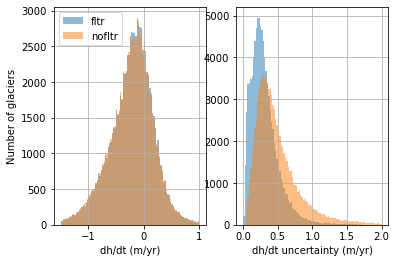

In [165]:
mb_hist_opt = {'bins':100, 'range':(-1.5, 1.0), 'alpha':0.5}
f,axa = plt.subplots(1,2)
mb_fltr['dhdt_ma'].hist(ax=axa[0], label='fltr', **mb_hist_opt)
mb_nofltr['dhdt_ma'].hist(ax=axa[0], label='nofltr', **mb_hist_opt)
mb_hist_opt['range'] = (0,2)
mb_fltr['dhdt_ma_sigma'].hist(ax=axa[1], label='fltr', **mb_hist_opt)
mb_nofltr['dhdt_ma_sigma'].hist(ax=axa[1], label='nofltr', **mb_hist_opt)
axa[0].legend()
axa[0].set_xlabel("dh/dt (m/yr)")
axa[0].set_ylabel("Number of glaciers")
axa[1].set_xlabel("dh/dt uncertainty (m/yr)")

Text(0.5, 0, 'Mass balance uncertainty (m w.e./yr)')

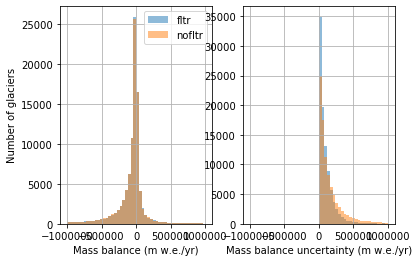

In [167]:
mb_hist_opt = {'bins':50, 'range':(-1E6,1E6),'alpha':0.5}
f,axa = plt.subplots(1,2)
mb_fltr['mb_m3wea'].hist(ax=axa[0], label='fltr', **mb_hist_opt)
mb_nofltr['mb_m3wea'].hist(ax=axa[0], label='nofltr', **mb_hist_opt)
#mb_hist_opt['range'] = (0,2)
mb_fltr['mb_m3wea_sigma'].hist(ax=axa[1], label='fltr', **mb_hist_opt)
mb_nofltr['mb_m3wea_sigma'].hist(ax=axa[1], label='nofltr', **mb_hist_opt)
axa[0].legend()
axa[0].set_xlabel("Mass balance (m w.e./yr)")
axa[0].set_ylabel("Number of glaciers")
axa[1].set_xlabel("Mass balance uncertainty (m w.e./yr)")

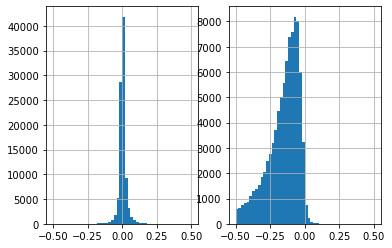

In [168]:
f,axa = plt.subplots(1,2)
mb_diff['dhdt_ma'].hist(ax=axa[0],bins=50, range=(-0.5, 0.5))
mb_diff['dhdt_ma_sigma'].hist(ax=axa[1],bins=50, range=(-0.5, 0.5))

## Evaluate percent of glacier polygon covered by dh/dt map

Text(0.5, 0, 'Percent of polygon with valid data')

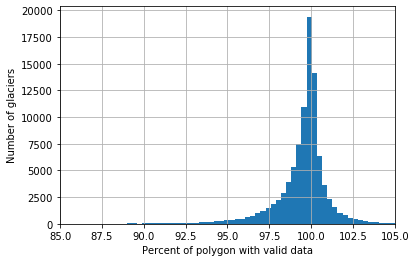

In [30]:
ax = mb_df['valid_area_perc'].hist(bins=128)
ax.set_xlim(85, 105)
ax.set_ylabel("Number of glaciers")
ax.set_xlabel("Percent of polygon with valid data")

In [31]:
#95th percentile of coverage
np.percentile(mb_df['valid_area_perc'], 5)

96.617

In [178]:
mb_df['valid_area_perc'].mean()

99.5031852533496

In [190]:
np.percentile(mb_df['valid_area_perc'], (10))

97.755

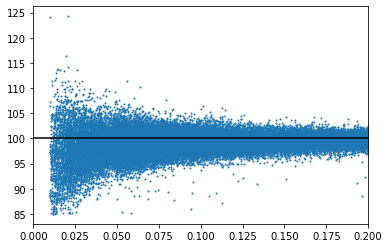

In [32]:
#Glacier area vs. percent coverage
f,ax = plt.subplots()
ax.scatter(mb_df['area_m2']/1E6, mb_df['valid_area_perc'], s=1)
ax.set_xlim(0,0.2)
ax.axhline(100,color='k')

## Final count of DEMs in each stack

In [72]:
#Generate text files from valid DEMs that were included in stacks
#cd /nobackupp8/deshean/hma/combined_aster_wv/dem_align_ASTER_WV_index_2000-2018_aea_stack
#parallel --progress 'wc -l {}/*fn_list.txt > {}/stack_count.txt' ::: 1*
#cat 1*/stack_count.txt > stack_count.txt

In [73]:
combined_count_fn = '/nobackupp8/deshean/hma/combined_aster_wv/dem_align_ASTER_WV_index_2000-2018_aea_stack/stack_count.txt'
aster_count_fn = '/nobackup/deshean/hma/aster/dsm/dem_align_ASTERonly/dem_align_ASTERonly_index_2000-2018_aea_stack/stack_count.txt'

In [74]:
def count_proc(count_fn):
    count_df = pd.read_csv(count_fn, sep=' ', names=['stack_count', 'stack_name'])
    count_df['RGIId'] = count_df['stack_name'].str.split('/',1).str[0]
    count_df.set_index('RGIId', inplace=True)
    return count_df

In [ ]:
combined_count_df = count_proc(combined_count_fn)
aster_count_df = count_proc(aster_count_fn)

In [68]:
combined_count_df['stack_count'].median()

35.0

In [67]:
aster_count_df['stack_count'].median()

33.0

Text(0, 0.5, 'Number of stacks')

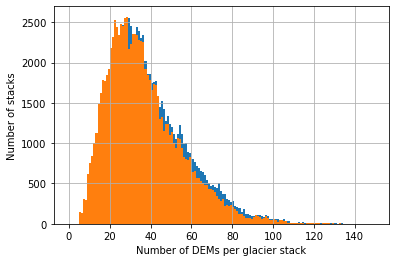

In [69]:
ax = combined_count_df['stack_count'].hist(bins=np.arange(0,150))
aster_count_df['stack_count'].hist(bins=np.arange(0,150))
ax.set_xlabel("Number of DEMs per glacier stack")
ax.set_ylabel("Number of stacks")

In [70]:
combined_count_df['aster_stack_count'] = aster_count_df['stack_count']

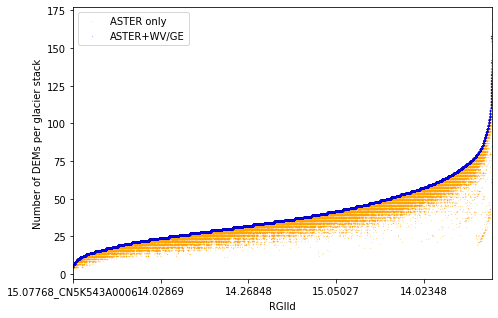

In [71]:
f,ax = plt.subplots(figsize=(7.5,5))
combined_count_df.sort_values(by='stack_count')['aster_stack_count'].plot(ax=ax, color='orange', lw=0, marker='.', ms=0.2, label='ASTER only')
combined_count_df.sort_values(by='stack_count')['stack_count'].plot(ax=ax, color='blue', lw=0, marker='.', ms=0.2, label='ASTER+WV/GE')
ax.set_ylabel("Number of DEMs per glacier stack")
plt.legend(loc='upper left')

In [72]:
combined_count_df['diff'] = combined_count_df['stack_count'] - combined_count_df['aster_stack_count']

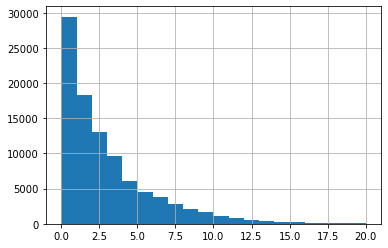

In [78]:
combined_count_df['diff'].hist(bins=20, range=(0,20))

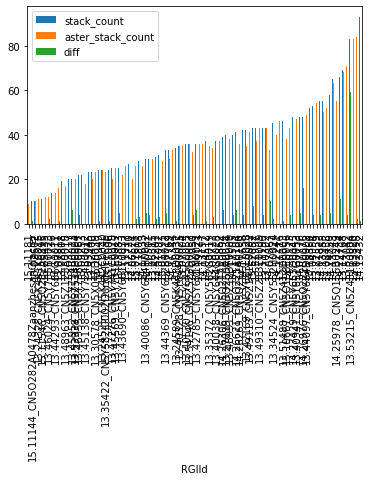

In [80]:
combined_count_df.sample(100).sort_values(by='stack_count').plot.bar()

## Total glacier area covered

In [124]:
#MB total area
mb_area = glac_df_mb.area.sum()/1E6
#RGI total area
rgi_area = glac_df['Area'].sum()
#rgi_area = glac_df.area.sum()/1E6
print('MB area: %0.2f km^2' % mb_area)
print('RGI area: %0.2f km^2' % rgi_area)
print('Percent coverage: %0.2f%%' % (100*mb_area/rgi_area))

MB area: 97002.70 km^2
RGI area: 97300.12 km^2
Percent coverage: 99.69%


In [125]:
#Total RGI glacier count
rgi_count = 95608 - 72 #some RGI 10 included in our gpkg
mb_count = glac_df_mb.shape[0]
print('MB count: %i' % mb_count)
print('RGI count: %i' % rgi_count)
print('Percent coverage: %0.2f%%' % (100*mb_count/rgi_count))

MB count: 94436
RGI count: 95536
Percent coverage: 98.85%


## Sort by area

In [126]:
glac_df_mb_sort = glac_df_mb.sort_values(by='area_m2', ascending=False)

(-2, 2)

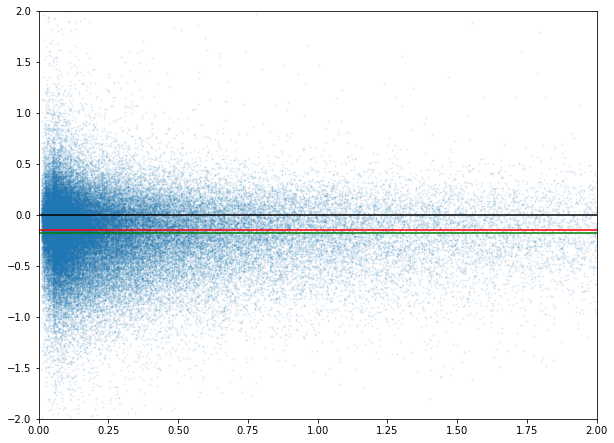

In [127]:
f,ax = plt.subplots(figsize=(10,7.5))
ax.scatter(glac_df_mb['Area'], glac_df_mb['mb_mwea'], s=1, alpha=0.1)
ax.axhline(0,c='k')
ax.axhline(glac_df_mb['mb_mwea'].median(),c='r')
ax.axhline(glac_df_mb['mb_mwea'].mean(),c='g')
ax.set_xlim(0,2)
ax.set_ylim(-2, 2)

(0, 100)

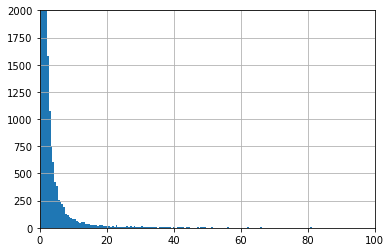

In [83]:
ax = glac_df_mb['Area'].hist(bins=2000)
ax.set_ylim(0,2000)
ax.set_xlim(0,100)

(-10000000.0, 10000000.0)

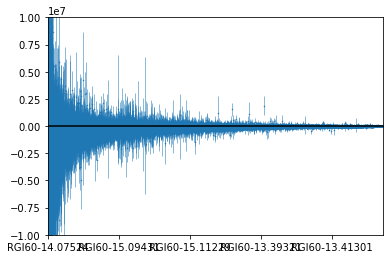

In [196]:
#Plot mb and error for all glaciers, sorted by area
f, ax = plt.subplots()
glac_df_mb_sort['mb_m3wea'].plot(marker='.', markersize=1, ls='none', lw=0.5, \
                                 yerr=glac_df_mb_sort['mb_m3wea_sigma'], ax=ax)
ax.axhline(0, color='k', zorder=99)
ax.set_ylim(-0.1E8, 0.1E8)

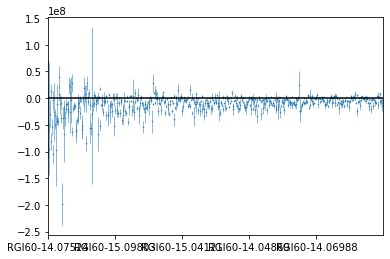

In [197]:
f, ax = plt.subplots()
cutoff = 500
glac_df_mb_sort['mb_m3wea'].head(cutoff).plot(marker='.', markersize=1, ls='none', lw=0.5, \
                                 yerr=glac_df_mb_sort['mb_m3wea_sigma'].head(cutoff), ax=ax)
ax.axhline(0, color='k', zorder=99)

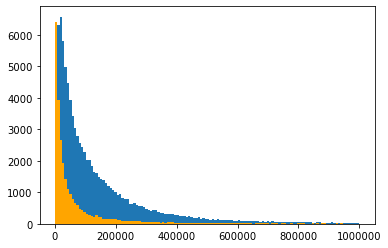

In [198]:
f, ax = plt.subplots()
asdf = ax.hist(glac_df_mb['mb_m3wea_sigma'], bins=128, range=(0,1E6))
asdf = ax.hist(glac_df_mb['mb_m3wea'], bins=128, range=(0,1E6), color='orange')
#mb_df['mb_m3wea'].hist(bins=128, range=(0,1E6),ax=ax)

In [199]:
idx = slice(0,100000)
print(glac_df_mb['mb_m3wea'].iloc[idx].sum()/1E9)
print(rss(glac_df_mb['mb_m3wea_sigma'].iloc[idx])/1E9)
print(glac_df_mb['mb_m3wea_sigma'][idx].sum()/1E9)

-18.975358849018004
0.3254717068424677
21.524032616649997


In [85]:
def mb_hist(df, col='mb_mwea', hist_clim=(-1.5, 1.5), outlier_clim=None):
    f, ax = plt.subplots(figsize=(4,4))
    ax.set_xlabel('Mass balance (m we/yr)')
    ax.set_ylabel('Number of glaciers')
    ax.set_xlim(*hist_clim)
    df[col].hist(range=hist_clim, bins=64, grid=False)
    ax.axvline(0, lw=0.5, color='k')
    if outlier_clim is not None:
        ax.axvline(outlier_clim[0], lw=1.0, color='r', ls=':')
        ax.axvline(outlier_clim[1], lw=1.0, color='r', ls=':')
    ax.minorticks_on()
    return ax

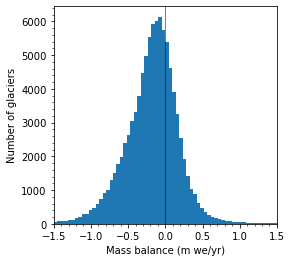

In [55]:
ax = mb_hist(glac_df_mb)

## Remove Outliers

Removing outliers
-6.29
13.287
Removing outliers (-2.84, 2.84)
94436 records before outlier removal
94389 records after outlier removal


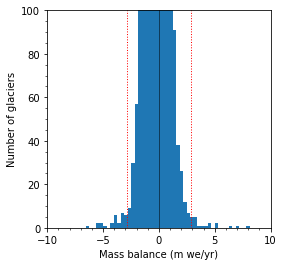

In [128]:
remove_outliers = True
if remove_outliers:
    print("Removing outliers")

    print(glac_df_mb['mb_mwea'].min())
    print(glac_df_mb['mb_mwea'].max())
    
    if False:
        #outlier_perc = (0.01, 0.99)
        outlier_perc = (0.0001, 0.9999)
        outlier_clim = (glac_df_mb['mb_mwea'].quantile(outlier_perc[0]), glac_df_mb['mb_mwea'].quantile(outlier_perc[1]))
    else:
        std_f = 7
        outlier_clim = glac_df_mb['mb_mwea'].mean() - std_f*glac_df_mb['mb_mwea'].std()
        #outlier_clim = glac_df_mb['mb_mwea'].median() - std_f*malib.mad(glac_df_mb['mb_mwea'].values)
        outlier_clim = (outlier_clim, -outlier_clim)
    
    ax = mb_hist(glac_df_mb, hist_clim=(-10,10), outlier_clim=outlier_clim)
    ax.set_ylim(0,100)
    
    print("Removing outliers (%0.2f, %0.2f)" % (outlier_clim))
    #inlier_idx = np.abs(glac_df_mb['mb_mwea'] - glac_df_mb['mb_mwea'].mean()) <= (3*glac_df_mb['mb_mwea'].std())
    inlier_idx = (glac_df_mb['mb_mwea'] >= outlier_clim[0]) & (glac_df_mb['mb_mwea'] <= outlier_clim[1])

    print("%i records before outlier removal" % (glac_df_mb.shape[0]))
    print("%i records after outlier removal" % (glac_df_mb[inlier_idx].shape[0]))
    glac_df_mb = glac_df_mb[inlier_idx]

In [129]:
idx = slice(0,100000)
print(glac_df_mb['mb_m3wea'].iloc[idx].sum()/1E9)
print(rss(glac_df_mb['mb_m3wea_sigma'].iloc[idx])/1E9)
print(glac_df_mb['mb_m3wea_sigma'][idx].sum()/1E9)

-18.962813928534
0.32543324598947004
21.500476323924005


# Spatial autocorrelation factor Acorf vs. glacier area A
A quick look at the coefficient used to scale area 

785398.1633974483


Text(0, 0.5, 'Acorf')

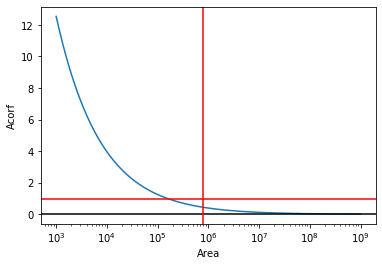

In [670]:
areaa = np.logspace(3, 9, 100)
L = 500
Acor = np.pi*(L**2)
print(Acor)
Acorf = np.sqrt(Acor/(5*areaa))
f,ax = plt.subplots()
ax.semilogx(areaa, Acorf)
ax.axhline(1.0, color='r')
ax.axhline(0.0, color='k')
ax.axvline(Acor, color='r')
ax.set_xlabel('Area')
ax.set_ylabel('Acorf')

## Binned mb by glacier polygon area

In [83]:
#bins=np.arange(0,500,1)
bins=np.logspace(-2,3,128)
bin_count, bin_edges, binnumber = scipy.stats.binned_statistic(glac_df_mb['Area'], glac_df_mb['mb_mwea'], statistic='count', bins=bins)
bin_mean, bin_edges, binnumber = scipy.stats.binned_statistic(glac_df_mb['Area'], glac_df_mb['mb_mwea'], statistic='mean', bins=bins)
bin_std, bin_edges, binnumber = scipy.stats.binned_statistic(glac_df_mb['Area'], glac_df_mb['mb_mwea'], statistic=np.std, bins=bins)
bin_median, bin_edges, binnumber = scipy.stats.binned_statistic(glac_df_mb['Area'], glac_df_mb['mb_mwea'], statistic='median', bins=bins)
#scipy.stats.median_absolute_deviation in version 1.3.0
bin_nmad, bin_edges, binnumber = scipy.stats.binned_statistic(glac_df_mb['Area'], glac_df_mb['mb_mwea'], statistic=malib.mad, bins=bins)

In [84]:
#bin_width = (bin_edges[1] - bin_edges[0])
#bin_centers = bin_edges[1:] - bin_width/2
bin_width = (bin_edges[:-1] - bin_edges[1:])
bin_centers = bin_edges[:-1] - bin_width/2

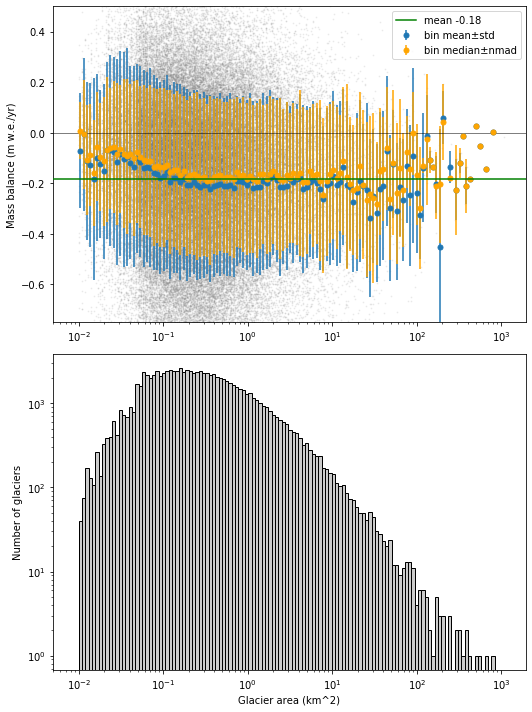

In [85]:
f,axa = plt.subplots(2, figsize=(7.5,10), sharex=True)
axa[0].scatter(glac_df_mb['Area'], glac_df_mb['mb_mwea'], s=1, c='0.5', alpha=0.1)
axa[0].errorbar(bin_centers, bin_mean, ls='none', yerr=bin_std, marker='o', markersize=5, label='bin mean\u00b1std')
axa[0].errorbar(bin_centers, bin_median, ls='none', c='orange', yerr=bin_nmad, marker='o', markersize=5, label='bin median\u00b1nmad')
axa[0].axhline(0,c='k',lw=0.5)
#axa[0].axhline(glac_df_mb['mb_mwea'].median(),c='r')
axa[0].axhline(glac_df_mb['mb_mwea'].mean(),c='g',zorder=999, label='mean %0.2f' % glac_df_mb['mb_mwea'].mean())
axa[0].set_ylim(-0.75,0.5)
axa[1].bar(bin_centers, bin_count, width=bin_width, edgecolor='k', facecolor='0.8')
#axa[1].bar(bin_centers, bin_count, edgecolor='k')
axa[1].set_xlabel('Glacier area (km^2)')
axa[0].set_xscale('log')
axa[0].set_ylabel('Mass balance (m w.e./yr)')
axa[1].set_yscale('log')
axa[1].set_ylabel('Number of glaciers')
axa[0].legend()
#axa[1].set_ylim(0,10)
#axa[0].set_xlim(bins[0], bins[-1])
axa[0].xaxis.set_tick_params(which='both', labelbottom=True)
plt.tight_layout()
fig_fn = os.path.splitext(glac_shp_join_fn)[0] + out_fn_suffix + '_area_v_mb.png'
#f.savefig(fig_fn, **plt_opt)

## Consider total mb for small and large glaciers

In [43]:
area_thresh = 0.1 #km2
small_idx = glac_df_mb['Area'] < area_thresh
big_idx = glac_df_mb['Area'] >= area_thresh

In [44]:
print(glac_df_mb['mb_mwea'][small_idx].mean())
print(glac_df_mb['mb_mwea'][small_idx].median())
print(glac_df_mb['mb_m3wea'][small_idx].sum()/1E9)
print(glac_df_mb['Area'][small_idx].sum())

-0.13279346399868788
-0.105
-0.206847295014
1448.8449999999998


In [45]:
print(glac_df_mb['mb_mwea'][big_idx].mean())
print(glac_df_mb['mb_mwea'][big_idx].median())
print(glac_df_mb['mb_m3wea'][big_idx].sum()/1E9)
print(glac_df_mb['Area'][big_idx].sum())

-0.19892844387937317
-0.168
-18.75596663352
95544.57500000001


In [46]:
mb_gt_lt = glac_df_mb['Area'][small_idx].sum()*glac_df_mb['mb_mwea'][small_idx].mean()/1000
mb_gt_lt

-0.19239714634717894

In [47]:
mb_gt_gt = glac_df_mb['Area'][small_idx].sum()*glac_df_mb['mb_mwea'][big_idx].mean()/1000
mb_gt_gt

-0.28821648127241034

In [48]:
# Difference in total mass balance (Gt/yr) if applying specific mass balance from larger glaciers to all glaciers under 0.1 km2
mb_gt_gt - mb_gt_lt

-0.0958193349252314

## Maps of glaciers binned by area

In [147]:
bins=np.logspace(-2,3,11)
bins

array([1.00000000e-02, 3.16227766e-02, 1.00000000e-01, 3.16227766e-01,
       1.00000000e+00, 3.16227766e+00, 1.00000000e+01, 3.16227766e+01,
       1.00000000e+02, 3.16227766e+02, 1.00000000e+03])

In [148]:
df_cut = pd.cut(glac_df_mb['Area'], bins)

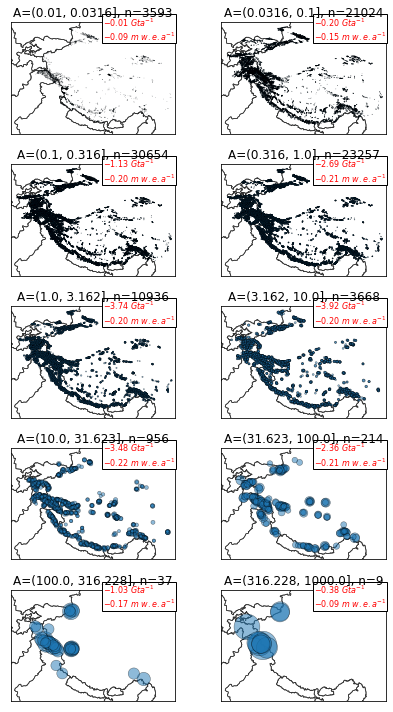

In [149]:
rc = (5,2)
f,axa = plt.subplots(*rc, figsize=(6,10), sharex=True, sharey=True)
axa = axa.ravel()

for n,i in enumerate(glac_df_mb.groupby(df_cut)):
    border_df.plot(ax=axa[n], facecolor='none', edgecolor='0.2', lw=0.7)
    axa[n].scatter(i[1]['x'], i[1]['y'], s=i[1]['Area'], label=i[0], edgecolor='k', lw=0.5, alpha=0.5)
    axa[n].set_title('A=%s, n=%i' % (i[0], i[1].shape[0]))
    mb_gta = i[1]['mb_m3wea'].sum()/1E9
    mb_mwea = i[1]['mb_m3wea'].sum()/i[1]['area_m2'].sum()
    #mb_label = r'$%0.2f Gta^-1$' % mb_gta
    #axa[n].annotate(mb_label, xy=(0.05, 0.05), xycoords='axes fraction', color='r')
    mb_label = r'$%0.2f\ Gta^{-1}$' % mb_gta +'\n' + '$%0.2f\ m\ w.e.a^{-1}$' % mb_mwea
    #axa[n].annotate(mb_label, xy=(0.01, 0.06), xycoords='axes fraction', color='r', fontsize=8)
    axa[n].text(0.56, 0.84, mb_label, transform=axa[n].transAxes, color='r', fontsize=8, \
    #axa[n].text(0.56, 0.8, mb_label, transform=axa[n].transAxes, color='r', fontsize=7, \
                bbox=dict(facecolor='white', alpha=1.0, edgecolor='k', pad=1.0))
    pltlib.hide_ticks(axa[n])

axa[0].set_xlim(extent[0], extent[2])
axa[0].set_ylim(extent[1], extent[3])
axa[0].set_aspect('equal')

plt.tight_layout()
#plt.suptitle("Spatial distribution of glaciers, binned by area (km2)")
fig_fn = os.path.splitext(glac_shp_join_fn)[0] + out_fn_suffix + '_area_spatial.png'
f.savefig(fig_fn, **plt_opt)

In [150]:
i[1]['mb_m3wea'].sum()/i[1]['area_m2'].sum()

-0.08586631367961631

In [151]:
i[1].columns

Index(['GLIMSId', 'BgnDate', 'EndDate', 'CenLon', 'CenLat', 'O1Region',
       'O2Region', 'Area', 'Zmin', 'Zmax', 'Zmed', 'Slope', 'Aspect', 'Lmax',
       'Status', 'Connect', 'Form', 'TermType', 'Surging', 'Linkages', 'Name',
       'geometry', 'mascon', 'area_deg', 'area_km2', 'basin', 'elev_flag',
       'lat_center', 'lat_span', 'location', 'lon_center', 'lon_span', 'qdgc',
       'lat', 'lon', 'areakm2', 'id', 'left', 'top', 'right', 'bottom',
       'kaab_region', 'himap_region', 'basin_name', 'DN_left', 'ENDO', 'ENDO',
       'DN_right', 'x', 'y', 'z_med', 'z_min', 'z_max', 'z_slope', 'z_aspect',
       'dhdt_ma', 'dhdt_ma_sigma', 'mb_mwea', 'mb_mwea_sigma', 'area_m2',
       'mb_m3wea', 'mb_m3wea_sigma', 't1', 't2', 'dt', 'valid_area_perc',
       'H_m', 'debris_m', 'perc_debris', 'perc_pond', 'perc_clean', 'vm_ma',
       'mb_Gta', 'mb_Gta_sigma'],
      dtype='object')

In [152]:
glac_df_mb['mb_m3wea'].groupby(df_cut).agg('sum')/1E9

Area
(0.01, 0.0316]      -0.01
(0.0316, 0.1]       -0.20
(0.1, 0.316]        -1.13
(0.316, 1.0]        -2.69
(1.0, 3.162]        -3.74
(3.162, 10.0]       -3.92
(10.0, 31.623]      -3.48
(31.623, 100.0]     -2.36
(100.0, 316.228]    -1.03
(316.228, 1000.0]   -0.38
Name: mb_m3wea, dtype: float64

## RGI Polygon Date

In [176]:
rgi_decyear=glac_df_mb['BgnDate'].astype(int)/10000
miny = np.floor(rgi_decyear.min())
maxy = np.ceil(rgi_decyear.max())
print(miny, maxy)

1998.0 2014.0


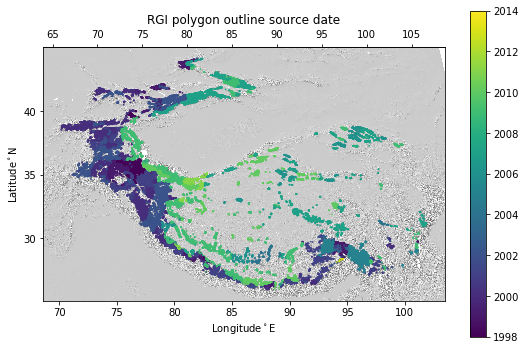

In [50]:
f,ax = plt.subplots(figsize=(9,6))
sc = ax.scatter(glac_df_mb['x'], glac_df_mb['y'], c=rgi_decyear, s=0.5, vmin=miny, vmax=maxy)
plt.colorbar(sc)
ax.set_title("RGI polygon outline source date")
ax.set_aspect('equal', adjustable='box')
add_hs(hs, ax, hs_clim, hs_extent_cartopy)
pltlib.latlon_ticks(ax, in_crs=glac_crs)

#glac_df_mb.plot.scatter(x='x', y='y', c='BgnDate')
rgi_date_fig_fn = os.path.splitext(glac_shp_join_fn)[0]+'_RGI_sourceyear_fig.png'
f.savefig(rgi_date_fig_fn, **plt_opt)

In [51]:
# Check min/max mass numbers
rgi_idx = [glac_df_mb['mb_m3wea'].idxmax(),]
rgi_idx.append(glac_df_mb['mb_m3wea'].idxmin())
glac_df_mb.loc[rgi_idx]

GLIMSId   BgnDate   EndDate  CenLon  CenLat O1Region  \
RGI60-14.04404  G075438E36192N  19980813  -9999999   75.44   36.19       14   
RGI60-15.11909  G096657E29334N  20050908  -9999999   96.66   29.33       15   

               O2Region   Area  Zmin  Zmax  Zmed  Slope  Aspect   Lmax  \
RGI60-14.04404        2 203.34  3314  7718  5391  23.60      21  31640   
RGI60-15.11909        3 179.59  3980  6341  5207  12.90      78  32403   

                Status  Connect  Form  TermType  Surging  Linkages  \
RGI60-14.04404       0        0     0         0        3         9   
RGI60-15.11909       0        0     1         0        1         9   

                             Name  \
RGI60-14.04404  Khurdopin Glacier   
RGI60-15.11909            Yagnung   

                                                         geometry  mascon  \
RGI60-14.04404  POLYGON ((-832770.2283471222 56816.06814658215...  36N76E   
RGI60-15.11909  POLYGON ((1108921.644128018 -679012.9025896977...  29N97E   

                area_deg  area_km2    basin  elev_flag  lat_center  lat_span  \
RGI60-14.04404      1.00 12,373.54 5,051.00       0.00       36.00      1.00   
RGI60-15.11909      1.00 12,406.28 5,035.00       0.00       29.00      1.00   

                location  lon_center  lon_span      qdgc    lat    lon  \
RGI60-14.04404     80.00       76.08      1.24  E075N36C  36.25  75.25   
RGI60-15.11909     80.00       96.88      1.15  E096N29D  29.25  96.75   

                   areakm2     id         left         top        right  \
RGI60-14.04404  2493.27629   2985  -842,814.95   71,740.08  -813,947.44   
RGI60-15.11909  2693.48103  11025 1,105,742.21 -678,259.92 1,134,609.72   

                    bottom     kaab_region     himap_region   basin_name  \
RGI60-14.04404   46,740.08       Karakoram        Karakoram        Indus   
RGI60-15.11909 -703,259.92  Nyainqentangla  Nyainqentanglha  Brahmaputra   

                DN_left  ENDO  ENDO  DN_right            x           y  \
RGI60-14.04404     5367     0     0        51  -838,312.43   62,425.23   
RGI60-15.11909       21     0     0        51 1,117,064.38 -685,115.41   

                  z_med    z_min    z_max  z_slope  z_aspect  dhdt_ma  \
RGI60-14.04404 5,369.00 3,295.32 7,510.49    15.66    143.91     0.23   
RGI60-15.11909 5,166.14 3,921.18 6,317.99     9.99    116.07    -1.30   

                dhdt_ma_sigma  mb_mwea  mb_mwea_sigma        area_m2  \
RGI60-14.04404           0.01     0.20           0.06 203,335,845.65   
RGI60-15.11909           0.01    -1.10           0.09 179,589,230.18   

                      mb_m3wea  mb_m3wea_sigma       t1       t2    dt  \
RGI60-14.04404   39,691,132.12    5,224,127.20 2,000.41 2,018.41 18.00   
RGI60-15.11909 -198,383,836.77   24,336,811.74 2,000.41 2,018.41 18.00   

                valid_area_perc    H_m  debris_m  perc_debris  perc_pond  \
RGI60-14.04404           100.00 142.66      0.18        15.82       0.45   
RGI60-15.11909            99.96 171.93      0.14        10.37       0.13   

                perc_clean  vm_ma  mb_Gta  mb_Gta_sigma  
RGI60-14.04404       83.72  53.99    0.04          0.01  
RGI60-15.11909       89.51  61.99   -0.20          0.02

In [52]:
#mb_m3wea_sigma_thresh = glac_df_mb['mb_m3wea_sigma'].quantile(0.99)
#glac_df_mb = glac_df_mb[glac_df_mb['mb_m3wea_sigma'] < mb_m3wea_sigma_thresh]

In [53]:
#Evaluate SNR
glac_df_mb['SNR'] = glac_df_mb['mb_m3wea'].abs()/glac_df_mb['mb_m3wea_sigma']

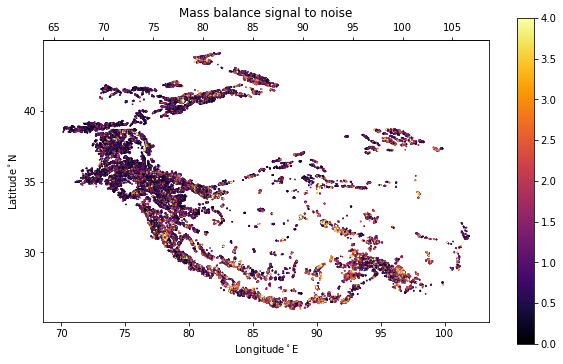

In [54]:
f,ax = plt.subplots(figsize=(10,6))
sc = ax.scatter(glac_df_mb['x'], glac_df_mb['y'], c=glac_df_mb['SNR'], s=0.5, cmap='inferno', vmin=0, vmax=4)
plt.colorbar(sc)
ax.set_aspect('equal')
ax.set_title("Mass balance signal to noise")
pltlib.latlon_ticks(ax, in_crs=glac_crs)
#glac_df_mb.plot.scatter(x='x', y='y', c='BgnDate')
#rgi_date_fig_fn = os.path.splitext(glac_shp_join_fn)[0]+'_SNR_fig.png'
#f.savefig(rgi_date_fig_fn, **plt_opt)

# Aggregation over hexagon bins for independent spatial samples

In [130]:
if hex_shp_fn is not None:
    glac_df_mb_hex = spatial_aggregate(glac_df, glac_df_mb, hex_df, hex_col)

/Users/dshean/sw/miniconda3/envs/shean_py3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


In [131]:
#glac_gdf_mb_hex = gpd.GeoDataFrame(glac_df_mb_hex, geometry=hex_df.geometry)
from shapely.geometry import Point
hex_geom = [Point(p) for p in zip(glac_df_mb_hex['centroid_x'], glac_df_mb_hex['centroid_y'])]
glac_gdf_mb_hex = gpd.GeoDataFrame(glac_df_mb_hex, geometry=hex_geom)

In [132]:
glac_df_mb_hex.shape

(1166, 62)

In [133]:
glac_df_mb_hex.dropna(axis=0, how='any').shape

(1099, 62)

In [134]:
#Note, some nan values for some columns here
glac_df_mb_hex.head()

(area_m2, mean)   (area_m2, sum)  (mb_mwea, mean)  (mb_mwea, median)  \
id                                                                           
1349     6,767,507.77 1,455,014,170.08            -0.14              -0.12   
1181     6,645,791.64 1,309,220,953.14             0.00              -0.01   
1292     6,794,534.52 1,175,454,471.30            -0.05              -0.03   
1237     7,568,293.70 1,127,675,760.99             0.07               0.05   
789      7,365,463.09 1,119,550,389.98            -0.00              -0.02   

      (mb_mwea, std)  (mb_mwea, sum)  (mb_mwea, size)  (mb_mwea_sigma, mean)  \
id                                                                             
1349            0.33          -29.21           215.00                   0.59   
1181            0.30            0.54           197.00                   0.37   
1292            0.37           -9.32           173.00                   0.51   
1237            0.23           10.66           149.00                   0.31   
789             0.19           -0.74           152.00                   0.24   

      (mb_mwea_sigma, sum)  (mb_mwea_sigma, rss)  (mb_m3wea, mean)  \
id                                                                   
1349                126.24                 10.38       -356,998.73   
1181                 72.95                  6.38       -242,162.51   
1292                 87.83                  8.29       -167,803.66   
1237                 45.60                  4.41       -555,912.31   
789                  37.23                  3.39     -1,010,882.54   

      (mb_m3wea, median)  (mb_m3wea, sum)  (mb_m3wea_sigma, mean)  \
id                                                                  
1349           -9,496.34   -76,754,727.85              942,947.35   
1181           -2,235.11   -47,706,014.94              608,482.48   
1292           -4,297.50   -29,030,032.83              731,408.73   
1237            8,493.83   -82,830,933.73              868,301.79   
789            -5,233.03  -153,654,145.94              541,074.63   

      (mb_m3wea_sigma, sum)  (mb_m3wea_sigma, rss)  (mb_m3wea_sigma, rms)  \
id                                                                          
1349         202,733,679.84         100,882,272.77           6,880,113.90   
1181         119,871,049.44          42,481,158.91           3,026,657.25   
1292         126,533,711.13          70,101,115.20           5,329,689.10   
1237         129,376,966.56          59,934,823.69           4,910,052.07   
789           82,243,343.83          49,428,751.42           4,009,201.15   

      (mb_Gta, sum)  (mb_Gta_sigma, mean)  (mb_Gta_sigma, sum)  \
id                                                               
1349          -0.08                  0.00                 0.20   
1181          -0.05                  0.00                 0.12   
1292          -0.03                  0.00                 0.13   
1237          -0.08                  0.00                 0.13   
789           -0.15                  0.00                 0.08   

      (mb_Gta_sigma, rss)  (mb_Gta_sigma, rms)  (Area, mean)  (Area, sum)  \
id                                                                          
1349                 0.10                 0.01          6.77     1,455.02   
1181                 0.04                 0.00          6.65     1,309.22   
1292                 0.07                 0.01          6.79     1,175.46   
1237                 0.06                 0.00          7.57     1,127.67   
789                  0.05                 0.00          7.37     1,119.55   

      (t1, mean)  (t1, amin)  (t1, amax)  (t2, mean)  (t2, amin)  (t2, amax)  \
id                                                                             
1349    2,000.41    2,000.41    2,000.41    2,018.41    2,018.41    2,018.41   
1181    2,000.41    2,000.41    2,000.41    2,018.41    2,018.41    2,018.41   
1292    2,000.41    2,000.41    2,000.41    2,018.41    2,01

In [135]:
cols = [('mb_mwea', 'size'),('mb_Gta', 'sum'), ('mb_Gta_sigma', 'sum'), ('meltwater', 'count'), ('meltwater', 'total_Gta'), ('meltwater', 'total_Gta_sigma')]
glac_df_mb_hex[cols].head()

(mb_mwea, size)  (mb_Gta, sum)  (mb_Gta_sigma, sum)  (meltwater, count)  \
id                                                                              
1349           215.00          -0.08                 0.20              158.00   
1181           197.00          -0.05                 0.12              106.00   
1292           173.00          -0.03                 0.13              101.00   
1237           149.00          -0.08                 0.13               50.00   
789            152.00          -0.15                 0.08               83.00   

      (meltwater, total_Gta)  (meltwater, total_Gta_sigma)  
id                                                          
1349                   -0.08                          0.19  
1181                   -0.10                          0.08  
1292                   -0.04                          0.05  
1237                   -0.10                          0.10  
789                    -0.16                          0.08

In [136]:
glac_df_mb_hex.describe()

(area_m2, mean)   (area_m2, sum)  (mb_mwea, mean)  (mb_mwea, median)  \
count         1,166.00         1,166.00         1,166.00           1,166.00   
mean        764,591.71    83,184,678.62            -0.22              -0.22   
std       1,080,467.18   151,514,962.75             0.26               0.26   
min          11,200.72        11,200.72            -1.68              -1.90   
25%         222,481.75     3,963,998.66            -0.37              -0.38   
50%         463,037.92    24,831,471.93            -0.19              -0.19   
75%         876,380.17    96,373,371.39            -0.04              -0.05   
max      13,374,640.98 1,455,014,170.08             0.84               0.84   

       (mb_mwea, std)  (mb_mwea, sum)  (mb_mwea, size)  (mb_mwea_sigma, mean)  \
count        1,115.00        1,166.00         1,166.00               1,166.00   
mean             0.26          -14.72            80.95                   0.39   
std              0.13           27.53            82.96                   0.22   
min              0.00         -212.72             1.00                   0.05   
25%              0.17          -20.95            14.00                   0.24   
50%              0.23           -5.68            50.00                   0.34   
75%              0.31           -0.57           129.00                   0.47   
max              1.04           54.10           411.00                   2.89   

       (mb_mwea_sigma, sum)  (mb_mwea_sigma, rss)  (mb_m3wea, mean)  \
count              1,166.00              1,166.00          1,166.00   
mean                  31.04                  3.29       -160,011.49   
std                   37.47                  2.90        288,304.31   
min                    0.05                  0.05     -2,752,673.52   
25%                    4.68                  1.27       -214,711.25   
50%                   16.56                  2.44        -85,949.63   
75%                   44.25                  4.46        -21,156.63   
max                  288.66                 27.87        974,696.82   

       (mb_m3wea, median)  (mb_m3wea, sum)  (mb_m3wea_sigma, mean)  \
count            1,166.00         1,166.00                1,166.00   
mean           -48,815.63   -16,263,133.73              180,844.00   
std             95,609.62    38,494,323.07              210,707.54   
min         -2,294,873.86  -309,599,852.44                2,361.95   
25%            -73,278.50   -16,513,620.05               71,160.38   
50%            -29,726.83    -3,052,353.88              127,769.39   
75%             -5,624.72      -172,674.46              220,527.08   
max            278,410.32    82,911,551.04            3,913,844.04   

       (mb_m3wea_sigma, sum)  (mb_m3wea_sigma, rss)  (mb_m3wea_sigma, rms)  \
count               1,166.00               1,166.00               1,166.00   
mean           18,439,516.57           3,895,946.22             386,165.53   
std            29,107,182.79           8,701,476.70             841,992.00   
min                 2,361.95               2,361.95               2,361.95   
25%             1,278,669.87             414,040.89              98,578.56   
50%             6,732,852.47           1,381,820.32             187,855.72   
75%            22,773,905.88           3,562,207.34             379,721.38   
max           228,373,673.52         149,059,110.08          20,474,843.42   

       (mb_Gta, sum)  (mb_Gta_sigma, mean)  (mb_Gta_sigma, sum)  \
count       1,166.00              1,166.00             1,166.00   
mean           -0.02                  0.00                 0.02   
std             0.04                  0.00                 0.03   
min            -0.31                  0.00                 0.00   
25%            -0.02                  0.00                 0.00   
50%            -0.00                  0.00                 0.01   
75%            -0.00                  0.00                 0.02   
max             0.08                  0.00             

In [65]:
sc_kw = {'marker':'.'}

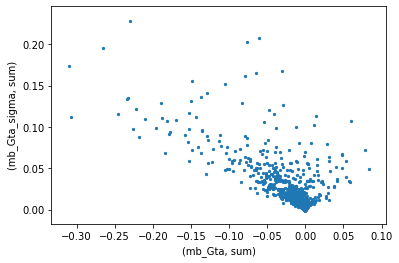

In [66]:
glac_df_mb_hex.plot.scatter(x=('mb_Gta', 'sum'),y=('mb_Gta_sigma', 'sum'), **sc_kw) 

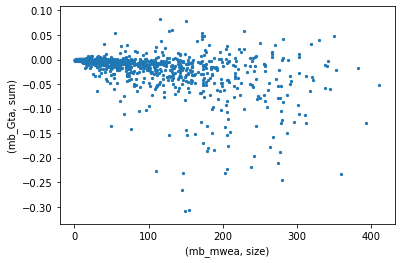

In [67]:
glac_df_mb_hex.plot.scatter(x=('mb_mwea', 'size'),y=('mb_Gta', 'sum'), **sc_kw) 

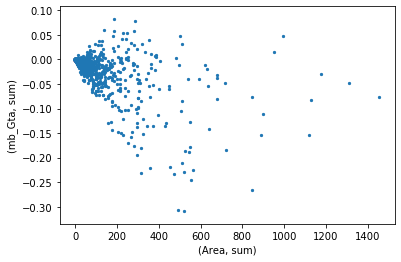

In [68]:
glac_df_mb_hex.plot.scatter(x=('Area', 'sum'),y=('mb_Gta', 'sum'), **sc_kw) 

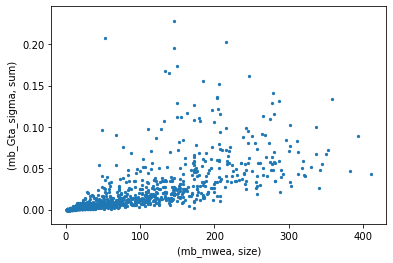

In [69]:
glac_df_mb_hex.plot.scatter(x=('mb_mwea', 'size'),y=('mb_Gta_sigma', 'sum'), **sc_kw) 

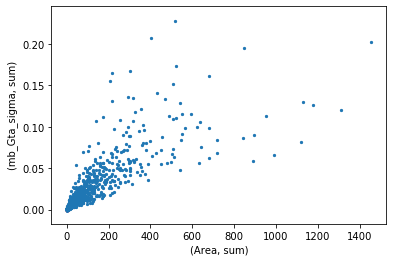

In [70]:
glac_df_mb_hex.plot.scatter(x=('Area', 'sum'),y=('mb_Gta_sigma', 'sum'), **sc_kw) 

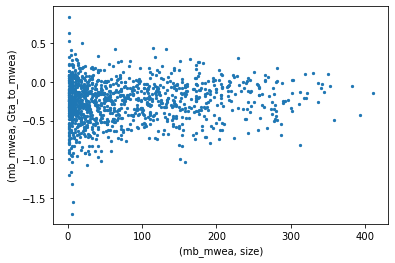

In [71]:
glac_df_mb_hex.plot.scatter(x=('mb_mwea', 'size'),y=('mb_mwea', 'Gta_to_mwea'), **sc_kw) 

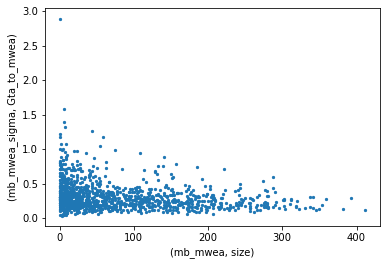

In [72]:
glac_df_mb_hex.plot.scatter(x=('mb_mwea', 'size'),y=('mb_mwea_sigma', 'Gta_to_mwea'), **sc_kw) 

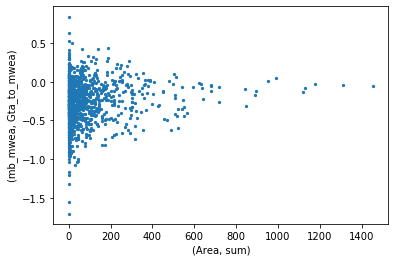

In [73]:
glac_df_mb_hex.plot.scatter(x=('Area','sum'),y=('mb_mwea', 'Gta_to_mwea'), **sc_kw) 

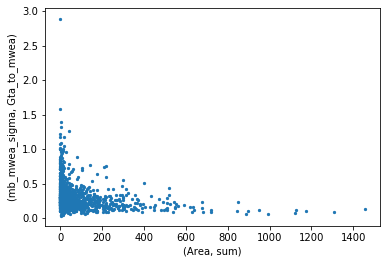

In [74]:
glac_df_mb_hex.plot.scatter(x=('Area','sum'),y=('mb_mwea_sigma', 'Gta_to_mwea'), **sc_kw) 

/Users/dshean/sw/miniconda3/envs/shean_py3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:231: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  "'color' and 'colormap' cannot be used " "simultaneously. Using 'color'"


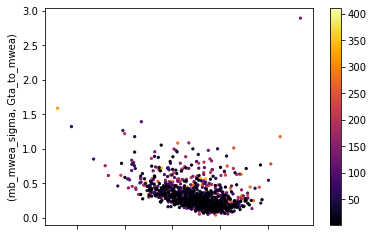

In [75]:
#c = ('Area', 'sum')
c = ('mb_mwea', 'size')
glac_df_mb_hex.sort_values(by=c).plot.scatter(x=('mb_mwea', 'Gta_to_mwea'), y=('mb_mwea_sigma', 'Gta_to_mwea'), color=glac_df_mb_hex[c], cmap='inferno', marker='.')

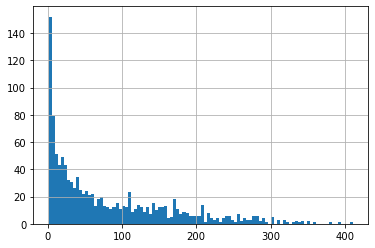

In [76]:
glac_df_mb_hex[('mb_mwea', 'size')].hist(bins=100)

In [137]:
# Count of glaciers in hex bins
print(glac_df_mb_hex[('mb_mwea', 'size')].mean())
print(glac_df_mb_hex[('mb_mwea', 'size')].min())
print(glac_df_mb_hex[('mb_mwea', 'size')].max())

80.95111492281303
1.0
411.0


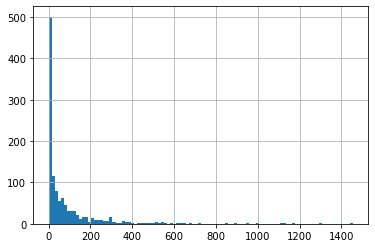

In [78]:
glac_df_mb_hex[('Area', 'sum')].hist(bins=100)

## Check for outliers

In [376]:
def hex_check(glac_df_mb_hex, col=('mb_Gta', 'sum')):
    f,axa = plt.subplots(1,2, figsize=(8,4))
    glac_df_mb_hex[col].hist(ax=axa[0], bins=100)
    axa[0].set_ylim(0,10)
    axa[0].set_xlabel(col)
    axa[0].set_ylabel("Number of hex bins")
    axa[0].axvline(0, color='k')
    axa[1].scatter(glac_df_mb_hex[('mb_mwea', 'count')], glac_df_mb_hex[col])
    axa[1].set_xlabel("Number of glaciers in hex bin")
    axa[1].set_ylabel(col)
    axa[1].axhline(0, color='k')
    plt.tight_layout()

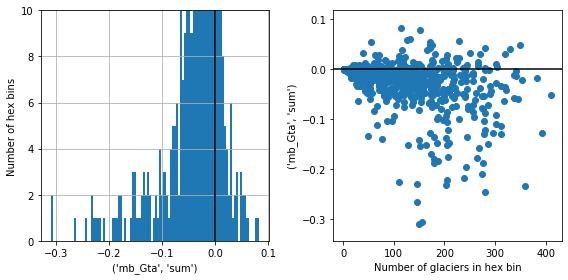

In [377]:
hex_check(glac_df_mb_hex, col=('mb_Gta', 'sum'))

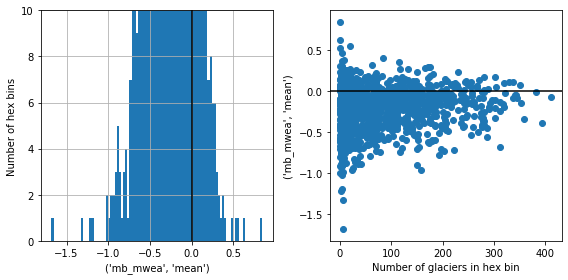

In [378]:
hex_check(glac_df_mb_hex, col=('mb_mwea', 'mean'))

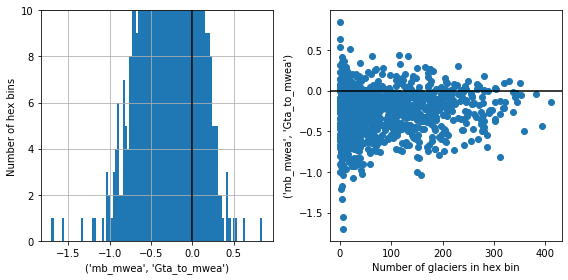

In [379]:
hex_check(glac_df_mb_hex, col=('mb_mwea', 'Gta_to_mwea'))

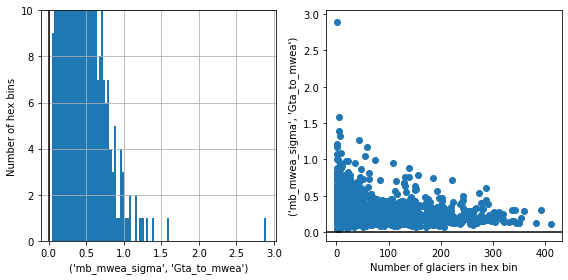

In [380]:
hex_check(glac_df_mb_hex, col=('mb_mwea_sigma', 'Gta_to_mwea'))

In [381]:
if False:
    outlier_clim = (-0.20, 0.08)
    col = ('mb_Gta', 'sum')
    print("Removing outliers (%0.2f, %0.2f)" % (outlier_clim))
    inlier_idx = (glac_df_mb_hex[col] >= outlier_clim[0]) & (glac_df_mb_hex[col] <= outlier_clim[1])

    print("%i records before outlier removal" % (glac_df_mb_hex.shape[0]))
    print("%i records after outlier removal" % (glac_df_mb_hex[inlier_idx].shape[0]))
    glac_df_mb_hex = glac_df_mb_hex[inlier_idx]

## HMA-wide numbers

In [138]:
#Sum of all hex samples - full region mb and uncertainty
hma_stats = glac_df_mb_hex.sum(axis=0)
hma_mb_Gta_sigma_rss = rss(glac_df_mb_hex[('mb_Gta_sigma', 'sum')])
#hma_mb_Gta_sigma_rss = rss(glac_df_mb_hex[('mb_m3wea_sigma', 'sum')])/1E9

In [139]:
#These were incorrect (sum and rss were flipped!)
#print('%0.2f\u00b1%0.2f Gt/yr' % (hma_stats[('mb_Gta', 'sum')], hma_stats[('mb_Gta_sigma', 'rss')]))
#print('%0.1f\u00b1%0.1f Gt/yr' % (hma_stats[('mb_Gta', 'sum')], hma_stats[('mb_Gta_sigma', 'rss')]))

In [257]:
print('%0.2f\u00b1%0.2f Gt/yr' % (hma_stats[('mb_Gta', 'sum')], hma_mb_Gta_sigma_rss))
print('%0.1f\u00b1%0.1f Gt/yr' % (hma_stats[('mb_Gta', 'sum')], hma_mb_Gta_sigma_rss))

-18.96±1.18 Gt/yr
-19.0±1.2 Gt/yr


In [258]:
print('%0.1f%% uncertainty' % (100*abs(hma_mb_Gta_sigma_rss/hma_stats[('mb_Gta', 'sum')])))

6.2% uncertainty


In [259]:
print('%0.3f\u00b1%0.3f mmSLE/yr' % (hma_stats[('mb_Gta', 'sum')]/Gt2mm, hma_mb_Gta_sigma_rss/Gt2mm))

-0.052±0.003 mmSLE/yr


In [260]:
dt = 18.0
print('%0.3f\u00b1%0.3f mmSLE' % (dt*hma_stats[('mb_Gta', 'sum')]/Gt2mm, dt*hma_mb_Gta_sigma_rss/Gt2mm))

-0.942±0.058 mmSLE


In [261]:
print('%0.2f\u00b1%0.2f Gt' % (dt*hma_stats[('mb_Gta', 'sum')], dt*hma_mb_Gta_sigma_rss))

-341.33±21.17 Gt


In [159]:
hma_stats_m = 1000*hma_stats/hma_stats[('Area', 'sum')]
hma_stats_m_rss = 1000*hma_mb_Gta_sigma_rss/hma_stats[('Area', 'sum')]
#print('%0.2f\u00b1%0.2f m we/yr' % (hma_stats_m[('mb_Gta', 'sum')], hma_stats_m[('mb_Gta_sigma', 'rss')]))
print('%0.3f\u00b1%0.3f m we/yr' % (hma_stats_m[('mb_Gta', 'sum')], hma_stats_m_rss))
print('%0.2f\u00b1%0.2f m we/yr' % (hma_stats_m[('mb_Gta', 'sum')], hma_stats_m_rss))
#print('%0.1f\u00b1%0.1f m we/yr' % (hma_stats_m[('mb_Gta', 'sum')], hma_stats_m[('mb_Gta_sigma', 'rss')]))

-0.196±0.012 m we/yr
-0.20±0.01 m we/yr


In [152]:
hma_stats[('meltwater', 'total_Gta_sigma')]

16.441017679646002

In [90]:
glac_df_mb_hex[('mb_Gta_sigma', 'sum')].max()

0.22837367351600013

In [91]:
rss(glac_df_mb_hex[('mb_Gta_sigma', 'sum')])

1.1762138897466257

In [92]:
glac_df_mb_hex[('mb_Gta_sigma', 'sum')].sum()

21.500476323924

In [93]:
rss(glac_df_mb_hex[('meltwater', 'total_Gta')])

1.467725379015717

## Plot hex grids

In [153]:
title = suptitle + ": %s km Hex Grid Cells" % hex_width
extent = [-1610900, -1142400, 1767400, 1145700]

In [154]:
scaling_f = 0.15
cbar_fmt = '%0.2f'

Plotting image
Plotting borders
('mb_mwea', 'size')
Plotting scatterplot of ('mb_mwea', 'size') values


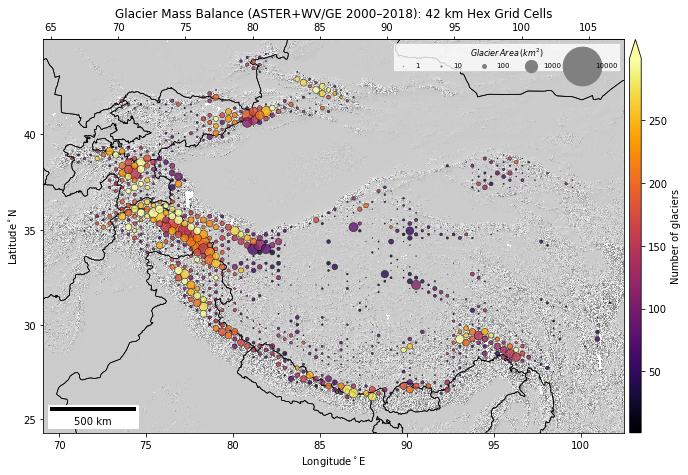

In [155]:
out_fn_suffix = '_hex%s_count' % hex_width
#mb_gt_clim = (-0.15,0.15)
#hex_fig = make_map(col=('mb_Gta', 'sum'), mb_dissolve_df=glac_df_mb_hex, glac_df_mb=None, agg_df=None, border_df=border_df, clim=mb_gt_clim, crs=crs, extent=extent, hs=hs, hs_extent_cartopy=hs_extent_cartopy, labels=None, title=title)
hex_fig = make_map(col=('mb_mwea', 'size'), mb_dissolve_df=glac_df_mb_hex, glac_df_mb=None, agg_df=None, border_df=border_df, clim=None, crs=crs, extent=extent, hs_bg=True, labels=None, title=title, cbar_fmt='%i')
hex_fig_fn = os.path.splitext(glac_shp_join_fn)[0] + out_fn_suffix + '.png'
hex_fig.savefig(hex_fig_fn, **plt_opt)

Plotting image
Plotting borders
('mb_Gta', 'sum')
Plotting scatterplot of ('mb_Gta', 'sum') values
Plotting image
Plotting borders
('mb_Gta_sigma', 'sum')
Plotting scatterplot of ('mb_Gta_sigma', 'sum') values


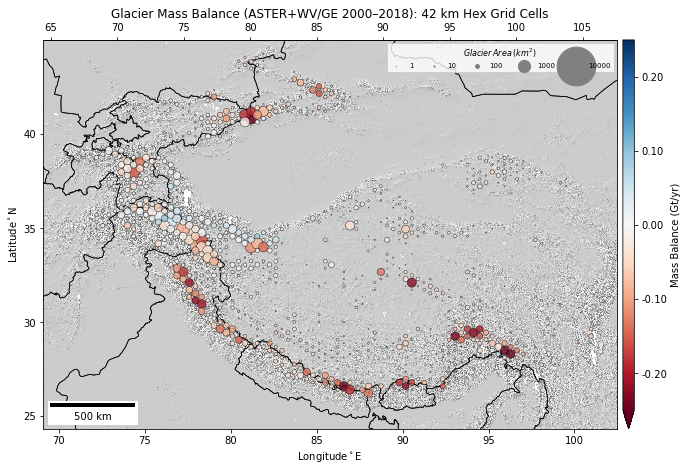

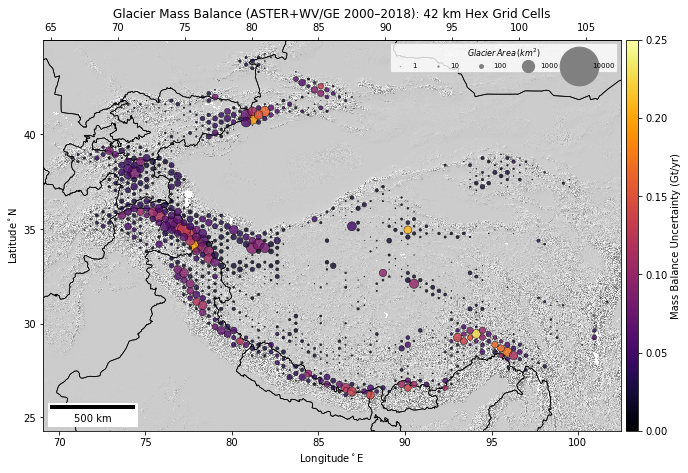

In [158]:
out_fn_suffix = '_hex%s_mb_Gta' % hex_width
#Earlier 27-km hex plots
max_gt = 0.15
max_gt = 0.25
mb_gt_clim = (-max_gt,max_gt)
#hex_fig = make_map(col=('mb_Gta', 'sum'), mb_dissolve_df=glac_df_mb_hex, glac_df_mb=None, agg_df=None, border_df=border_df, clim=mb_gt_clim, crs=crs, extent=extent, hs=hs, hs_extent_cartopy=hs_extent_cartopy, labels=None, title=title)
hex_fig = make_map(col=('mb_Gta', 'sum'), mb_dissolve_df=glac_df_mb_hex, glac_df_mb=None, agg_df=None, border_df=border_df, clim=mb_gt_clim, crs=crs, extent=extent, hs_bg=True, labels=None, title=title, cbar_fmt=cbar_fmt)
hex_fig_fn = os.path.splitext(glac_shp_join_fn)[0] + out_fn_suffix + '.png'
hex_fig.savefig(hex_fig_fn, **plt_opt)
mb_gt_sigma_clim = (0.00,max_gt)
hex_sigma_fig = make_map(col=('mb_Gta_sigma', 'sum'), mb_dissolve_df=glac_df_mb_hex, glac_df_mb=None, agg_df=None, border_df=border_df, clim=mb_gt_sigma_clim, crs=crs, extent=extent, labels=None, title=title, cbar_fmt=cbar_fmt)
hex_sigma_fig_fn = os.path.splitext(glac_shp_join_fn)[0] + out_fn_suffix + '_sigma.png'
hex_sigma_fig.savefig(hex_sigma_fig_fn, **plt_opt)

Plotting image
Plotting borders
('mb_mwea', 'mean')
Plotting scatterplot of ('mb_mwea', 'mean') values
Plotting image
Plotting borders
('mb_mwea_sigma', 'mean')
Plotting scatterplot of ('mb_mwea_sigma', 'mean') values


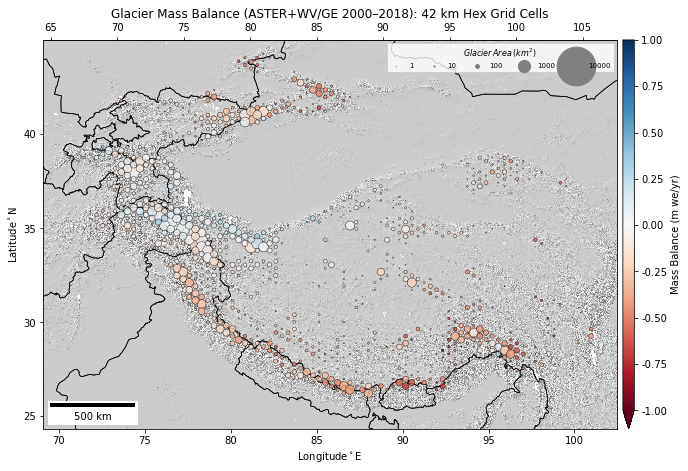

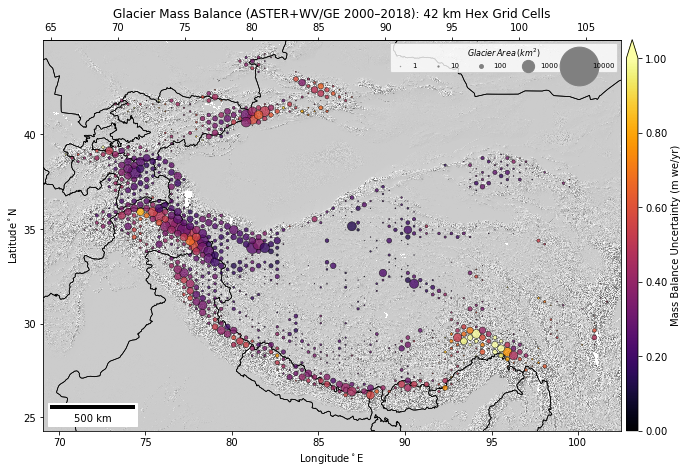

In [397]:
out_fn_suffix = '_hex%s_mb_mwea' % hex_width
mb_mwea_clim = (-1.0,1.0)
hex_fig = make_map(col=('mb_mwea', 'mean'), mb_dissolve_df=glac_df_mb_hex, glac_df_mb=None, agg_df=None, border_df=border_df, clim=mb_mwea_clim, crs=crs, extent=extent, labels=None, title=title, cbar_fmt=cbar_fmt)
hex_fig_fn = os.path.splitext(glac_shp_join_fn)[0] + out_fn_suffix + '.png'
hex_fig.savefig(hex_fig_fn, **plt_opt)
#mb_mwea_sigma_clim = (0,0.5)
mb_mwea_sigma_clim = (0,1.0)
hex_sigma_fig = make_map(col=('mb_mwea_sigma', 'mean'), mb_dissolve_df=glac_df_mb_hex, glac_df_mb=None, agg_df=None, border_df=border_df, clim=mb_mwea_sigma_clim, crs=crs, extent=extent, labels=None, title=title, cbar_fmt=cbar_fmt)
hex_sigma_fig_fn = os.path.splitext(glac_shp_join_fn)[0] + out_fn_suffix + '_sigma.png'
hex_sigma_fig.savefig(hex_sigma_fig_fn, **plt_opt)

Plotting image
Plotting borders
('mb_mwea', 'Gta_to_mwea')
Plotting scatterplot of ('mb_mwea', 'Gta_to_mwea') values
Plotting image
Plotting borders
('mb_mwea_sigma', 'Gta_to_mwea')
Plotting scatterplot of ('mb_mwea_sigma', 'Gta_to_mwea') values


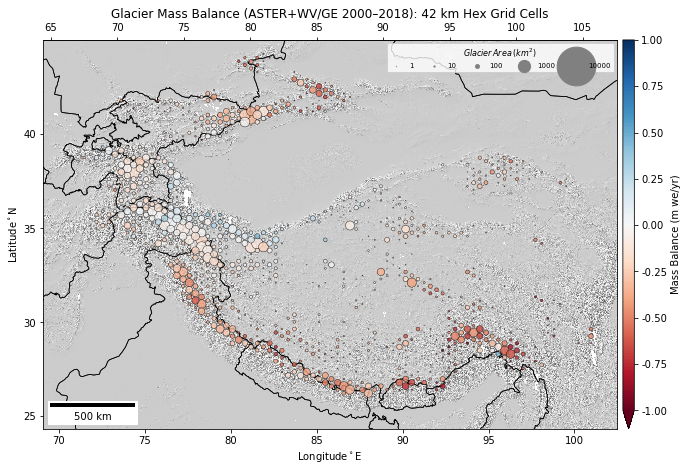

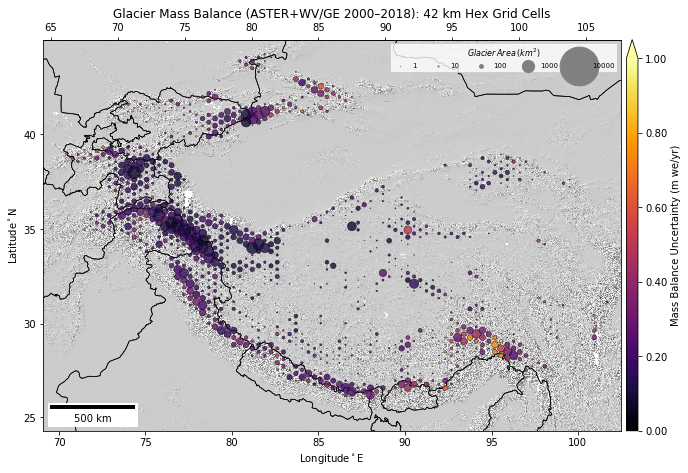

In [398]:
out_fn_suffix = '_hex%s_mb_Gta_to_mwea' % hex_width
mb_mwea_clim = (-1.0,1.0)
hex_fig = make_map(col=('mb_mwea', 'Gta_to_mwea'), mb_dissolve_df=glac_df_mb_hex, glac_df_mb=None, agg_df=None, border_df=border_df, clim=mb_mwea_clim, crs=crs, extent=extent, labels=None, title=title, cbar_fmt=cbar_fmt)
hex_fig_fn = os.path.splitext(glac_shp_join_fn)[0] + out_fn_suffix + '.png'
hex_fig.savefig(hex_fig_fn, **plt_opt)
#mb_mwea_sigma_clim = (0,0.5)
mb_mwea_sigma_clim = (0,1.0)
hex_sigma_fig = make_map(col=('mb_mwea_sigma', 'Gta_to_mwea'), mb_dissolve_df=glac_df_mb_hex, glac_df_mb=None, agg_df=None, border_df=border_df, clim=mb_mwea_sigma_clim, crs=crs, extent=extent, labels=None, title=title, cbar_fmt=cbar_fmt)
hex_sigma_fig_fn = os.path.splitext(glac_shp_join_fn)[0] + out_fn_suffix + '_sigma.png'
hex_sigma_fig.savefig(hex_sigma_fig_fn, **plt_opt)

## Exploring mb vs elevation

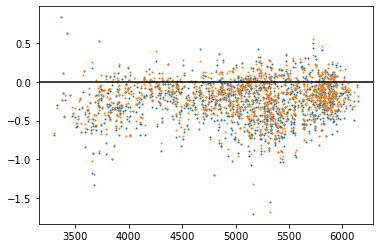

In [160]:
f,ax = plt.subplots()
z=glac_df_mb_hex[('z_med', 'median')]
mb=glac_df_mb_hex[('mb_mwea', 'Gta_to_mwea')]
mb2=glac_df_mb_hex[('mb_mwea', 'mean')]
#mb=glac_df_mb_hex[('mb_Gta', 'sum')]

ax.scatter(z,mb,s=1)
ax.scatter(z,mb2,s=1)
ax.axhline(0,c='k')
#ax.set_ylim(-0.1, 0.05)

In [400]:
def norm(a, percentile=(0.5, 99.5)):
    #amin, amax = (a.min(), a.max())
    amin, amax = np.nanpercentile(a, percentile)
    print(amin, amax)
    return ((a - amin)/(amax - amin))

-1.1001692474314209 0.4509296200242407
3420.4642000000003 6088.114699999999


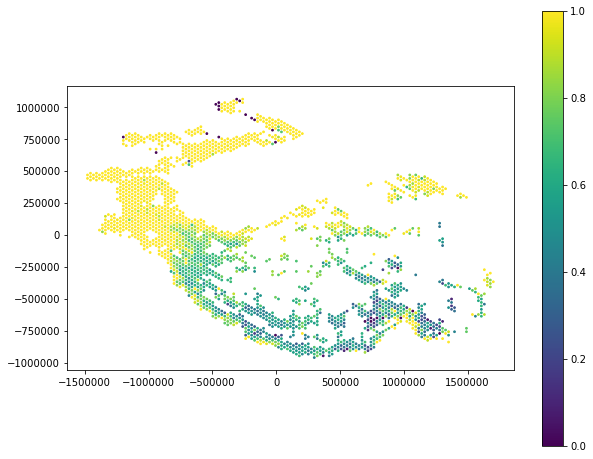

In [255]:
f,ax = plt.subplots(figsize=(10,8))
x=glac_df_mb_hex['centroid_x'].values
y=glac_df_mb_hex['centroid_y'].values
z=glac_df_mb_hex[('z_med', 'median')]
mb=glac_df_mb_hex[('mb_mwea', 'Gta_to_mwea')]
#mb=glac_df_mb_hex[('mb_mwea', 'mean')]
#asdf = norm(mb/z)
asdf = norm(mb)/norm(z)
clim=(0,1)
sc = ax.scatter(x,y,c=asdf,s=3,vmin=clim[0],vmax=clim[1])
plt.colorbar(sc)
ax.set_aspect('equal')

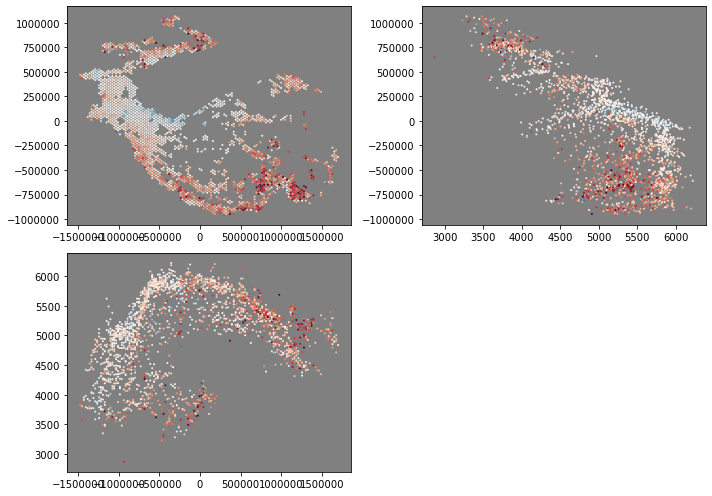

In [256]:
f,axa = plt.subplots(2,2,figsize=(10,7))
clim = (-1,1)
#axa[0][0].set_aspect('equal')
axa[0][0].scatter(x,y,c=mb,s=1,vmin=clim[0],vmax=clim[1],cmap='RdBu')
axa[1][0].scatter(x,z,c=mb,s=1,vmin=clim[0],vmax=clim[1],cmap='RdBu')
axa[0][1].scatter(z,y,c=mb,s=1,vmin=clim[0],vmax=clim[1],cmap='RdBu')
axa[1][1].axis('off')
plt.tight_layout()
for ax in axa.ravel():
    ax.set_facecolor('0.5')

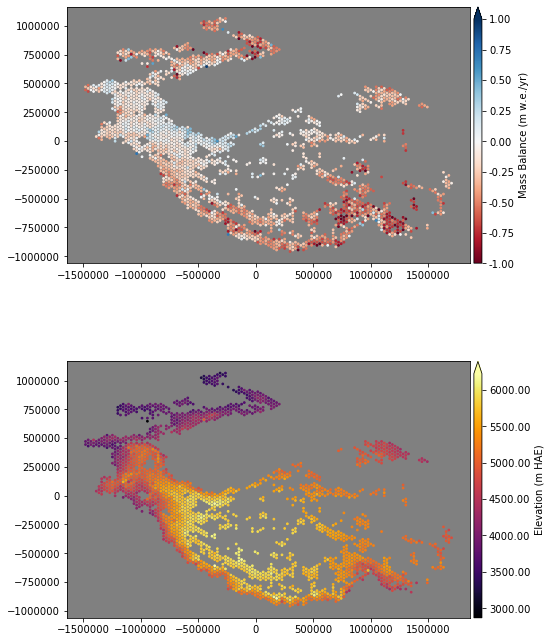

In [257]:
f,axa = plt.subplots(2, figsize=(7.5,10))
clim = (-1,1)
#axa[0][0].set_aspect('equal')
mb_m = axa[0].scatter(x,y,c=mb,s=3,vmin=clim[0],vmax=clim[1],cmap='RdBu')
z_m = axa[1].scatter(x,y,c=z,s=3,cmap='inferno')
pltlib.add_cbar(axa[0], mb_m, label='Mass Balance (m w.e./yr)')
pltlib.add_cbar(axa[1], z_m, label='Elevation (m HAE)')

for ax in axa.ravel():
    ax.set_aspect('equal')
    ax.set_facecolor('0.5')
plt.tight_layout()

## Aggregation of hex cells over regions and basins

In [161]:
def hex_agg(glac_gdf_mb_hex, region_df, region_col):
    print("One-time spatial join by hex")
    glac_gdf_mb_hex_region = gpd.sjoin(glac_gdf_mb_hex, region_df, how="inner", op="within")
    glac_gdf_mb_hex_region.rename(index=str, columns={'index_right':region_col}, inplace=True)
    print(glac_gdf_mb_hex_region.shape)
    
    aggfunc = { ('mb_m3wea_sigma', 'sum'):[np.sum, rss, rms], \
               ('mb_m3wea', 'sum'):[np.sum, np.size], \
               ('z_med', 'median'):[np.mean, np.median], \
              ('Area_all', 'sum'):[np.sum],\
              ('meltwater', 'total_m3a'):[np.sum], \
               ('meltwater', 'total_m3a_sigma'):[np.sum, rss, rms]}
    
    #print(glac_gdf_mb_hex_region.columns)
    
    glac_gdf_mb_hex_region_agg = glac_gdf_mb_hex_region.groupby(region_col).agg(aggfunc)
    
    #Aggregate earlier meltwater aggregation
    glac_gdf_mb_hex_region_agg_melt = glac_gdf_mb_hex_region[glac_gdf_mb_hex_region[('meltwater', 'total_Gta')] < 0].groupby(region_col).agg(aggfunc)
    #Compute a new round of meltwater for hex cells with negative mass balance 
    glac_gdf_mb_hex_region_agg_melt_hex = glac_gdf_mb_hex_region[glac_gdf_mb_hex_region[('mb_m3wea', 'sum')] < 0].groupby(region_col).agg(aggfunc)
    
    glac_gdf_mb_hex_region_agg['centroid_x'] = region_df['centroid_x']
    glac_gdf_mb_hex_region_agg['centroid_y'] = region_df['centroid_y']
    #glac_gdf_mb_hex_region_agg['Area_all'] = glac_gdf_mb_hex_region_agg[('Area_all', 'sum', 'sum')]
    #glac_gdf_mb_hex_region_agg['Area_all'] = glac_df_mb_region[('Area_all', 'sum')
    glac_gdf_mb_hex_region_agg[('mb_Gta','sum','sum')] = glac_gdf_mb_hex_region_agg[('mb_m3wea','sum','sum')]/1E9
    glac_gdf_mb_hex_region_agg[('mb_Gta_sigma','sum','rss')] = glac_gdf_mb_hex_region_agg[('mb_m3wea_sigma','sum','rss')]/1E9
    glac_gdf_mb_hex_region_agg[('mb_mwea','sum','sum')] = glac_gdf_mb_hex_region_agg[('mb_m3wea','sum','sum')]/1E6/glac_gdf_mb_hex_region_agg[('Area_all', 'sum', 'sum')]
    glac_gdf_mb_hex_region_agg[('mb_mwea_sigma','sum','rss')] = glac_gdf_mb_hex_region_agg[('mb_m3wea_sigma','sum','rss')]/1E6/glac_gdf_mb_hex_region_agg[('Area_all', 'sum', 'sum')]
    
    glac_gdf_mb_hex_region_agg[('meltwater_Gta','sum','sum')] = glac_gdf_mb_hex_region_agg_melt[('meltwater','total_m3a','sum')]/1E9
    glac_gdf_mb_hex_region_agg[('meltwater_Gta_sigma','sum','rss')] = glac_gdf_mb_hex_region_agg_melt[('meltwater','total_m3a_sigma','rss')]/1E9
    glac_gdf_mb_hex_region_agg[('meltwater_Gta_sigma','sum','sum')] = glac_gdf_mb_hex_region_agg_melt[('meltwater','total_m3a_sigma','sum')]/1E9
    glac_gdf_mb_hex_region_agg[('meltwater_Gta_hex','sum','sum')] = glac_gdf_mb_hex_region_agg_melt_hex[('mb_m3wea', 'sum','sum')]/1E9
    glac_gdf_mb_hex_region_agg[('meltwater_Gta_hex_sigma','sum','rss')] = glac_gdf_mb_hex_region_agg_melt_hex[('mb_m3wea_sigma', 'sum','rss')]/1E9
    glac_gdf_mb_hex_region_agg[('meltwater_Gta_hex_sigma','sum','sum')] = glac_gdf_mb_hex_region_agg_melt_hex[('mb_m3wea_sigma', 'sum','sum')]/1E9
    
    if 'ENDO' in region_df:
        glac_gdf_mb_hex_region_agg['ENDO'] = region_df['ENDO']
    
    #glac_gdf_mb_hex_region_agg.sort_values(by=('Area_all', 'sum', 'sum'), ascending=False, inplace=True)
    glac_gdf_mb_hex_region_agg.sort_values(by='centroid_x', ascending=True, inplace=True)
    
    return glac_gdf_mb_hex_region_agg

In [162]:
#Fix incorrect spellings in Kaab regions
kaab_region_df.rename({'Nyainqentangla':'Nyainqentanglha', 'Pamir Alai':'Pamir Alay'}, inplace=True)

In [182]:
mb_unit = 'Gta'
region_clim = (-3.5, 3.5)
ylim = (-4.5, 1.5)
col=('mb_Gta', 'sum', 'sum')
sigma_col=('mb_Gta_sigma', 'sum', 'rss')

In [164]:
mb_unit = 'mwea'
region_clim = (-0.5, 0.5)
ylim = (-0.70, 0.15)
col=('mb_mwea', 'sum', 'sum')
sigma_col=('mb_mwea_sigma', 'sum', 'rss')

In [165]:
def hex_agg_plot(glac_gdf_mb_hex_region_agg, region_df, title, out_fn_suffix, clim=None, \
                col=col, sigma_col=sigma_col, map=True, hs_bg=True, savefig=True, glac=False):
    
    fig, ax = plt.subplots(figsize=(6,6))
    
    y_label = 'Mass Balance (Gt/yr)'
    if 'mb_mwea' in col:
        y_label = 'Mass Balance (m we/yr)'
    elif 'meltwater' in col[0]:
        y_label = 'Excess Meltwater (Gt/yr)'
       
    #Add Brun et al. bars if present
    if 'new_mb_mwea' in glac_gdf_mb_hex_region_agg:
        if 'mb_mwea' in col:
            col_idx = [col,'new_mb_mwea']
            sigma_col_idx = [sigma_col,'new_mb_err_mwea']
        else:
            col_idx = [col,'new_mb_gta']
            sigma_col_idx = [sigma_col,'new_mb_err_gta']
        color=['darkorange','0.8']
    elif 'brun_mb_gta' in glac_gdf_mb_hex_region_agg:
        if 'meltwater' in col[0]:
            col_idx = [col,'brun_excess_gta']
            sigma_col_idx = [sigma_col,'brun_excess_err_gta']
        else:
            col_idx = [col,'brun_mb_gta']
            sigma_col_idx = [sigma_col,'brun_mb_err_gta']
        color=['darkorange','0.8']
    else:
        col_idx = col
        sigma_col_idx = sigma_col
        color='darkorange'
    
    mb_tot = glac_gdf_mb_hex_region_agg[col_idx]
    err = glac_gdf_mb_hex_region_agg[sigma_col_idx]
    
    #if 'orig_mb_mwea' in glac_gdf_mb_hex_region_agg:
    if len(col_idx) == 2:
        colnames=["This Study", "Brun et al. (2017)"]
        mb_tot.columns = colnames
        err.columns = colnames
    
    width = 1.3*(glac_gdf_mb_hex_region_agg[('Area_all', 'sum', 'sum')]/glac_gdf_mb_hex_region_agg[('Area_all', 'sum', 'sum')].max()).values
    
    print(width)
    
    #mb_tot.plot.bar(ax=ax, color=color)
    mb_tot.plot.bar(yerr=err, ax=ax, color=color, edgecolor='k', linewidth=0.5, \
                    error_kw=dict(ecolor='k', lw=0.5, capsize=2.0, capthick=0.5))
    ax.axhline(0, color='k', lw=0.5)
    ax.set_ylabel(y_label)
    ax.set_ylim(*ylim)
    ax.set_xlabel(mb_tot.index.name)
    ax.grid(axis='y', lw=0.5, ls=':')
 
    plt.tight_layout()
    if savefig:
        fig_fn = os.path.splitext(glac_shp_join_fn)[0]+ out_fn_suffix + '_bar.png'
        fig.savefig(fig_fn, **plt_opt) 
    #return mb_tot, err
    if map:
        hex_region_fig_fn = os.path.splitext(glac_shp_join_fn)[0] + out_fn_suffix + '.png'
        hex_region_fig = make_map(col=col, sigma_col=sigma_col, \
                                  mb_dissolve_df=glac_gdf_mb_hex_region_agg, glac_df_mb=glac_df_mb, \
                                  agg_df=region_df, border_df=border_df, clim=clim, crs=crs, \
                                  extent=extent, labels='name+val+sigma', title=title, hs_bg=hs_bg, glac=glac)
        if savefig:
            hex_region_fig.savefig(hex_region_fig_fn, **plt_opt) 

In [166]:
append_centroid_xy(region_df)
append_centroid_xy(kaab_region_df)
append_centroid_xy(basin_df)

In [167]:
def short_lbl(df):
    orig_index_name = df.index.name
    df[orig_index_name+'_orig'] = df.index
    regex_dict = {'Eastern':'E.','East':'E.','Western':'W.','West':'W.',\
                  'Northern':'N.','Southern':'S.','Central':'C.','Mountains':'Mtns',\
                  'Tibetan Plateau':'TP', 'Extended':'Ext.'}
    new_index = df[orig_index_name+'_orig'].replace(regex=regex_dict)
    df.index = new_index
    df.index.name = orig_index_name

In [168]:
region_df.head()
region_df_cp = region_df.copy()
short_lbl(region_df)
region_df.head()

geometry  \
himap_region                                                       
E. Hindu Kush  (POLYGON ((-1007072.451620904 169859.103980618...   
W. Himalaya    (POLYGON ((-821513.7920037253 -39192.895313012...   
E. Himalaya    (POLYGON ((974925.0577844162 -645901.231420908...   
C. Himalaya    (POLYGON ((-384112.099573634 -588849.806896036...   
Karakoram      (POLYGON ((-793139.7461575471 184761.164018728...   

                 centroid_x  centroid_y   himap_region_orig  
himap_region                                                 
E. Hindu Kush -1,203,427.33   52,490.72  Eastern Hindu Kush  
W. Himalaya     -794,613.29 -266,517.78    Western Himalaya  
E. Himalaya      646,584.48 -866,752.59    Eastern Himalaya  
C. Himalaya     -151,474.46 -782,787.79    Central Himalaya  
Karakoram       -781,483.71   19,769.49           Karakoram

In [169]:
kaab_region_df.head()
kaab_region_df_cp = kaab_region_df.copy()
short_lbl(kaab_region_df)
kaab_region_df.head()

geometry  \
kaab_region                                                          
Inner TP         (POLYGON ((-4401.725805810875 124890.025851544...   
Kunlun           (POLYGON ((-1002287.270993384 465136.935820820...   
Pamir Alay       (POLYGON ((-1247293.932661358 322182.736021329...   
Nyainqentanglha  (POLYGON ((693944.8486240985 -732894.492323651...   
C. Himalaya      (POLYGON ((-137023.4274918161 -852014.06355443...   

                   centroid_x  centroid_y  kaab_region_orig  
kaab_region                                                  
Inner TP           659,777.94 -187,764.02          Inner TP  
Kunlun            -526,188.79  106,040.12            Kunlun  
Pamir Alay      -1,262,182.12  466,842.59        Pamir Alay  
Nyainqentanglha    966,755.14 -658,278.05   Nyainqentanglha  
C. Himalaya        170,838.01 -850,516.83  Central Himalaya

In [170]:
#Revert
#region_df = region_df_cp
#region_df.set_index('himap_region', inplace=True)
region_df.head()

geometry  \
himap_region                                                       
E. Hindu Kush  (POLYGON ((-1007072.451620904 169859.103980618...   
W. Himalaya    (POLYGON ((-821513.7920037253 -39192.895313012...   
E. Himalaya    (POLYGON ((974925.0577844162 -645901.231420908...   
C. Himalaya    (POLYGON ((-384112.099573634 -588849.806896036...   
Karakoram      (POLYGON ((-793139.7461575471 184761.164018728...   

                 centroid_x  centroid_y   himap_region_orig  
himap_region                                                 
E. Hindu Kush -1,203,427.33   52,490.72  Eastern Hindu Kush  
W. Himalaya     -794,613.29 -266,517.78    Western Himalaya  
E. Himalaya      646,584.48 -866,752.59    Eastern Himalaya  
C. Himalaya     -151,474.46 -782,787.79    Central Himalaya  
Karakoram       -781,483.71   19,769.49           Karakoram

## HiMAP regions

In [171]:
extent = [-1610900, -1142400, 1767400, 1145700]
title = suptitle + ": HiMAP Regions"
glac_gdf_mb_hex_region_agg = hex_agg(glac_gdf_mb_hex, region_df, region_col)

One-time spatial join by hex


/Users/dshean/sw/miniconda3/envs/shean_py3/lib/python3.7/site-packages/geopandas/tools/sjoin.py:56: UserWarning: CRS of frames being joined does not match!(None != {'proj': 'aea', 'lat_1': 25, 'lat_2': 47, 'lat_0': 36, 'lon_0': 85, 'x_0': 0, 'y_0': 0, 'datum': 'WGS84', 'units': 'm', 'no_defs': True})
  '(%s != %s)' % (left_df.crs, right_df.crs))


(1166, 66)


In [172]:
region_df.shape

(22, 4)

In [173]:
glac_gdf_mb_hex_region_agg.head()

mb_m3wea_sigma                                       mb_m3wea  \
                           sum                                            sum   
                           sum            rss           rms               sum   
himap_region                                                                    
Pamir Alay      534,786,534.27 143,461,631.95 24,249,441.73    -64,518,060.93   
E. Hindu Kush   653,263,239.86 160,112,798.58 24,137,912.59   -314,675,566.15   
W. Pamir      1,327,302,585.00 224,579,834.49 29,237,804.08   -932,235,604.54   
E. Pamir        300,258,545.62  89,928,555.69 19,172,832.49     59,796,726.90   
W. Himalaya   1,868,064,190.31 321,350,283.29 35,272,776.04 -2,496,003,077.35   

                       z_med          Area_all         meltwater  \
                      median               sum         total_m3a   
               size     mean   median      sum               sum   
himap_region                                                       
Pamir Alay    35.00 4,033.68 4,016.05 1,875.35   -206,073,303.15   
E. Hindu Kush 44.00 4,657.20 4,632.46 2,783.00   -417,666,162.36   
W. Pamir      59.00 4,743.17 4,903.91 8,608.99 -1,139,550,359.36   
E. Pamir      22.00 4,960.84 4,997.72 2,186.88   -128,368,094.91   
W. Himalaya   83.00 5,106.71 5,205.88 7,888.32 -2,612,728,141.27   

                                                               centroid_x  \
               total_m3a_sigma                                              
                           sum            rss           rms                 
himap_region                                                                
Pamir Alay      284,116,407.79  81,176,942.32 13,921,730.75 -1,244,513.89   
E. Hindu Kush   446,070,724.99 109,267,614.18 16,860,358.91 -1,203,427.33   
W. Pamir        938,880,596.54 169,459,863.55 22,251,170.20 -1,091,984.74   
E. Pamir        117,394,852.73  35,001,213.63  7,637,890.99   -837,265.31   
W. Himalaya   1,613,050,420.42 290,711,920.06 32,301,324.45   -794,613.29   

               centroid_y mb_Gta mb_Gta_sigma mb_mwea mb_mwea_sigma  \
                             sum          sum     sum           sum   
                             sum          rss     sum           rss   
himap_region                                                          
Pamir Alay     484,331.70  -0.06         0.14   -0.03          0.08   
E. Hindu Kush   52,490.72  -0.31         0.16   -0.11          0.06   
W. Pamir       309,369.96  -0.93         0.22   -0.11          0.03   
E. Pamir       322,658.14   0.06         0.09    0.03          0.04   
W. Himalaya   -266,517.78  -2.50         0.32   -0.32          0.04   

              meltwater_Gta meltwater_Gta_sigma      meltwater_Gta_hex  \
                        sum                 sum                    sum   
                        sum                 rss  sum               sum   
himap_region                                                             
Pamir Alay            -0.21                0.08 0.28             -0.13   
E. Hindu Kush         -0.42                0.11 0.45             -0.35   
W. Pamir              -1.14                0.17 0.94             -0.94   
E. Pamir              -0.13                0.04 0.12             -0.06   
W. Himalaya           -2.61                0.29 1.61             -2.50   

              meltwater_Gta_hex_sigma       
                                  sum       
                                  rss  sum  
himap_region                                
Pamir Alay                       0.09 0.27  
E. Hindu Kush                    0.14 0.53  
W. Pamir                         0.22 1.26  
E. Pamir                         0.04 0.09  
W. Himalaya                      0.32 1.84

[0.11433361 0.16967004 0.524862   0.13332705 0.48092506 0.1366601
 1.3        0.52852494 0.44454111 0.03175615 0.54957455 0.08142908
 0.21784824 0.12586838 0.01662532 0.18396459 0.15874639 0.11219038
 0.4266578  0.0188253  0.09739986 0.07810603]
Plotting image
Plotting borders
('mb_mwea', 'sum', 'sum')
Plotting scatterplot of ('mb_mwea', 'sum', 'sum') values
Adding annotations


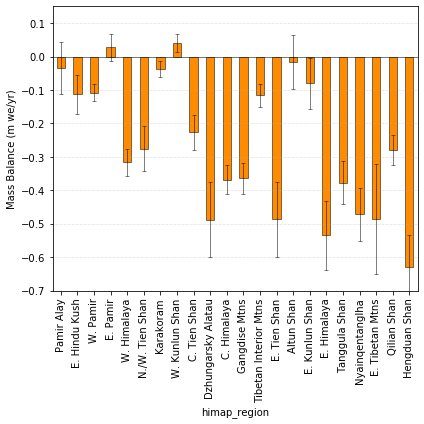

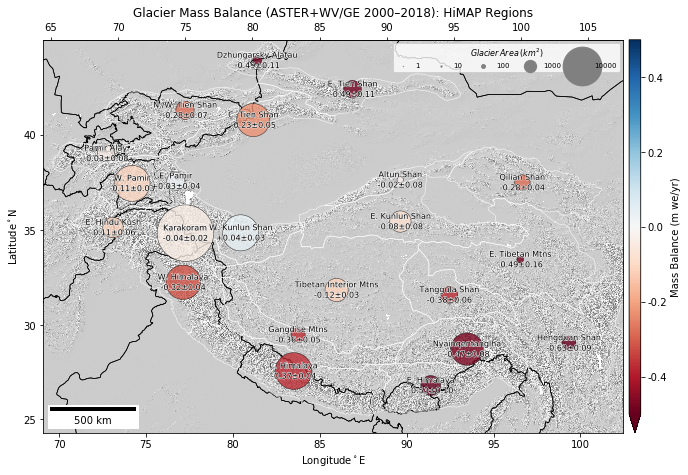

In [469]:
hex_agg_plot(glac_gdf_mb_hex_region_agg, region_df, title, col=col, sigma_col=sigma_col, \
             out_fn_suffix='_hex%s_himap_region_%s' % (hex_width, mb_unit), clim=region_clim)

In [109]:
#Number of cells per region
glac_gdf_mb_hex_region_agg['mb_m3wea','sum','size'].describe()

count   22.00
mean    53.00
std     24.65
min      7.00
25%     38.75
50%     53.00
75%     71.50
max     95.00
Name: (mb_m3wea, sum, size), dtype: float64

In [110]:
agg_sum = glac_gdf_mb_hex_region_agg[('mb_Gta','sum','sum')].sum()
agg_sigma_sum = glac_gdf_mb_hex_region_agg[('mb_Gta_sigma','sum','rss')].sum()
agg_sigma_rss = rss(glac_gdf_mb_hex_region_agg[('mb_Gta_sigma','sum','rss')])
print('%0.2f\u00b1%0.2f Gt/yr' % (agg_sum, agg_sigma_sum))
print('%0.2f\u00b1%0.2f Gt/yr' % (agg_sum, agg_sigma_rss))

-18.96±4.51 Gt/yr
-18.96±1.18 Gt/yr


In [472]:
glac_gdf_mb_hex_region_agg

mb_m3wea_sigma                               \
                                   sum                                
                                   sum            rss           rms   
himap_region                                                          
Pamir Alay              534,786,534.27 143,461,631.95 24,249,441.73   
E. Hindu Kush           653,263,239.86 160,112,798.58 24,137,912.59   
W. Pamir              1,327,302,585.00 224,579,834.49 29,237,804.08   
E. Pamir                300,258,545.62  89,928,555.69 19,172,832.49   
W. Himalaya           1,868,064,190.31 321,350,283.29 35,272,776.04   
N./W. Tien Shan         720,605,395.92 150,365,888.37 18,370,117.03   
Karakoram             3,059,253,145.85 507,177,577.13 69,018,126.27   
W. Kunlun Shan        1,260,342,177.55 239,843,054.02 31,492,935.87   
C. Tien Shan          1,744,895,536.78 380,888,699.96 53,335,086.08   
Dzhungarsky Alatau      162,305,573.85  58,522,269.22 15,640,734.35   
C. Himalaya           2,328,544,927.33 385,482,223.84 41,328,032.41   
Gangdise Mtns           323,215,824.55  63,083,904.00  7,383,412.49   
Tibetan Interior Mtns   525,475,279.44 119,351,888.84 12,245,245.42   
E. Tien Shan            798,700,560.59 231,702,935.52 38,091,727.95   
Altun Shan               42,493,618.08  21,963,461.25  8,301,408.06   
E. Kunlun Shan          649,044,660.84 228,724,628.66 25,572,190.89   
E. Himalaya           1,004,172,026.08 269,704,610.24 39,340,460.68   
Tanggula Shan           359,782,697.89 116,683,337.26 17,394,124.93   
Nyainqentanglha       2,918,544,878.51 554,951,247.45 61,661,249.72   
E. Tibetan Mtns         111,781,126.64  50,613,262.70 12,653,315.67   
Qilian Shan             328,037,532.47  71,528,327.17  9,919,194.28   
Hengduan Shan           479,606,266.46 119,577,193.61 15,567,624.61   

                               mb_m3wea          z_med           Area_all  \
                                    sum         median                sum   
                                    sum  size     mean   median       sum   
himap_region                                                                
Pamir Alay               -64,518,060.93 35.00 4,033.68 4,016.05  1,875.35   
E. Hindu Kush           -314,675,566.15 44.00 4,657.20 4,632.46  2,783.00   
W. Pamir                -932,235,604.54 59.00 4,743.17 4,903.91  8,608.99   
E. Pamir                  59,796,726.90 22.00 4,960.84 4,997.72  2,186.88   
W. Himalaya           -2,496,003,077.35 83.00 5,106.71 5,205.88  7,888.32   
N./W. Tien Shan         -616,713,014.55 67.00 3,828.22 3,813.41  2,241.55   
Karakoram               -785,546,262.06 54.00 5,372.02 5,383.76 21,323.11   
W. Kunlun Shan           353,064,932.02 58.00 5,622.89 5,718.38  8,669.07   
C. Tien Shan          -1,648,863,139.57 51.00 4,107.10 4,141.57  7,291.54   
Dzhungarsky Alatau      -254,001,748.25 14.00 3,542.07 3,524.58    520.88   
C. Himalaya           -3,322,671,448.26 87.00 5,495.99 5,540.63  9,014.34   
Gangdise Mtns           -486,604,909.90 73.00 5,854.97 5,852.50  1,335.63   
Tibetan Interior Mtns   -416,356,357.42 95.00 5,831.00 5,841.32  3,573.23   
E. Tien Shan          -1,005,155,118.99 37.00 3,821.10 3,872.69  2,064.54   
Altun Shan                -4,469,314.68  7.00 5,090.54 5,103.21    272.70   
E. Kunlun Shan          -241,182,573.29 80.00 5,298.98 5,288.41  3,017.46   
E. Himalaya           -1,391,365,342.74 47.00 5,351.00 5,353.34  2,603.82   
Tanggula Shan           -693,887,266.52 45.00 5,457.28 5,447.13  1,840.19   
Nyainqentanglha       -3,300,300,304.02 81.00 5,223.66 5,333.49  6,998.21   
E. Tibetan Mtns         -150,191,838.06 16.00 5,250.37 5,280.75    308.78   
Qilian Shan             -446,107,541.16 52.00 4,738.45 4,730.28  1,597.59   
Hengduan Shan           -804,827,099.03 59.00 5,054.38 5,100.84  1,281.13   

                              meltwater                                  \
                              total_m3a  total_m3a_sigma                  
                        

## Kaab et al regions

In [174]:
extent = [-1610900, -1142400, 1767400, 1145700]
title = suptitle + ": Kääb et al. (2015) Regions"
glac_gdf_mb_hex_region_agg = hex_agg(glac_gdf_mb_hex, kaab_region_df, kaab_region_col)

One-time spatial join by hex
(1156, 66)


In [175]:
#Number of cells per region
glac_gdf_mb_hex_region_agg['mb_m3wea','sum','size'].describe()

count    12.00
mean     96.33
std     114.26
min      39.00
25%      47.25
50%      53.50
75%      75.00
max     442.00
Name: (mb_m3wea, sum, size), dtype: float64

[0.12937263 0.37268201 0.47599459 1.3        0.51223819 0.67645939
 0.80259484 0.30981259 0.3292694  0.93150959 0.15656548 0.45894458]
Plotting image
Plotting borders
('mb_mwea', 'sum', 'sum')
Plotting scatterplot of ('mb_mwea', 'sum', 'sum') values
Adding annotations


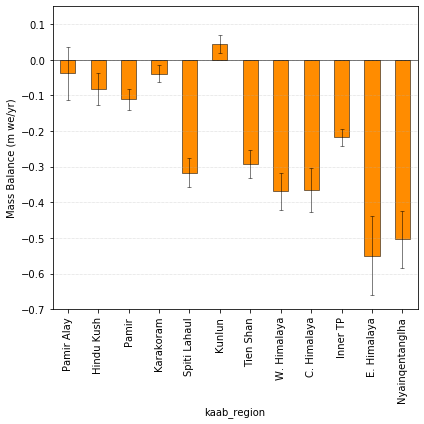

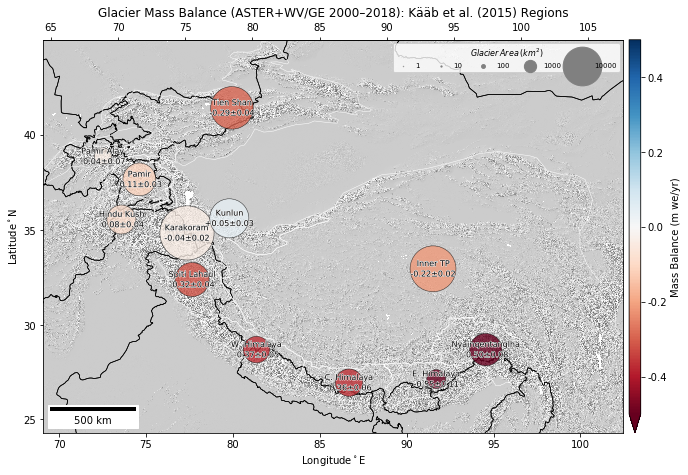

In [474]:
hex_agg_plot(glac_gdf_mb_hex_region_agg, kaab_region_df, title, col=col, sigma_col=sigma_col, \
             out_fn_suffix='_hex%s_kaab_region_%s' % (hex_width, mb_unit), clim=region_clim)

## Combine with Brun estimates for Kaab regions

In [475]:
# Load Brun et al. (2017) numbers for Kaab et al (2015) regions
brun_fn = os.path.join(topdir, 'brun_update.csv')
brun_df = pd.read_csv(brun_fn)
brun_df.set_index('region', inplace=True)
brun_df

orig_mb_mwea  orig_mb_err_mwea  orig_mb_gta  \
region                                                          
East Himalaya            -0.42              0.33        -1.00   
Central Himalaya         -0.33              0.32        -1.60   
Hindu Kush               -0.12              0.14        -0.60   
Inner TP                 -0.14              0.14        -1.80   
Karakoram                -0.03              0.14        -0.50   
Kunlun                    0.14              0.14         1.40   
Nyainqentanglha          -0.62              0.35        -4.00   
Pamir Alay               -0.04              0.14        -0.10   
Pamir                    -0.08              0.14        -0.60   
Spiti Lahaul             -0.37              0.15        -2.90   
Tien Shan                -0.28              0.32        -3.00   
West Himalaya            -0.34              0.15        -1.60   

                  orig_mb_err_gta  new_mb_mwea  new_mb_err_mwea  new_mb_gta  \
region                                                                        
East Himalaya                0.80        -0.42             0.20       -1.00   
Central Himalaya             1.50        -0.33             0.20       -1.60   
Hindu Kush                   0.70        -0.12             0.07       -0.60   
Inner TP                     1.80        -0.14             0.07       -1.80   
Karakoram                    2.50        -0.03             0.07       -0.50   
Kunlun                       1.40         0.14             0.08        1.40   
Nyainqentanglha              2.20        -0.62             0.23       -4.00   
Pamir Alay                   0.30        -0.04             0.07       -0.10   
Pamir                        1.00        -0.08             0.07       -0.60   
Spiti Lahaul                 1.20        -0.37             0.09       -2.90   
Tien Shan                    3.50        -0.28             0.20       -3.00   
West Himalaya                0.70        -0.34             0.09       -1.60   

                  new_mb_err_gta  
region                            
East Himalaya               0.50  
Central Himalaya            1.00  
Hindu Kush                  0.40  
Inner TP                    0.90  
Karakoram                   1.20  
Kunlun                      0.80  
Nyainqentanglha             1.50  
Pamir Alay                  0.10  
Pamir                       0.50  
Spiti Lahaul                0.70  
Tien Shan                   2.20  
West Himalaya               0.40

In [476]:
brun_df.head()
brun_df_cp = brun_df.copy()
short_lbl(brun_df)
brun_df.head()

orig_mb_mwea  orig_mb_err_mwea  orig_mb_gta  orig_mb_err_gta  \
region                                                                      
E. Himalaya         -0.42              0.33        -1.00             0.80   
C. Himalaya         -0.33              0.32        -1.60             1.50   
Hindu Kush          -0.12              0.14        -0.60             0.70   
Inner TP            -0.14              0.14        -1.80             1.80   
Karakoram           -0.03              0.14        -0.50             2.50   

             new_mb_mwea  new_mb_err_mwea  new_mb_gta  new_mb_err_gta  \
region                                                                  
E. Himalaya        -0.42             0.20       -1.00            0.50   
C. Himalaya        -0.33             0.20       -1.60            1.00   
Hindu Kush         -0.12             0.07       -0.60            0.40   
Inner TP           -0.14             0.07       -1.80            0.90   
Karakoram          -0.03             0.07       -0.50            1.20   

                  region_orig  
region                         
E. Himalaya     East Himalaya  
C. Himalaya  Central Himalaya  
Hindu Kush         Hindu Kush  
Inner TP             Inner TP  
Karakoram           Karakoram

In [477]:
# Merge with Brun
glac_gdf_mb_hex_region_agg_brun = glac_gdf_mb_hex_region_agg.merge(brun_df, left_index=True, right_index=True)

In [478]:
glac_gdf_mb_hex_region_agg_brun.index.name = 'kaab_region'

[0.12937263 0.37268201 0.47599459 1.3        0.51223819 0.67645939
 0.80259484 0.30981259 0.3292694  0.93150959 0.15656548 0.45894458]


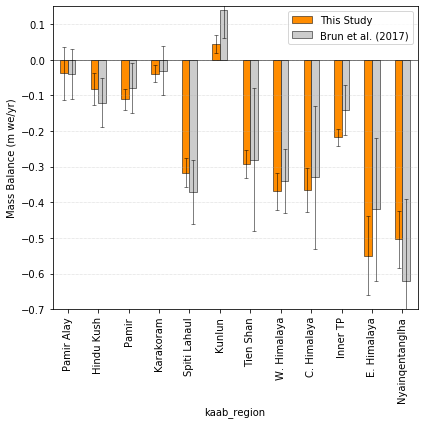

In [479]:
hex_agg_plot(glac_gdf_mb_hex_region_agg_brun, kaab_region_df, title, col=col,sigma_col=sigma_col, \
             out_fn_suffix='_hex%s_kaab_region_brun_%s' % (hex_width, mb_unit), clim=region_clim, map=False)

In [480]:
agg_sum = glac_gdf_mb_hex_region_agg[('mb_Gta','sum','sum')].sum()
agg_sigma_sum = glac_gdf_mb_hex_region_agg[('mb_Gta_sigma','sum','rss')].sum()
agg_sigma_rss = rss(glac_gdf_mb_hex_region_agg[('mb_Gta_sigma','sum','rss')])
print('%0.2f\u00b1%0.2f Gt/yr' % (agg_sum, agg_sigma_sum))
print('%0.2f\u00b1%0.2f Gt/yr' % (agg_sum, agg_sigma_rss))

-18.96±3.82 Gt/yr
-18.96±1.18 Gt/yr


## Basin aggregation and excess meltwater

In [176]:
basin_df.index = basin_df.index.str.replace('_',' ')
basin_df.rename({'Irrawady':'Irrawaddy'}, inplace=True)

In [177]:
#Irrawady centroid is not actually in basin due to curvature
basin_df.at['Irrawaddy', 'centroid_x'] += 250000
basin_df.at['Irrawaddy', 'centroid_y'] -= 300000

In [178]:
basin_df

DN  ENDO  \
basin_name                                    
Irrawaddy                          51     0   
Salween                            68     0   
Ganges                             21     0   
Mekong                             29     0   
Tarim                            3546     1   
Amu Darya                        1270     1   
Indus                            5367     0   
Ili                              5073     1   
Syr Darya                        7195     1   
Yangtze                            11     0   
Inner Tibetan Plateau            8018     1   
Brahmaputra                        21     0   
Inner Tibetan Plateau Extended  26369     1   
Yellow                             27     0   

                                                                         geometry  \
basin_name                                                                          
Irrawaddy                       (POLYGON ((1224583.943096086 -732191.808398038...   
Salween                         (POLYGON ((672169.7126029407 -336521.677728236...   
Ganges                          (POLYGON ((-665049.6944216116 -495091.74933694...   
Mekong                          (POLYGON ((854358.4188662369 -207992.492380907...   
Tarim                           (POLYGON ((345884.0639544324 617350.1410054772...   
Amu Darya                       (POLYGON ((-2094846.421080804 1476189.78996319...   
Indus                           (POLYGON ((-1641980.304020386 -430007.62272057...   
Ili                             (POLYGON ((450350.5195374562 667594.5286882111...   
Syr Darya                       (POLYGON ((-1086009.053956824 477540.657353113...   
Yangtze                         (POLYGON ((771138.0908822966 11206.88876380805...   
Inner Tibetan Plateau           (POLYGON ((-468977.7175471765 -157170.40119378...   
Brahmaputra                     (POLYGON ((619033.9645721863 -509545.397443397...   
Inner Tibetan Plateau Extended  (POLYGON ((1383802.283126712 166858.519189611,...   
Yellow                          (POLYGON ((1875410.995698788 874285.9824641888...   

                                  centroid_x    centroid_y  
basin_name                                                  
Irrawaddy                       1,379,268.23 -1,655,012.38  
Salween                         1,210,804.92 -1,157,828.84  
Ganges                           -381,727.37 -1,042,360.00  
Mekong                          1,926,020.68 -1,752,219.17  
Tarim                            -185,054.84    375,149.41  
Amu Darya                      -1,719,095.50    559,547.89  
Indus                          -1,336,645.54   -360,903.37  
Ili                              -111,943.87  1,006,719.62  
Syr Darya                      -1,292,769.06  1,229,230.80  
Yangtze                         2,128,186.58   -371,513.39  
Inner Tibetan Plateau             127,911.28   -250,585.40  
Brahmaputra                       634,861.77   -903,185.57  
Inner Tibetan Plateau Extended  1,154,369.81    434,642.59  
Yellow                          1,913,850.34    298,669.11

In [179]:
glac_gdf_mb_hex_basin_agg = hex_agg(glac_gdf_mb_hex, basin_df, basin_col)

One-time spatial join by hex
(1166, 67)


In [180]:
#Number of cells per region
glac_gdf_mb_hex_basin_agg['mb_m3wea','sum','size'].describe()

count    14.00
mean     83.29
std      60.61
min       5.00
25%      47.25
50%      69.50
75%     135.00
max     187.00
Name: (mb_m3wea, sum, size), dtype: float64

In [183]:
col

('mb_Gta', 'sum', 'sum')

In [184]:
glac_gdf_mb_hex_basin_agg

mb_m3wea_sigma                               \
                                            sum                                
                                            sum            rss           rms   
basin_name                                                                     
Amu Darya                      1,750,255,662.65 258,224,055.61 27,684,524.68   
Indus                          4,946,979,176.55 582,934,446.72 42,628,388.60   
Syr Darya                        692,845,842.28 135,638,403.70 16,570,868.41   
Ganges                         2,245,134,471.31 382,812,429.25 45,114,877.44   
Tarim                          3,463,951,248.36 447,025,935.87 35,013,773.57   
Ili                            1,700,616,628.35 341,084,516.43 41,984,601.68   
Inner Tibetan Plateau          1,148,179,143.34 274,549,965.98 22,342,559.37   
Brahmaputra                    4,024,759,331.19 616,600,572.57 48,746,555.40   
Inner Tibetan Plateau Extended   529,899,513.86  92,654,042.05  9,991,142.30   
Salween                          408,238,141.30 110,084,103.49 16,986,345.95   
Irrawaddy                         29,915,054.45  21,320,367.41  9,534,758.17   
Yellow                            12,006,460.24   8,814,848.73  3,942,120.20   
Mekong                            68,870,049.41  34,985,459.61 10,099,432.26   
Yangtze                          478,825,600.62 133,564,373.47 16,827,529.34   

                                        mb_m3wea           z_med           \
                                             sum          median            
                                             sum   size     mean   median   
basin_name                                                                  
Amu Darya                      -1,031,340,093.55  87.00 4,537.11 4,610.58   
Indus                          -3,412,584,963.73 187.00 5,210.47 5,266.02   
Syr Darya                        -367,036,205.04  67.00 3,887.29 3,862.84   
Ganges                         -3,139,360,236.97  72.00 5,436.73 5,393.69   
Tarim                            -714,258,890.75 163.00 4,987.01 5,165.36   
Ili                            -2,055,507,059.83  66.00 3,744.90 3,731.21   
Inner Tibetan Plateau            -974,533,285.46 151.00 5,738.19 5,823.43   
Brahmaputra                    -5,014,155,449.31 160.00 5,403.97 5,425.49   
Inner Tibetan Plateau Extended   -673,207,827.49  86.00 4,949.18 4,966.46   
Salween                          -615,390,118.69  42.00 5,281.99 5,319.07   
Irrawaddy                         -36,220,222.09   5.00 4,728.43 4,795.54   
Yellow                            -22,712,298.45   5.00 4,884.37 5,131.48   
Mekong                           -103,355,216.70  12.00 5,210.64 5,300.02   
Yangtze                          -803,152,060.45  63.00 5,234.11 5,238.45   

                                Area_all         meltwater                   \
                                     sum         total_m3a  total_m3a_sigma   
                                     sum               sum              sum   
basin_name                                                                    
Amu Darya                       9,952.83 -1,332,673,418.54 1,186,346,664.14   
Indus                          27,367.47 -4,484,219,876.40 3,454,603,067.24   
Syr Darya                       2,233.03   -465,949,578.48   494,248,732.61   
Ganges                          8,694.79 -3,214,671,445.62 2,047,450,003.24   
Tarim                          20,455.11 -2,239,524,539.83 1,946,542,472.25   
Ili                             5,505.90 -2,127,298,851.88 1,534,877,962.68   
Inner Tibetan Plateau           6,964.28 -1,156,975,290.82   943,441,843.90   
Brahmaputra                    10,123.94 -5,365,269,396.45 3,423,040,711.87   
Inner Tibetan Plateau Extended  2,535.29   -709,836,712.26   471,128,631.97   
Salween                         1,240.75   -632,191,252.26   379,635,369.04   
Irrawaddy                          63.14    -37,211,408.33    27,319,766.40   
Yellow              

In [185]:
#brun_basin_df['brun_excess_gta'] = brun_basin_df['brun_excess_m3s'] * spy/1E9
#brun_basin_df['brun_excess_err_gta'] = brun_basin_df['brun_excess_err_m3s'] * spy/1E9

In [186]:
# Load Brun et al. (2017) numbers
brun_basin_fn = os.path.join(topdir, 'brun_basin.csv')
brun_basin_df = pd.read_csv(brun_basin_fn)
brun_basin_df.set_index('basin_name', inplace=True)
spy = 365.25*24*60*60
print(spy)
brun_basin_df['brun_mb_gta_to_m3s'] = brun_basin_df['brun_mb_gta']*1E9/spy
brun_basin_df['brun_mb_gta_to_m3s_int'] = brun_basin_df['brun_mb_gta_to_m3s'].round(0).astype(int)
brun_basin_df

31557600.0


brun_mb_gta  brun_mb_err_gta  brun_excess_m3s  \
basin_name                                                             
Amu Darya                    -1.00             0.80              -31   
Brahmaputra                  -5.10             2.10             -163   
Ganges                       -2.70             0.70              -84   
Ili                          -1.60             0.90              -49   
Indus                        -4.00             2.00             -125   
Inner Tibetan Plateau        -0.40             0.50              -12   
Mekong                       -0.09             0.04               -3   
Salween                      -0.80             0.30              -24   
Syr Darya                    -0.30             0.20              -10   
Tarim                         0.40             1.30                0   
Yangtze                      -0.50             0.30              -14   

                       brun_excess_err_m3s  brun_mb_gta_to_m3s  \
basin_name                                                       
Amu Darya                               24              -31.69   
Brahmaputra                             66             -161.61   
Ganges                                  24              -85.56   
Ili                                     27              -50.70   
Indus                                   63             -126.75   
Inner Tibetan Plateau                   16              -12.68   
Mekong                                   2               -2.85   
Salween                                  9              -25.35   
Syr Darya                                5               -9.51   
Tarim                                   41               12.68   
Yangtze                                  9              -15.84   

                       brun_mb_gta_to_m3s_int  
basin_name                                     
Amu Darya                                 -32  
Brahmaputra                              -162  
Ganges                                    -86  
Ili                                       -51  
Indus                                    -127  
Inner Tibetan Plateau                     -13  
Mekong                                     -3  
Salween                                   -25  
Syr Darya                                 -10  
Tarim                                      13  
Yangtze                                   -16

In [187]:
glac_gdf_mb_hex_basin_agg_brun = glac_gdf_mb_hex_basin_agg.merge(brun_basin_df, left_index=True, right_index=True, how='outer')

/Users/dshean/sw/miniconda3/envs/shean_py3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (3 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


In [188]:
#glac_gdf_mb_hex_basin_agg_brun['centroid_x'] = glac_gdf_mb_hex_basin_agg_brun[('centroid_x','','')]
#glac_gdf_mb_hex_basin_agg_brun['centroid_y'] = glac_gdf_mb_hex_basin_agg_brun[('centroid_y','','')]

In [189]:
glac_gdf_mb_hex_basin_agg_brun.sort_values(by=('centroid_x','',''), inplace=True)
glac_gdf_mb_hex_basin_agg_brun

(mb_m3wea_sigma, sum, sum)  \
basin_name                                                   
Amu Darya                                 1,750,255,662.65   
Indus                                     4,946,979,176.55   
Syr Darya                                   692,845,842.28   
Ganges                                    2,245,134,471.31   
Tarim                                     3,463,951,248.36   
Ili                                       1,700,616,628.35   
Inner Tibetan Plateau                     1,148,179,143.34   
Brahmaputra                               4,024,759,331.19   
Inner Tibetan Plateau Extended              529,899,513.86   
Salween                                     408,238,141.30   
Irrawaddy                                    29,915,054.45   
Yellow                                       12,006,460.24   
Mekong                                       68,870,049.41   
Yangtze                                     478,825,600.62   

                                (mb_m3wea_sigma, sum, rss)  \
basin_name                                                   
Amu Darya                                   258,224,055.61   
Indus                                       582,934,446.72   
Syr Darya                                   135,638,403.70   
Ganges                                      382,812,429.25   
Tarim                                       447,025,935.87   
Ili                                         341,084,516.43   
Inner Tibetan Plateau                       274,549,965.98   
Brahmaputra                                 616,600,572.57   
Inner Tibetan Plateau Extended               92,654,042.05   
Salween                                     110,084,103.49   
Irrawaddy                                    21,320,367.41   
Yellow                                        8,814,848.73   
Mekong                                       34,985,459.61   
Yangtze                                     133,564,373.47   

                                (mb_m3wea_sigma, sum, rms)  \
basin_name                                                   
Amu Darya                                    27,684,524.68   
Indus                                        42,628,388.60   
Syr Darya                                    16,570,868.41   
Ganges                                       45,114,877.44   
Tarim                                        35,013,773.57   
Ili                                          41,984,601.68   
Inner Tibetan Plateau                        22,342,559.37   
Brahmaputra                                  48,746,555.40   
Inner Tibetan Plateau Extended                9,991,142.30   
Salween                                      16,986,345.95   
Irrawaddy                                     9,534,758.17   
Yellow                                        3,942,120.20   
Mekong                                       10,099,432.26   
Yangtze                                      16,827,529.34   

                                (mb_m3wea, sum, sum)  (mb_m3wea, sum, size)  \
basin_name                                                                    
Amu Darya                          -1,031,340,093.55                  87.00   
Indus                              -3,412,584,963.73                 187.00   
Syr Darya                            -367,036,205.04                  67.00   
Ganges                             -3,139,360,236.97                  72.00   
Tarim                                -714,258,890.75                 163.00   
Ili                                -2,055,507,059.83                  66.00   
Inner Tibetan Plateau                -974,533,285.46                 151.00   
Brahmaputra                        -5,014,155,449.31                 160.00   
Inner Tibetan Plateau Extended       -673,207,827.49                  86.00   
Salween                              -615,390,118.69                  42.00   
Irrawaddy                             -36,220,222.09                   5.00   
Yellow                    

[0.47277565 1.3        0.10607261 0.41301696 0.97165136 0.26153928
 0.33081483 0.48090408 0.12043041 0.05893781 0.00299916 0.0019185
 0.01032068 0.09035426]
Plotting borders
Plotting glacier polygons
('mb_Gta', 'sum', 'sum')
Plotting scatterplot of ('mb_Gta', 'sum', 'sum') values
Adding annotations


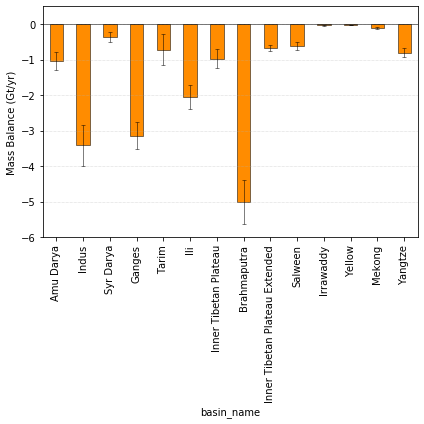

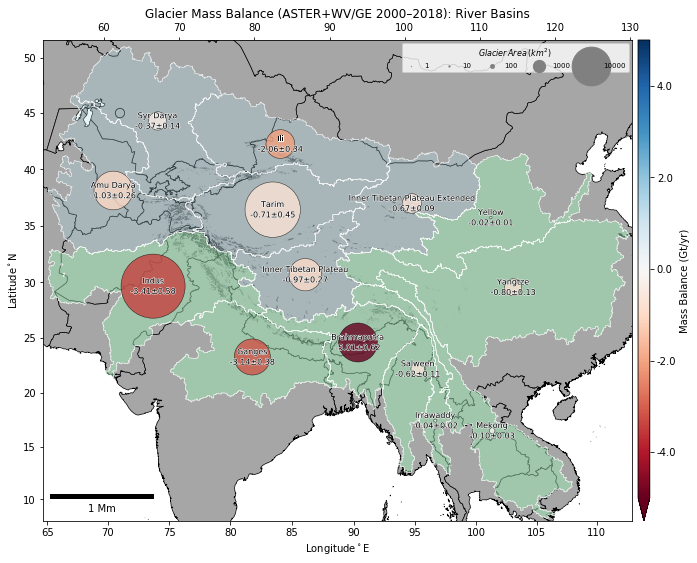

In [190]:
mb_unit = 'Gta'
basin_melt_gt_clim = (-5, 5)
ylim = (-6.0, 0.5)
col=('mb_Gta', 'sum', 'sum')
sigma_col=('mb_Gta_sigma', 'sum', 'rss')

extent = [-2396534,-2619071,3273634,2008000]
title = suptitle + ": River Basins"
hex_agg_plot(glac_gdf_mb_hex_basin_agg, basin_df, title, col=col, sigma_col=sigma_col, \
             out_fn_suffix='_hex%s_basin_%s' % (hex_width, mb_unit), clim=basin_melt_gt_clim, hs_bg=False, map=True, glac=True, savefig=True)

In [123]:
hex_agg_plot(glac_gdf_mb_hex_basin_agg_brun, basin_df, title, col=col, sigma_col=sigma_col, \
             out_fn_suffix='_hex%s_basin_brun_%s' % (hex_width, mb_unit), clim=basin_melt_gt_clim, hs_bg=False, map=False)

NameError: name 'glac_gdf_mb_hex_basin_agg_brun' is not defined

In [245]:
basin_melt_gt_clim = (-5, 0)
mb_unit = 'Gta'
ylim = (-6.0, 0.5)
extent = [-2396534,-2619071,3273634,2008000]
title = suptitle + ": Excess meltwater runoff"

col = ('meltwater_Gta', 'sum','sum')
sigma_col = ('meltwater_Gta_sigma','sum','rss')
out_fn_suffix = '_hex%s_basin_excess_allglac_%s' % (hex_width, mb_unit)
#col = ('meltwater_Gta_hex', 'sum','sum')
#sigma_col = ('meltwater_Gta_hex_sigma','sum','rss')
#out_fn_suffix = '_hex%s_basin_excess_%s' % (hex_width, mb_unit)

[0.47277565 1.3        0.10607261 0.41301696 0.97165136 0.26153928
 0.33081483 0.48090408 0.12043041 0.05893781 0.00299916 0.0019185
 0.01032068 0.09035426]
Plotting borders
Plotting glacier polygons
('meltwater_Gta', 'sum', 'sum')
Plotting scatterplot of ('meltwater_Gta', 'sum', 'sum') values
Adding annotations


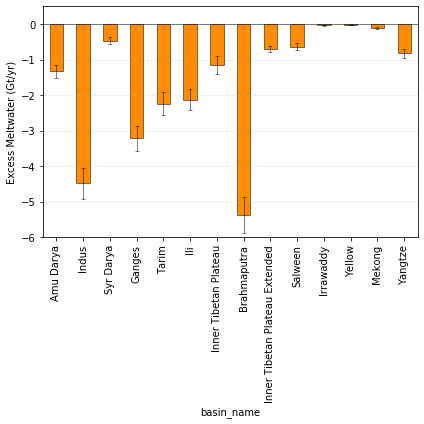

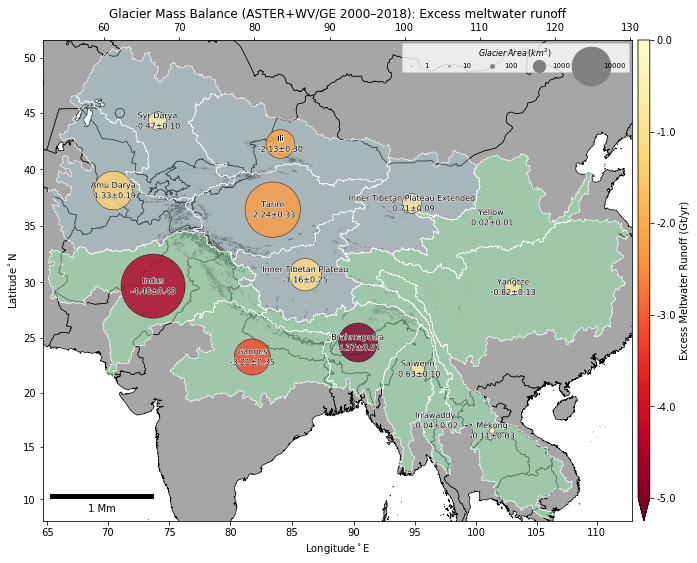

In [246]:
hex_agg_plot(glac_gdf_mb_hex_basin_agg, basin_df, title, col=col, sigma_col=sigma_col, \
             out_fn_suffix=out_fn_suffix, clim=basin_melt_gt_clim, hs_bg=False, map=True, savefig=True, glac=True)

In [439]:
#hex_agg_plot(glac_gdf_mb_hex_basin_agg_brun, basin_df, title, col=col, sigma_col=sigma_col, \
#             out_fn_suffix='_hex%s_excess_brun_%s' % (hex_width, mb_unit), clim=basin_melt_gt_clim, hs_bg=False, map=False, savefig=True)

In [192]:
agg_sum = glac_gdf_mb_hex_basin_agg[('mb_Gta','sum','sum')].sum()
agg_sigma_sum = glac_gdf_mb_hex_basin_agg[('mb_Gta_sigma','sum','rss')].sum()
agg_sigma_rss = rss(glac_gdf_mb_hex_basin_agg[('mb_Gta_sigma','sum','rss')])
print('%0.2f\u00b1%0.2f Gt/yr' % (agg_sum, agg_sigma_sum))
print('%0.2f\u00b1%0.2f Gt/yr' % (agg_sum, agg_sigma_rss))

-18.96±3.44 Gt/yr
-18.96±1.18 Gt/yr


## Excess meltwater analysis and SLR

In [193]:
glac_gdf_mb_hex_basin_agg['mb_m3wea','sum','sum']/1E9

basin_name
Amu Darya                        -1.03
Indus                            -3.41
Syr Darya                        -0.37
Ganges                           -3.14
Tarim                            -0.71
Ili                              -2.06
Inner Tibetan Plateau            -0.97
Brahmaputra                      -5.01
Inner Tibetan Plateau Extended   -0.67
Salween                          -0.62
Irrawaddy                        -0.04
Yellow                           -0.02
Mekong                           -0.10
Yangtze                          -0.80
Name: (mb_m3wea, sum, sum), dtype: float64

In [194]:
glac_gdf_mb_hex_basin_agg['mb_m3wea_sigma','sum','rss']/1E9

basin_name
Amu Darya                        0.26
Indus                            0.58
Syr Darya                        0.14
Ganges                           0.38
Tarim                            0.45
Ili                              0.34
Inner Tibetan Plateau            0.27
Brahmaputra                      0.62
Inner Tibetan Plateau Extended   0.09
Salween                          0.11
Irrawaddy                        0.02
Yellow                           0.01
Mekong                           0.03
Yangtze                          0.13
Name: (mb_m3wea_sigma, sum, rss), dtype: float64

In [195]:
glac_gdf_mb_hex_basin_agg['mb_m3wea','sum','size']

basin_name
Amu Darya                         87.00
Indus                            187.00
Syr Darya                         67.00
Ganges                            72.00
Tarim                            163.00
Ili                               66.00
Inner Tibetan Plateau            151.00
Brahmaputra                      160.00
Inner Tibetan Plateau Extended    86.00
Salween                           42.00
Irrawaddy                          5.00
Yellow                             5.00
Mekong                            12.00
Yangtze                           63.00
Name: (mb_m3wea, sum, size), dtype: float64

In [196]:
glac_gdf_mb_hex_basin_agg['meltwater','total_m3a','sum']/1E9

basin_name
Amu Darya                        -1.33
Indus                            -4.48
Syr Darya                        -0.47
Ganges                           -3.21
Tarim                            -2.24
Ili                              -2.13
Inner Tibetan Plateau            -1.16
Brahmaputra                      -5.37
Inner Tibetan Plateau Extended   -0.71
Salween                          -0.63
Irrawaddy                        -0.04
Yellow                           -0.02
Mekong                           -0.11
Yangtze                          -0.82
Name: (meltwater, total_m3a, sum), dtype: float64

In [197]:
glac_gdf_mb_hex_basin_agg['meltwater','total_m3a_sigma','rss']/1E9

basin_name
Amu Darya                        0.19
Indus                            0.43
Syr Darya                        0.10
Ganges                           0.35
Tarim                            0.33
Ili                              0.30
Inner Tibetan Plateau            0.25
Brahmaputra                      0.51
Inner Tibetan Plateau Extended   0.09
Salween                          0.10
Irrawaddy                        0.02
Yellow                           0.01
Mekong                           0.03
Yangtze                          0.13
Name: (meltwater, total_m3a_sigma, rss), dtype: float64

In [237]:
basin_sum = glac_gdf_mb_hex_basin_agg.sum()
basin_rss = rss(glac_gdf_mb_hex_basin_agg)
basin_sum/1E9

mb_m3wea_sigma           sum              sum       21.50
                                          rss        3.44
                                          rms        0.35
mb_m3wea                 sum              sum      -18.96
                                          size       0.00
z_med                    median           mean       0.00
                                          median     0.00
Area_all                 sum              sum        0.00
meltwater                total_m3a        sum      -22.71
                         total_m3a_sigma  sum       16.44
                                          rss        2.84
                                          rms        0.29
centroid_x                                           0.01
centroid_y                                          -0.00
mb_Gta                   sum              sum       -0.00
mb_Gta_sigma             sum              rss        0.00
mb_mwea                  sum              sum       -0.00
mb_mwea_sigma 

In [212]:
basin_sum

mb_m3wea_sigma           sum              sum       21,500,476,323.92
                                          rss        3,440,293,520.87
                                          rms          347,467,477.35
mb_m3wea                 sum              sum      -18,962,813,928.53
                                          size               1,166.00
z_med                    median           mean              69,234.40
                                          median            70,029.65
Area_all                 sum              sum               97,296.32
meltwater                total_m3a        sum      -22,711,674,160.09
                         total_m3a_sigma  sum       16,441,017,679.65
                                          rss        2,836,077,942.87
                                          rms          294,524,041.82
centroid_x                                               5,448,037.42
centroid_y                                              -3,589,648.70
mb_Gta              

In [238]:
basin_rss

mb_m3wea_sigma           sum              sum      8,133,094,625.05
                                          rss      1,176,213,889.75
                                          rms        107,877,806.25
mb_m3wea                 sum              sum      7,417,271,660.80
                                          size               380.60
z_med                    median           mean            18,616.75
                                          median          18,835.40
Area_all                 sum              sum             39,242.62
meltwater                total_m3a        sum      8,584,056,263.27
                         total_m3a_sigma  sum      6,091,825,519.81
                                          rss        954,374,866.64
                                          rms         90,753,012.24
centroid_x                                             4,860,825.21
centroid_y                                             3,555,231.60
mb_Gta                   sum              sum   

### Total excess meltwater aggregated for all glaciers in each basin

In [199]:
print('%0.2f\u00b1%0.2f Gt/yr' % (basin_sum[('meltwater_Gta', 'sum','sum')], basin_sum[('meltwater_Gta_sigma','sum','rss')]))

-22.71±2.84 Gt/yr


### Total excess meltwater aggregated for all hex cells in each basin

In [202]:
print('%0.2f\u00b1%0.2f Gt/yr' % (basin_sum[('meltwater_Gta_hex', 'sum','sum')], basin_sum[('meltwater_Gta_hex_sigma','sum','rss')]))

-20.61±3.28 Gt/yr


### Total excess meltwater sum of basin values (from aggregated hex cells)

In [239]:
#print('%0.2f\u00b1%0.2f Gt/yr' % (basin_sum[col], basin_sum[sigma_col]))
print('%0.2f\u00b1%0.2f Gt/yr' % (basin_sum[('meltwater_Gta_hex', 'sum','sum')], basin_rss[('meltwater_Gta_hex_sigma','sum','rss')]))

-20.61±1.12 Gt/yr


## Split into endorheic and exorheic basins

In [264]:
#col = ('meltwater_Gta', 'sum','sum')
#sigma_col = ('meltwater_Gta_sigma','sum','rss')
#col = ('meltwater_Gta_hex', 'sum','sum')
#sigma_col = ('meltwater_Gta_hex_sigma','sum','rss')
col=('mb_Gta', 'sum', 'sum')
sigma_col=('mb_Gta_sigma', 'sum', 'rss')

In [265]:
#Exohreic basins
endo_sum = glac_gdf_mb_hex_basin_agg[glac_gdf_mb_hex_basin_agg['ENDO'] == 1].sum()
exo_sum = glac_gdf_mb_hex_basin_agg[glac_gdf_mb_hex_basin_agg['ENDO'] == 0].sum()
exo_rss = rss(glac_gdf_mb_hex_basin_agg[glac_gdf_mb_hex_basin_agg['ENDO'] == 0])

In [266]:
#Endo SLR contribution
print('%0.2f\u00b1%0.2f Gt/yr' % (endo_sum[col], endo_sum[sigma_col]))
print('%0.3f\u00b1%0.3f mm/yr' % (endo_sum[col]/Gt2mm, endo_sum[sigma_col]/Gt2mm))

-5.82±1.55 Gt/yr
-0.016±0.004 mm/yr


In [271]:
#Exo Meltwater SLR contribution
print('%0.2f\u00b1%0.2f Gt/yr' % (exo_sum[col], exo_sum[sigma_col]))
print('%0.1f\u00b1%0.1f Gt/yr' % (exo_sum[col], exo_rss[sigma_col]))
print('%0.3f\u00b1%0.3f mm/yr' % (exo_sum[col]/Gt2mm, exo_sum[sigma_col]/Gt2mm))
print('%0.3f\u00b1%0.3f mm/yr' % (exo_sum[col]/Gt2mm, exo_rss[sigma_col]/Gt2mm))

-13.15±1.89 Gt/yr
-13.1±0.9 Gt/yr
-0.036±0.005 mm/yr
-0.036±0.003 mm/yr


In [243]:
#Total for 2000-2018
print('%0.2f\u00b1%0.2f Gt' % (18*exo_sum[col], 18*exo_sum[sigma_col]))
print('%0.3f\u00b1%0.3f mm' % (18*exo_sum[col]/Gt2mm, 18*exo_sum[sigma_col]/Gt2mm))

-236.64±34.04 Gt
-0.653±0.094 mm


In [272]:
0.036/0.92

0.03913043478260869

In [273]:
0.052/0.92

0.056521739130434775

In [274]:
0.052*18

0.9359999999999999

## Aggregate all glaciers, not hex cells

In [228]:
append_centroid_xy(basin_df_endo)
glac_gdf_mb_hex_basin_endo_agg = hex_agg(glac_gdf_mb_hex, basin_df_endo, 'ENDO')
glac_gdf_mb_hex_basin_endo_agg

One-time spatial join by hex
(1166, 66)


mb_m3wea_sigma                                        mb_m3wea         \
                   sum                                             sum          
                   sum            rss           rms                sum   size   
ENDO                                                                            
1     9,285,748,038.84 696,570,692.37 27,974,952.20  -5,815,883,362.13 620.00   
0    12,214,728,285.08 947,770,217.39 40,560,820.90 -13,146,930,566.40 546.00   

        z_med           Area_all          meltwater                   \
       median                sum          total_m3a  total_m3a_sigma   
         mean   median       sum                sum              sum   
ENDO                                                                   
1    4,850.51 4,975.37 47,646.43  -8,032,258,391.81 6,576,586,307.54   
0    5,297.85 5,334.42 49,649.89 -14,679,415,768.28 9,864,431,372.10   

                                   centroid_x  centroid_y mb_Gta mb_Gta_sigma  \
                                                             sum          sum   
                rss           rms                            sum          rss   
ENDO                                                                            
1    561,256,437.11 22,989,959.44 -462,571.98  617,780.25  -5.82         0.70   
0    771,895,457.87 33,186,377.79  875,027.54 -665,391.40 -13.15         0.95   

     mb_mwea mb_mwea_sigma meltwater_Gta meltwater_Gta_sigma       \
         sum           sum           sum                 sum        
         sum           rss           sum                 rss  sum   
ENDO                                                                
1      -0.12          0.01         -8.03                0.56 6.58   
0      -0.26          0.02        -14.68                0.77 9.86   

     meltwater_Gta_hex meltwater_Gta_hex_sigma        
                   sum                     sum        
                   sum                     rss   sum  
ENDO                                                  
1                -7.04                    0.64  7.28  
0               -13.57                    0.91 11.21

In [234]:
#Endo SLR contribution
print('%0.2f\u00b1%0.2f Gt/yr' % (glac_gdf_mb_hex_basin_endo_agg.iloc[0][col], \
                                  glac_gdf_mb_hex_basin_endo_agg.iloc[0][sigma_col]))
print('%0.3f\u00b1%0.3f mm/yr' % (glac_gdf_mb_hex_basin_endo_agg.iloc[0][col]/Gt2mm, \
                                  glac_gdf_mb_hex_basin_endo_agg.iloc[0][sigma_col]/Gt2mm))

-5.82±0.70 Gt/yr
-0.016±0.002 mm/yr


In [235]:
#Exo Meltwater SLR contribution
print('%0.2f\u00b1%0.2f Gt/yr' % (glac_gdf_mb_hex_basin_endo_agg.iloc[1][col], \
                                  glac_gdf_mb_hex_basin_endo_agg.iloc[1][sigma_col]))
print('%0.3f\u00b1%0.3f mm/yr' % (glac_gdf_mb_hex_basin_endo_agg.iloc[1][col]/Gt2mm, \
                                  glac_gdf_mb_hex_basin_endo_agg.iloc[1][sigma_col]/Gt2mm))

-13.15±0.95 Gt/yr
-0.036±0.003 mm/yr


In [236]:
glac_gdf_mb_hex_basin_agg.columns

MultiIndex([(         'mb_m3wea_sigma',             'sum',    'sum'),
            (         'mb_m3wea_sigma',             'sum',    'rss'),
            (         'mb_m3wea_sigma',             'sum',    'rms'),
            (               'mb_m3wea',             'sum',    'sum'),
            (               'mb_m3wea',             'sum',   'size'),
            (                  'z_med',          'median',   'mean'),
            (                  'z_med',          'median', 'median'),
            (               'Area_all',             'sum',    'sum'),
            (              'meltwater',       'total_m3a',    'sum'),
            (              'meltwater', 'total_m3a_sigma',    'sum'),
            (              'meltwater', 'total_m3a_sigma',    'rss'),
            (              'meltwater', 'total_m3a_sigma',    'rms'),
            (             'centroid_x',                '',       ''),
            (             'centroid_y',                '',       ''),
            (       

In [833]:
#These are identical to ('mb_mwea','sum','sum')
#glac_gdf_mb_hex_basin_agg['mb_Gta_to_mwea','',''] = glac_gdf_mb_hex_basin_agg['mb_m3wea','sum','sum']/glac_gdf_mb_hex_basin_agg['Area_all','sum','sum']/1E6
#glac_gdf_mb_hex_basin_agg['mb_Gta_to_mwea_sigma','',''] = glac_gdf_mb_hex_basin_agg['mb_m3wea_sigma','sum','rss']/glac_gdf_mb_hex_basin_agg['Area_all','sum','sum']/1E6
glac_gdf_mb_hex_basin_agg['meltwater_mwea','',''] = glac_gdf_mb_hex_basin_agg['meltwater','total_m3a','sum']/glac_gdf_mb_hex_basin_agg['Area_all','sum','sum']/1E6
glac_gdf_mb_hex_basin_agg['meltwater_mwea_sigma','',''] = glac_gdf_mb_hex_basin_agg['meltwater','total_m3a_sigma','rss']/glac_gdf_mb_hex_basin_agg['Area_all','sum','sum']/1E6

In [834]:
glac_gdf_mb_hex_basin_agg

mb_m3wea_sigma                               \
                                            sum                                
                                            sum            rss           rms   
basin_name                                                                     
Amu Darya                      1,707,722,617.39 170,558,418.34 12,341,174.02   
Indus                          4,947,027,294.17 400,501,967.96 19,950,424.06   
Syr Darya                        764,090,399.19 111,712,053.65 10,032,038.57   
Ganges                         2,173,827,187.45 270,820,142.40 23,053,741.49   
Tarim                          3,814,520,982.12 360,952,104.01 20,241,188.89   
Ili                            1,447,095,502.43 241,335,603.22 22,216,743.07   
Inner Tibetan Plateau            853,797,593.71 118,573,961.08  8,012,485.76   
Brahmaputra                    4,077,916,851.38 446,936,161.38 25,933,866.44   
Inner Tibetan Plateau Extended   713,065,565.70 185,605,708.61 15,521,129.08   
Salween                          437,399,659.69 100,622,524.22 11,320,918.46   
Irrawaddy                         14,886,267.33   7,144,042.42  2,700,194.23   
Yellow                            53,927,487.30  30,483,804.74  9,639,825.47   
Mekong                            84,031,787.31  32,956,337.68  7,191,662.48   
Yangtze                          411,167,128.76 106,172,927.12 11,069,292.84   

                                        mb_m3wea           z_med           \
                                             sum          median            
                                             sum   size     mean   median   
basin_name                                                                  
Amu Darya                      -1,018,463,571.91 191.00 4,571.40 4,682.66   
Indus                          -3,465,229,049.97 403.00 5,226.60 5,290.60   
Syr Darya                        -397,730,826.57 124.00 3,895.28 3,862.09   
Ganges                         -3,068,245,564.83 138.00 5,435.84 5,423.05   
Tarim                          -1,109,522,413.84 318.00 5,008.57 5,130.95   
Ili                            -1,764,497,011.53 118.00 3,746.07 3,757.33   
Inner Tibetan Plateau            -834,926,087.09 219.00 5,750.04 5,834.48   
Brahmaputra                    -4,923,647,196.83 297.00 5,388.20 5,417.60   
Inner Tibetan Plateau Extended   -677,943,054.65 143.00 4,943.43 4,959.78   
Salween                          -818,517,006.51  79.00 5,297.53 5,357.51   
Irrawaddy                         -16,026,681.57   7.00 4,698.87 4,736.66   
Yellow                            -77,821,488.09  10.00 4,832.21 4,837.49   
Mekong                           -125,431,929.55  21.00 5,251.97 5,296.26   
Yangtze                          -664,812,045.58  92.00 5,241.89 5,230.37   

                                Area_all         meltwater                   \
                                     sum         total_m3a  total_m3a_sigma   
                                     sum               sum              sum   
basin_name                                                                    
Amu Darya                       9,712.01 -1,297,031,727.02 1,170,636,060.29   
Indus                          27,693.84 -4,530,404,400.73 3,453,720,405.79   
Syr Darya                       2,442.90   -514,645,507.18   537,646,008.77   
Ganges                          8,378.11 -3,135,076,463.94 1,996,866,098.27   
Tarim                          22,640.05 -2,673,532,282.13 2,251,995,044.52   
Ili                             4,473.11 -1,818,259,319.95 1,327,654,073.28   
Inner Tibetan Plateau           5,335.28   -997,353,191.42   661,708,311.41   
Brahmaputra                    10,272.86 -5,286,930,138.19 3,457,043,798.12   
Inner Tibetan Plateau Extended  2,921.32   -729,020,979.90   633,798,580.11   
Salween                         1,354.32   -830,514,167.50   413,183,835.14   
Irrawaddy                          24.70    -17,003,038.57    12,621,097.56   
Yellow              

In [248]:
glac_gdf_mb_hex_basin_agg.columns

MultiIndex([(         'mb_m3wea_sigma',             'sum',    'sum'),
            (         'mb_m3wea_sigma',             'sum',    'rss'),
            (         'mb_m3wea_sigma',             'sum',    'rms'),
            (               'mb_m3wea',             'sum',    'sum'),
            (               'mb_m3wea',             'sum',   'size'),
            (                  'z_med',          'median',   'mean'),
            (                  'z_med',          'median', 'median'),
            (               'Area_all',             'sum',    'sum'),
            (              'meltwater',       'total_m3a',    'sum'),
            (              'meltwater', 'total_m3a_sigma',    'sum'),
            (              'meltwater', 'total_m3a_sigma',    'rss'),
            (              'meltwater', 'total_m3a_sigma',    'rms'),
            (             'centroid_x',                '',       ''),
            (             'centroid_y',                '',       ''),
            (       

In [255]:
basin_df.area/1E6

basin_name
Irrawaddy                          390,673.97
Salween                            280,908.50
Ganges                             946,058.08
Mekong                             768,243.38
Tarim                              983,017.40
Amu Darya                        1,123,674.15
Indus                            1,316,074.68
Ili                                941,437.06
Syr Darya                        1,113,237.95
Yangtze                          1,918,723.56
Inner Tibetan Plateau              681,981.08
Brahmaputra                        635,083.43
Inner Tibetan Plateau Extended     822,869.13
Yellow                             815,041.01
dtype: float64

In [256]:
basin_summary = glac_gdf_mb_hex_basin_agg[[('mb_Gta','sum','sum'),('mb_Gta_sigma','sum','rss'),\
                            ('meltwater_Gta','sum','sum'),('meltwater_Gta_sigma','sum','rss'),\
                            ('meltwater_Gta_hex','sum','sum'),('meltwater_Gta_hex_sigma','sum','rss'),\
                            ('Area_all','sum','sum')]]
basin_summary['ENDO'] = glac_gdf_mb_hex_basin_agg['ENDO']
basin_summary['basin_area'] = basin_df.area/1E6
basin_summary['basin_glac_area_perc'] = 100*basin_summary[('Area_all','sum','sum')]/basin_summary['basin_area']
out_fn = os.path.splitext(glac_shp_join_fn)[0]+'_hex%s_basin_summary.pkl' % hex_width
basin_summary.to_pickle(out_fn)

/Users/dshean/sw/miniconda3/envs/shean_py3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/dshean/sw/miniconda3/envs/shean_py3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/dshean/sw/miniconda3/envs/shean_py3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

In [836]:
basin_summary

mb_Gta mb_Gta_sigma meltwater_Gta  \
                                  sum          sum           sum   
                                  sum          rss           sum   
basin_name                                                         
Amu Darya                       -1.02         0.17         -1.30   
Indus                           -3.47         0.40         -4.53   
Syr Darya                       -0.40         0.11         -0.51   
Ganges                          -3.07         0.27         -3.14   
Tarim                           -1.11         0.36         -2.67   
Ili                             -1.76         0.24         -1.82   
Inner Tibetan Plateau           -0.83         0.12         -1.00   
Brahmaputra                     -4.92         0.45         -5.29   
Inner Tibetan Plateau Extended  -0.68         0.19         -0.73   
Salween                         -0.82         0.10         -0.83   
Irrawaddy                       -0.02         0.01         -0.02   
Yellow                          -0.08         0.03         -0.08   
Mekong                          -0.13         0.03         -0.13   
Yangtze                         -0.66         0.11         -0.68   

                               meltwater_Gta_sigma meltwater_Gta_hex  \
                                               sum               sum   
                                               rss               sum   
basin_name                                                             
Amu Darya                                     0.13             -1.10   
Indus                                         0.30             -4.02   
Syr Darya                                     0.08             -0.44   
Ganges                                        0.25             -3.07   
Tarim                                         0.28             -2.24   
Ili                                           0.23             -1.77   
Inner Tibetan Plateau                         0.10             -0.93   
Brahmaputra                                   0.38             -5.02   
Inner Tibetan Plateau Extended                0.17             -0.69   
Salween                                       0.10             -0.82   
Irrawaddy                                     0.01             -0.02   
Yellow                                        0.03             -0.08   
Mekong                                        0.03             -0.13   
Yangtze                                       0.10             -0.67   

                               meltwater_Gta_hex_sigma ENDO  
                                                   sum       
                                                   rss       
basin_name                                                   
Amu Darya                                         0.15    1  
Indus                                             0.36    0  
Syr Darya                                         0.10    1  
Ganges                                            0.27    0  
Tarim                                             0.31    1  
Ili                                               0.24    1  
Inner Tibetan Plateau                             0.11    1  
Brahmaputra                                       0.43    0  
Inner Tibetan Plateau Extended                    0.19    1  
Salween                                           0.10    0  
Irrawaddy                                         0.01    0  
Yellow                                            0.03    0  
Mekong                                            0.03    0  
Yangtze                                           0.11    0

In [204]:
## Basin mass balance in mwea

[0.47277565 1.3        0.10607261 0.41301696 0.97165136 0.26153928
 0.33081483 0.48090408 0.12043041 0.05893781 0.00299916 0.0019185
 0.01032068 0.09035426]
Plotting borders
Plotting glacier polygons
('mb_mwea', 'sum', 'sum')
Plotting scatterplot of ('mb_mwea', 'sum', 'sum') values
Adding annotations


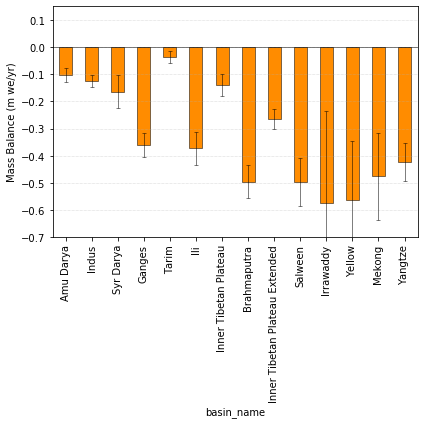

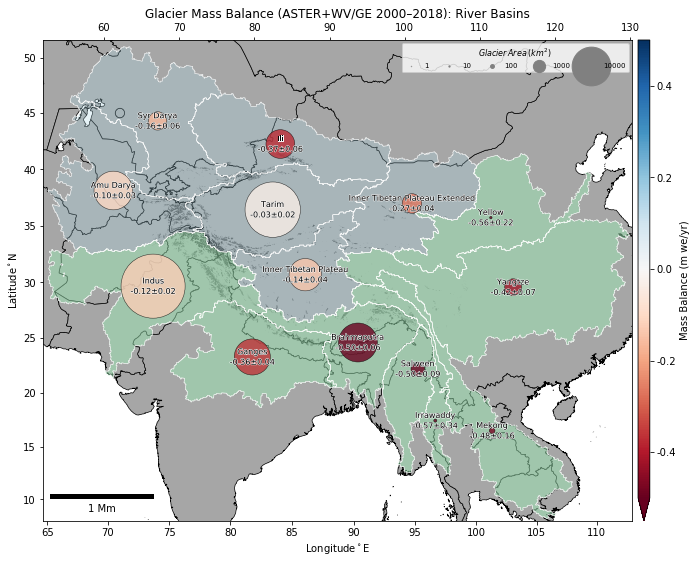

In [457]:
basin_melt_mwea_clim = (-0.5, 0.5)
mb_unit = 'mwea'
ylim = (-0.7, 0.15)
extent = [-2396534,-2619071,3273634,2008000]
title = suptitle + ": River Basins"
out_fn_suffix = '_hex%s_basin_mb_%s' % (hex_width, mb_unit)
#glac_gdf_mb_hex_basin_agg = hex_agg(glac_gdf_mb_hex, basin_df, basin_col)
#col = ('meltwater_mwea','','')
#sigma_col = ('meltwater_mwea_sigma','','')
col = ('mb_mwea','sum','sum')
sigma_col = ('mb_mwea_sigma','sum','rss')
hex_agg_plot(glac_gdf_mb_hex_basin_agg, basin_df, title, out_fn_suffix, clim=basin_melt_mwea_clim, col=col, sigma_col=sigma_col, hs_bg=False, savefig=True, glac=True)